# 3D Cervical Vertebrae Segmentation (RSNA 2022) with MONAI - Inference

In [1]:
# Install packages
! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom
! pip install pyjpegls
! pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.1 MB/s eta 0:00:00


In [2]:
# Import libraries
import os
import warnings
from glob import glob
import time
import random
import string
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndi

# DICOM image files (.dcm)
import pydicom
from pydicom import dcmread

# NIfTI image files (.nii)
import nibabel as nib

# Required dependencies
import gdcm
import pylibjpeg

# Pytorch
import torch
import torch.nn as nn
from torch.nn.functional import one_hot

# Monai
import monai
from monai.data import ArrayDataset, DataLoader, decollate_batch
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    Resize,
    ScaleIntensity,
    RandFlip,
    RandAffine,
    RandGridDistortion
)
from monai.utils import set_determinism, first

# Sklearn
from sklearn.model_selection import KFold

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Resuming Configuration

In [3]:
# Path 
base_path = "../input/rsna-2022-cervical-spine-fracture-detection"
TRAIN_IMAGES_PATH = f'{base_path}/train_images'
SEGMENTATIONS_PATH = f'{base_path}/segmentations'
OUTPUT_DIR = '.'

best_model_output = 'HM8659LQ_best_model' # INSERT MODEL ID
best_config_pkl = 'HM8659LQ_config.pkl' # INSERT MODEL ID
MODEL_PATH = f'/kaggle/input/hm8659lq-320-epochs/{best_model_output}' # INSERT DATASET
CONFIG_PATH = f'/kaggle/input/hm8659lq-320-epochs/{best_config_pkl}' # INSERT DATASET

# Load config from the pkl file
with open(CONFIG_PATH, 'rb') as f:
    config = pickle.load(f)

for k, v in config.items(): print(f'{k}: {v}')

ID: HM8659LQ
spatial_size: (128, 128, 128)
prob: 0.5
k: 5
batch_size: 4
epochs: 320
lr: 0.0001
loss_weights: (0.0, 1.0)
channels: (16, 32, 64, 128, 256)
strides: (2, 2, 2, 2)
kernel_size: 3
up_kernel_size: 3
num_res_units: 2
act: PRELU
dropout: 0.0
bias: True
val_fold_idx: 1


In [4]:
CONFIG_FILE = OUTPUT_DIR + f'/{config["ID"]}_config.pkl'

In [5]:
# Save config to pickle file
with open(CONFIG_FILE, 'wb') as f:
    pickle.dump(config, f)

In [6]:
# Set deterministic training for reproducibility
set_determinism(seed=0)

In [7]:
# Enabling GPU
# https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Enable cuDNN benchmark. Set to True whenever the input model does not change over training, False if, eg, some layers are deactivated
torch.backends.cudnn.benchmark = True

GPU: Tesla T4 is available.
cuda


In [8]:
# Masks to be reverted 
revert_mask = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
    ]

## Functions

In [9]:
def read_dicom_scan(folder_path):
    """ Read CT scan (dicom files) and stack the slices"""
    slices = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split(".")[0])):
        if filename.endswith('.dcm'):
            filepath = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(filepath)
            slices.append(ds.pixel_array)
    scan = np.stack(slices, -1).astype('float64')
    return scan


def read_nifti_file(file_path, revert_mask=revert_mask):
    """ Read nifit file segmentation"""    
    data = nib.load(file_path).get_fdata()
    shape = data.shape
    # Reorient because segmentations are done over the sagittal plane
    data = data.transpose(1, 0, 2)[::-1, :, ::-1]
    # Revert the files that have inverted sequence (from bottom to top)
    if file_path in revert_mask:
        data[:, :, ::-1]
    return data


def zoom_volume(vol, spatial_size):
    """Resize across z-axis"""
    """ NON UTILIZZATA SOSTITUITA DA RESIZE"""
    # Set the desired depth
    desired_width, desired_height, desired_depth = spatial_size
    # Get current depth
    current_depth = vol.shape[-1]
    current_width = vol.shape[0]
    current_height = vol.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    #vol = ndi.zoom(vol, (width_factor, height_factor, depth_factor), order=0, mode='constant')
    zoom_transform = Zoom(zoom=(width_factor, height_factor, depth_factor), keep_size=False)
    zoom_vol = zoom_transform(vol)
    return zoom_vol

def one_hot_encoding_multiclass_mask(mask):
    """ Binary OneHot Encoding of Multi-class masks"""
    labels = list(range(8))
    num_labels = len(labels)
    c, h, w, d = mask.shape
    enc_mask = np.zeros((num_labels, h, w, d))
    for c in range(1, num_labels):  # this loop starts from label 1 to ignore background 0
        enc_mask[c, :, :, :] = (mask == labels[c]) # 1 for the pixel belonging to that class, 0 for the rest of the pixel
        
    return enc_mask

def expand_dims(arr):
    return np.expand_dims(arr, axis=0)

def training_plot(file, output_path, config):
    train_bce_dl_loss = file['Train_bce_dl_loss']
    val_bce_dl_loss = file['Val_bce_dl_loss']
    epochs = range(1, len(train_bce_dl_loss) + 1)
    plt.plot(epochs, train_bce_dl_loss, label='Training BCE-DiceLoss', color='darkblue')
    plt.plot(epochs, val_bce_dl_loss, label='Val BCE-DiceLoss', color='darkorange')
    plt.title('Training & Val Losses')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Training_Losses_plot.png'))
    plt.show()
    
def validation_metric_plot(file, output_path, config):
    val_metric = file['Val_metric']
    epochs = range(1, len(val_metric)+1)
    plt.plot(epochs, val_metric, label='Validation DiceMetric', color='red')
    plt.title('Validation Metric')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Validation_Metric_plot.png'))
    plt.show()

## Data Loading

In [10]:
# Create Dataset
df_train = pd.DataFrame()

# Store all the nifti files in the segmentation folder
df_train['ID'] = os.listdir(SEGMENTATIONS_PATH)

# Remove the extension '.nii'
df_train['ID'] = df_train['ID'].apply(lambda x: x[:-4])

# Print the shape of the dataset
print(df_train.shape)

# Show the head
df_train.head()

(87, 1)


ID
0    1.2.826.0.1.3680043.780
1  1.2.826.0.1.3680043.21321
2   1.2.826.0.1.3680043.6125
3  1.2.826.0.1.3680043.30067
4  1.2.826.0.1.3680043.12833

In [11]:
# Create Dataset
df = pd.DataFrame()

# Store all the nifti files in the segmentation folder
df['ID'] = os.listdir(TRAIN_IMAGES_PATH)

# Add complete path to reach CT scan folder in train_images
df['image_path'] = df['ID'].apply(lambda x: os.path.join(TRAIN_IMAGES_PATH, x))

# Merge on left join
df_test = df.merge(df_train, how='left', on='ID', indicator=True)

# Filter
df_test = df_test[df_test['_merge'] == 'left_only']

# Drop
df_test = df_test.drop(columns=['_merge'])

# Print the shape of the dataset
print(df_test.shape)

# Show the head
df_test.head()

(1932, 2)


ID  \
0  1.2.826.0.1.3680043.17625   
1   1.2.826.0.1.3680043.3850   
2   1.2.826.0.1.3680043.2286   
3  1.2.826.0.1.3680043.14435   
4   1.2.826.0.1.3680043.3442   

                                          image_path  
0  ../input/rsna-2022-cervical-spine-fracture-det...  
1  ../input/rsna-2022-cervical-spine-fracture-det...  
2  ../input/rsna-2022-cervical-spine-fracture-det...  
3  ../input/rsna-2022-cervical-spine-fracture-det...  
4  ../input/rsna-2022-cervical-spine-fracture-det...

## Transforms

In [12]:
# Define test transforms for image (no augmentation)
test_image_trans = Compose(
    [
        # Load data
        read_dicom_scan,
        # Data Preparation
        expand_dims,
        Resize(spatial_size=config['spatial_size'], mode="area"), 
        ScaleIntensity()
    ]
)

In [13]:
# Define test dataset and dataloader
test_ds = ArrayDataset(df_test.image_path, test_image_trans)
test_loader = DataLoader(test_ds, batch_size=config['batch_size'], num_workers=2)

## Resuming Model, Loss & Optimizer

In [14]:
# Define the 3D Unet model
unet_model = UNet(
    spatial_dims = 3, # (Height, Width, Depth)
    in_channels = 1,
    out_channels = 8, # 8 Binary mask 7 as the vertebrae(C1->C7) + background
    channels = config['channels'], # Channels per layer
    strides = config['strides'], # Stride per layers
    kernel_size = config['kernel_size'], # Size of the kernel for each layer
    up_kernel_size = config['up_kernel_size'], # Upsampling convolution kernel size
    num_res_units = config['num_res_units'], # Number of residual units
    act = config['act'], # Activation function
    dropout = config['dropout'], # Dropout rate
    bias = config['bias'] # Presence of bias term in convolution blocks
)
unet_model = unet_model.to(DEVICE)

In [15]:
# Define the transforms to apply to model prediction 
post_trans = Compose([Activations(sigmoid=False, softmax=True, dim=0), AsDiscrete(threshold=0.5)])

In [16]:
# Resume State from checkpoint
checkpoint = torch.load(MODEL_PATH)

# Resume model
unet_model.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_23/3138216396.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH)


<All keys matched successfully>

# Inference

In [17]:
with torch.no_grad():
    test_patient = first(test_loader)
    test_patient = test_patient.to(DEVICE)
    test_outputs = unet_model(test_patient)
    test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


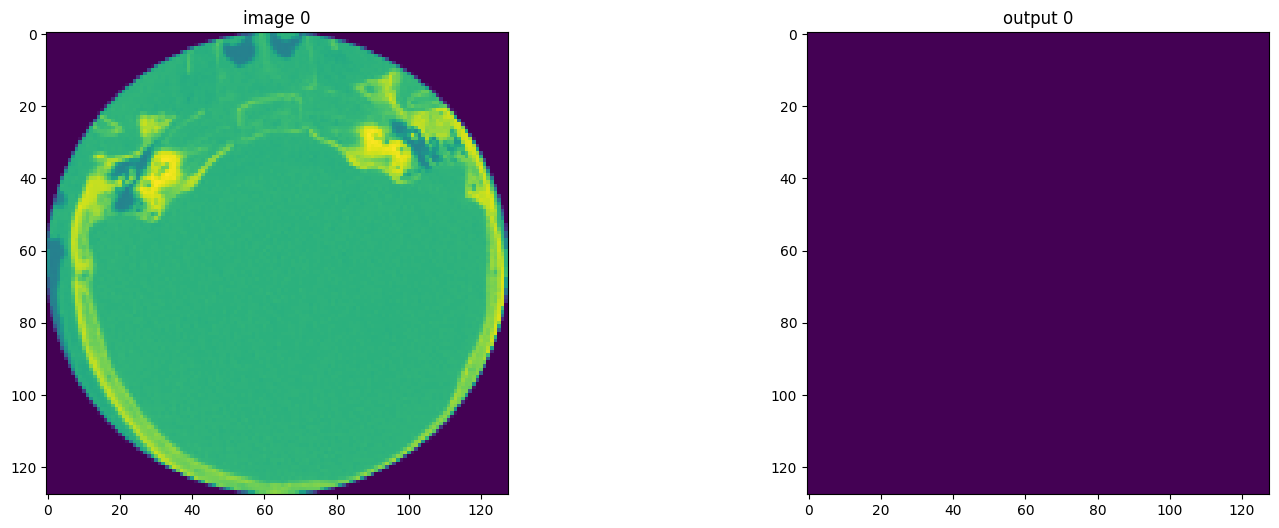

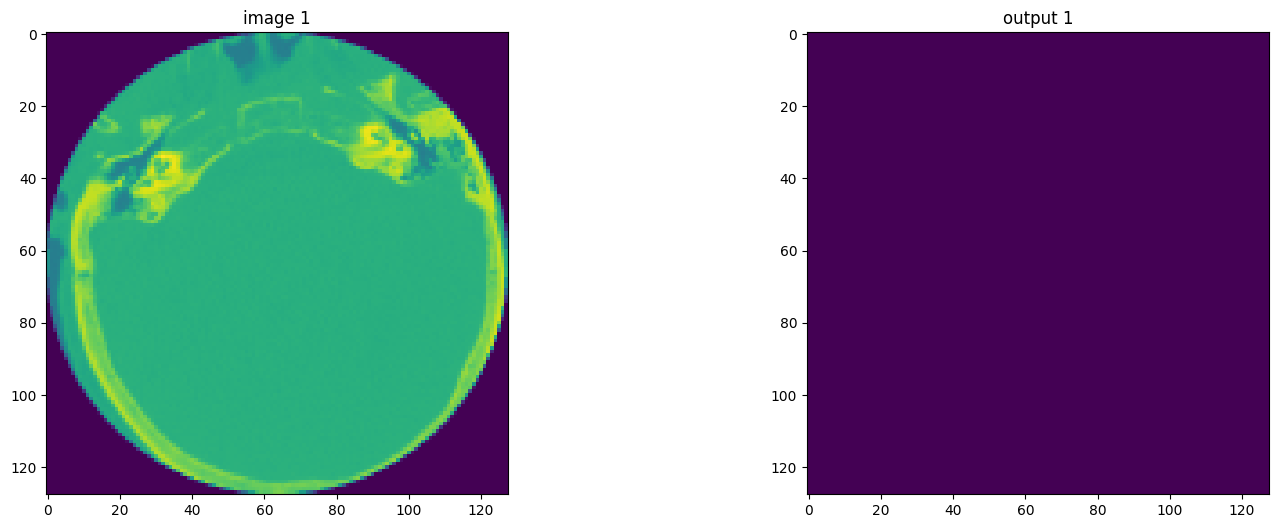

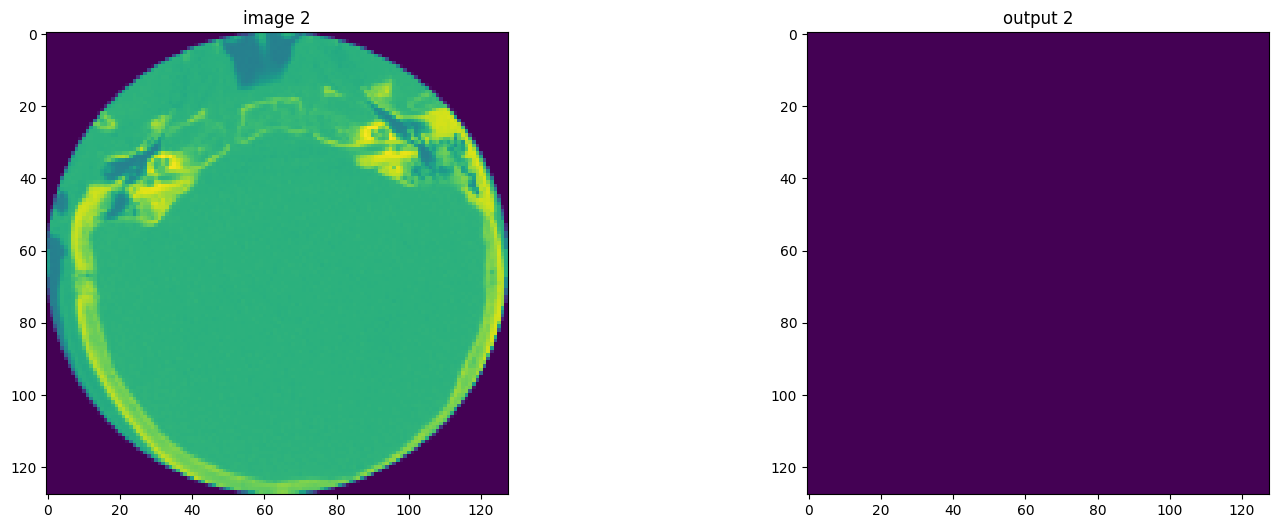

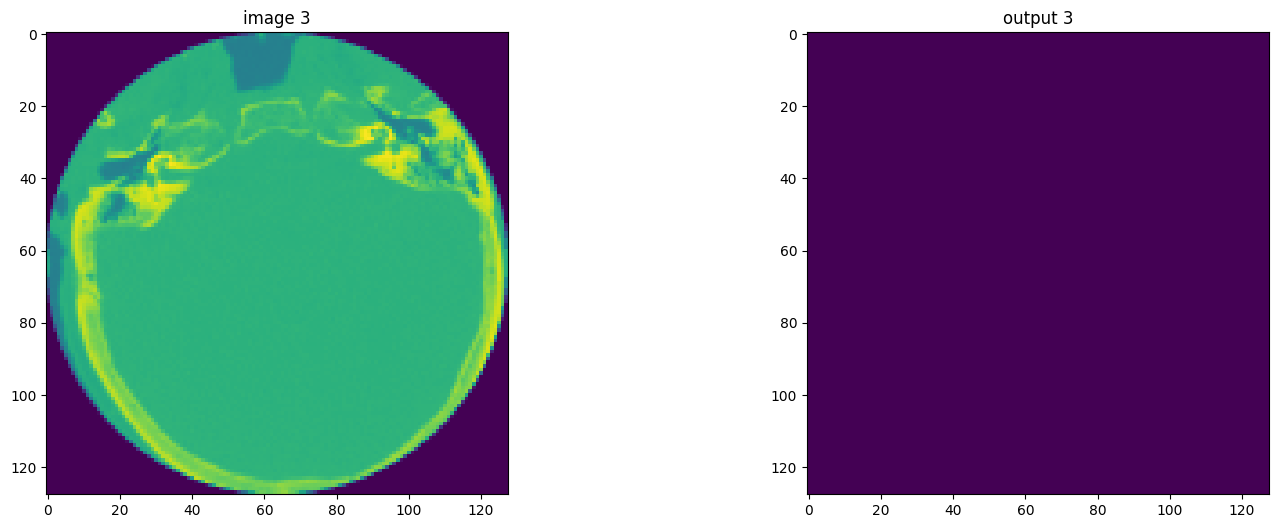

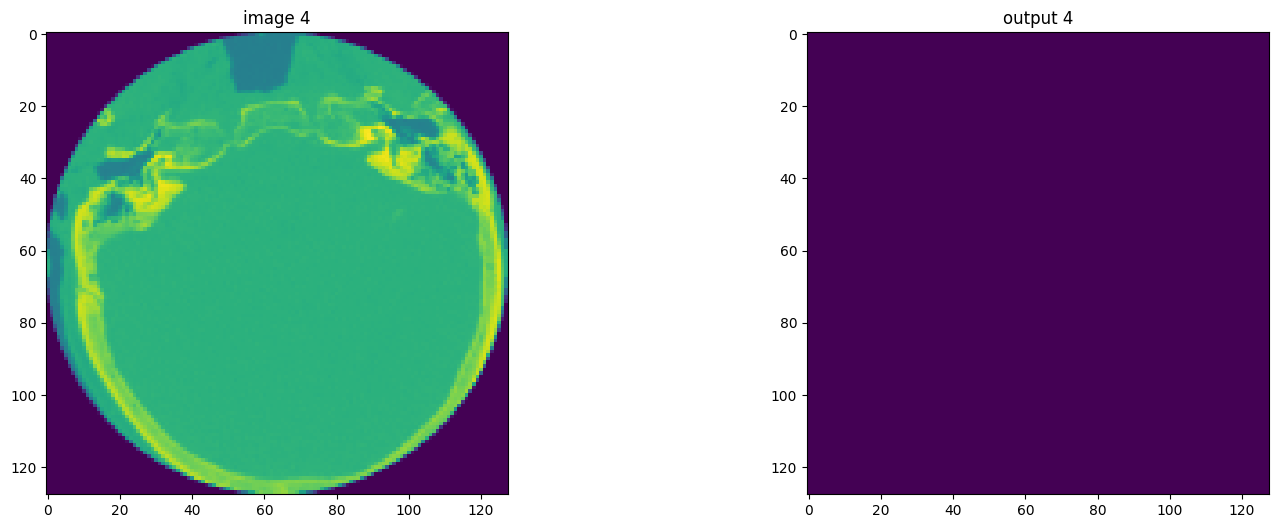

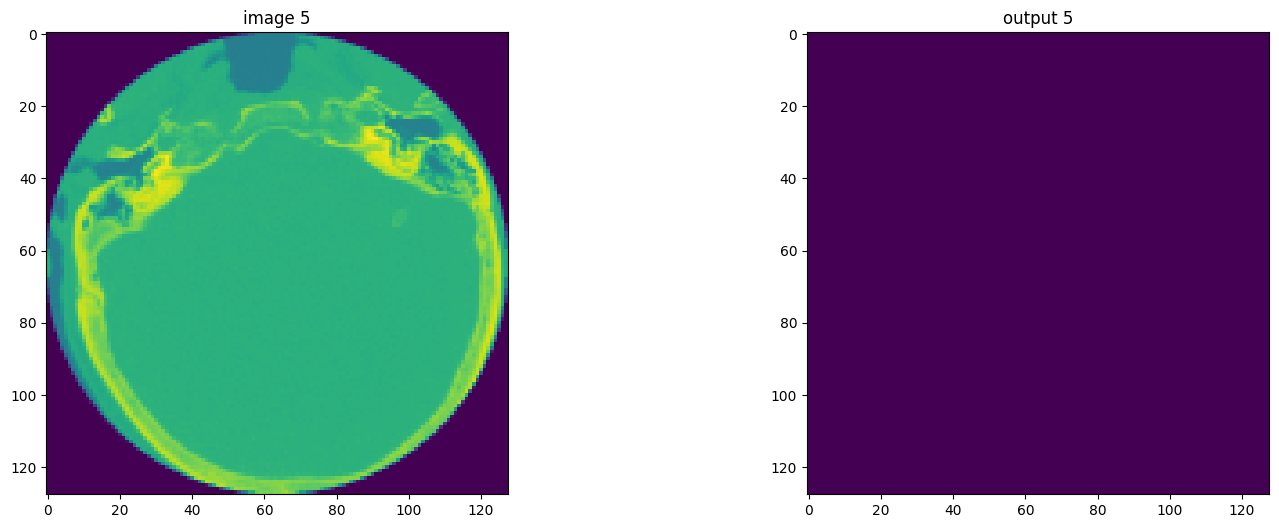

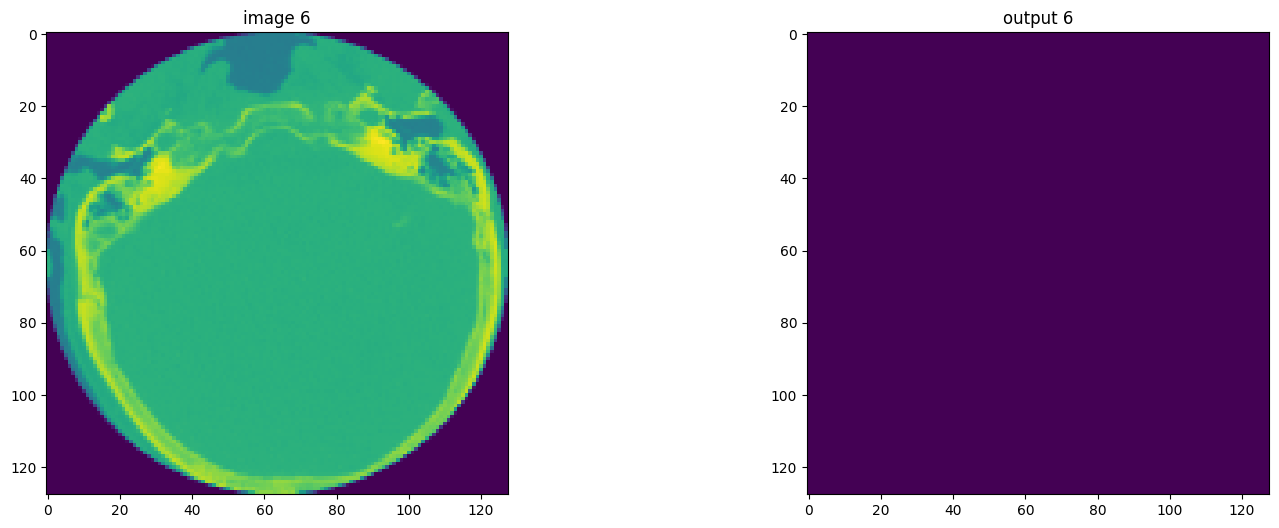

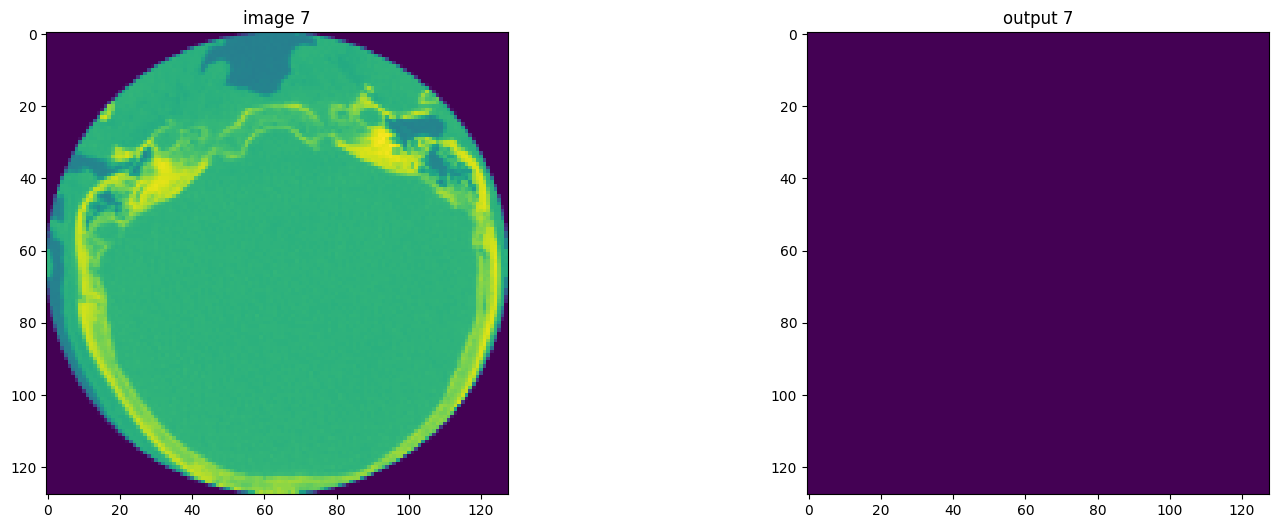

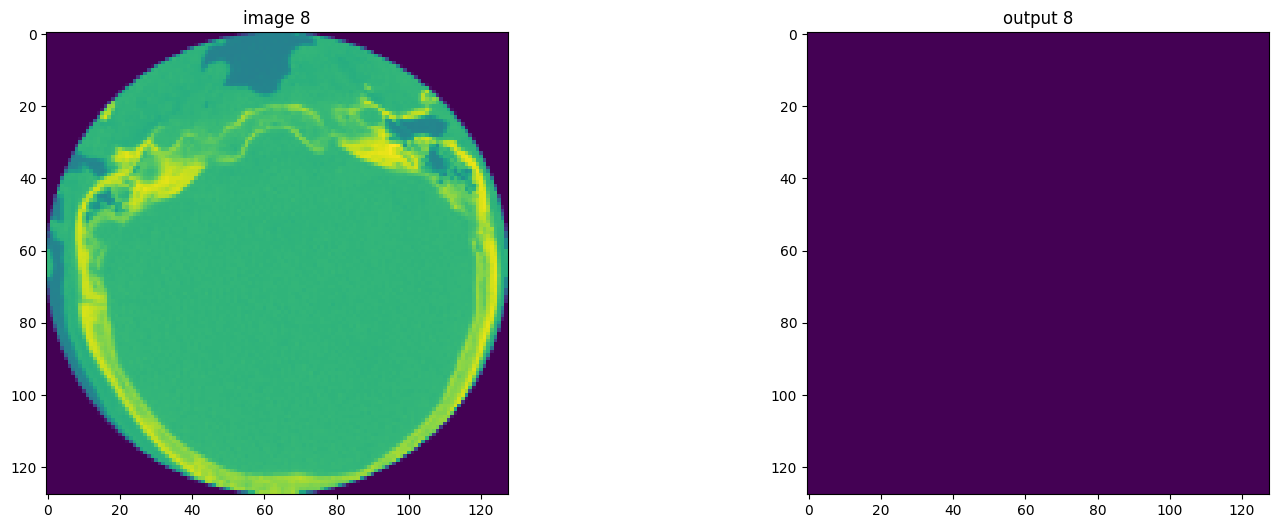

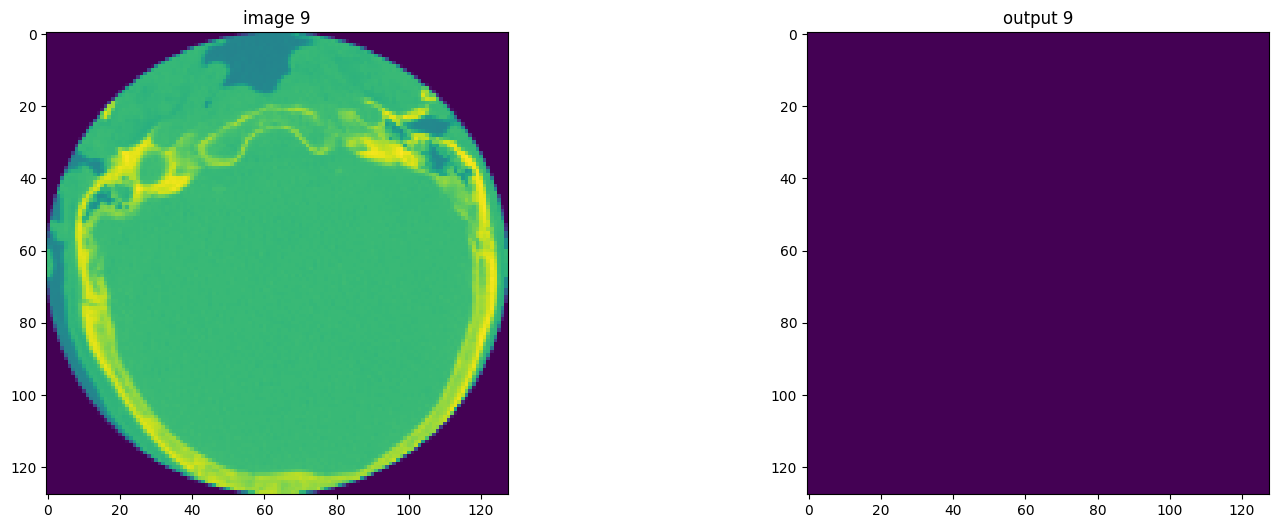

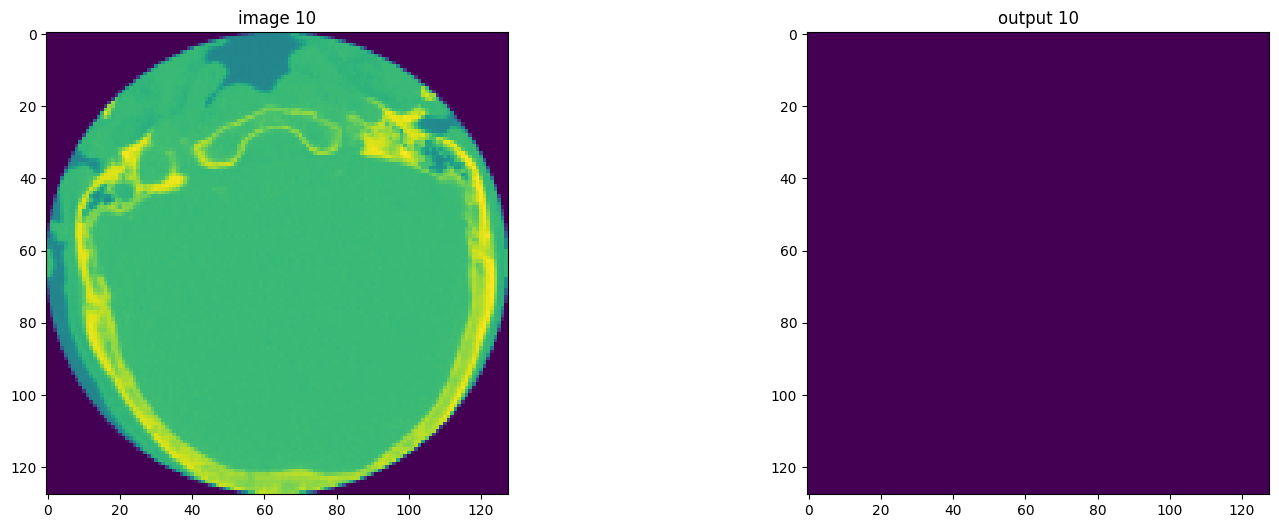

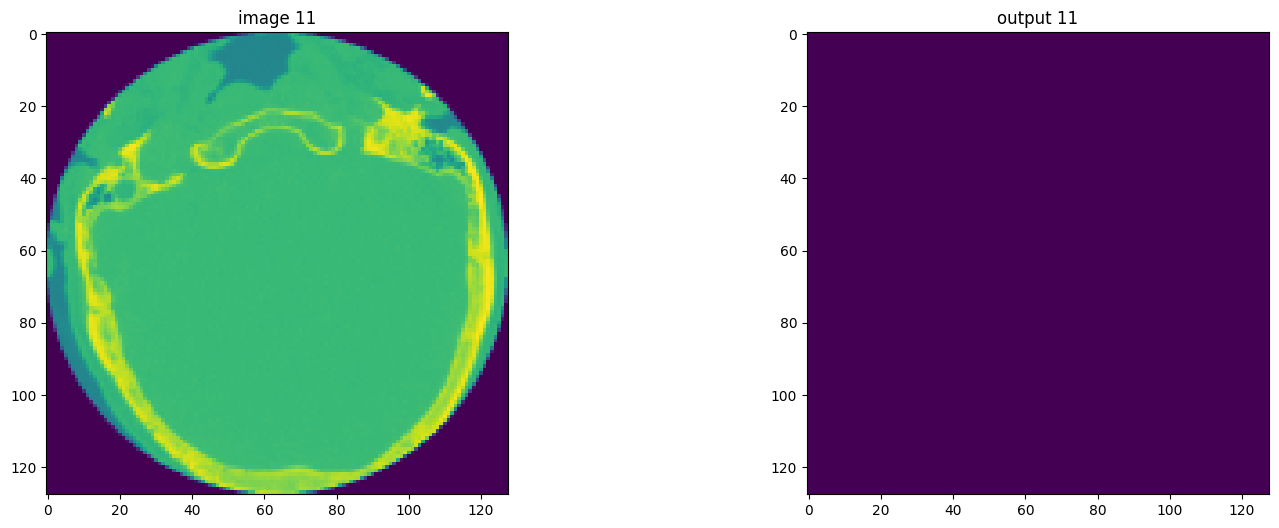

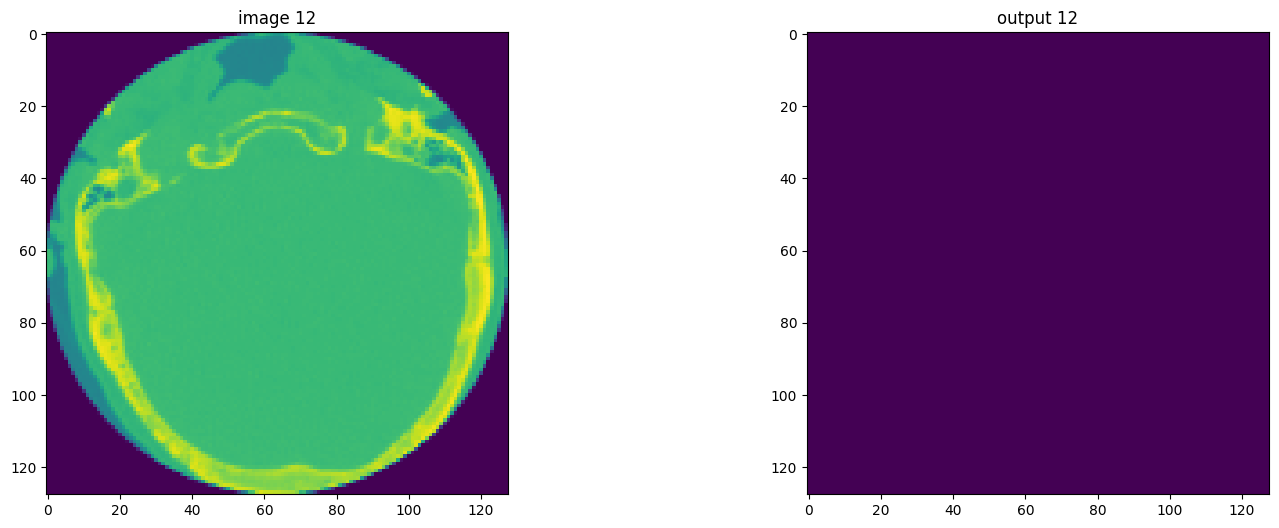

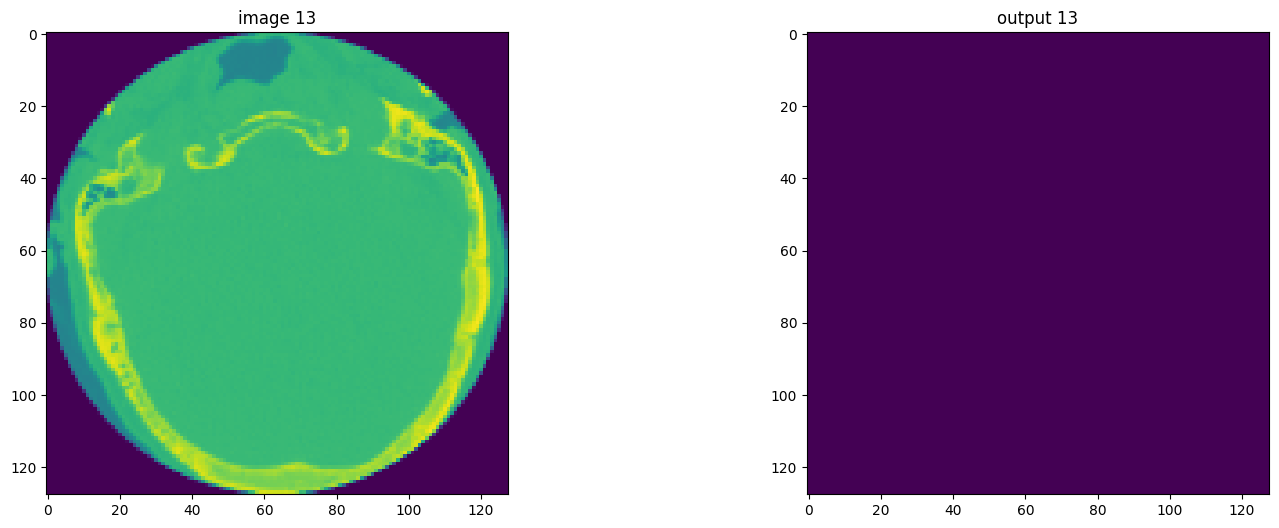

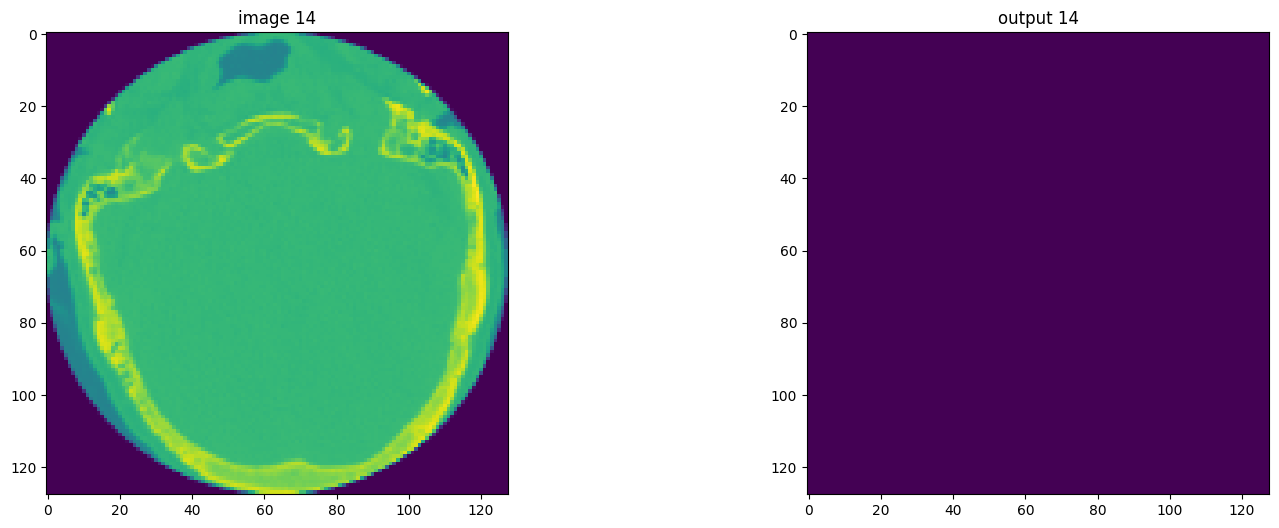

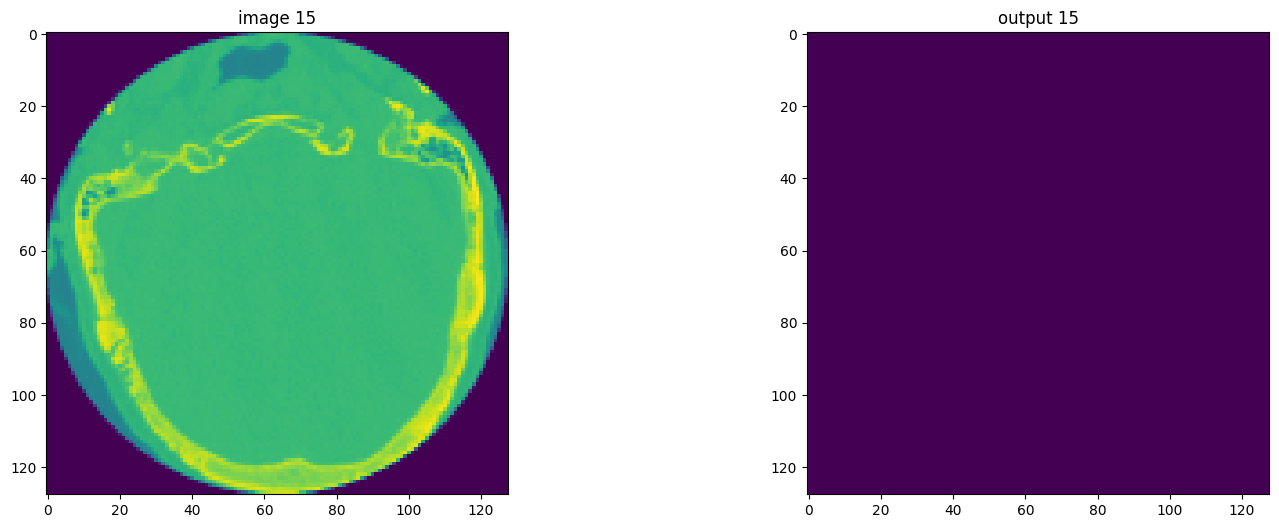

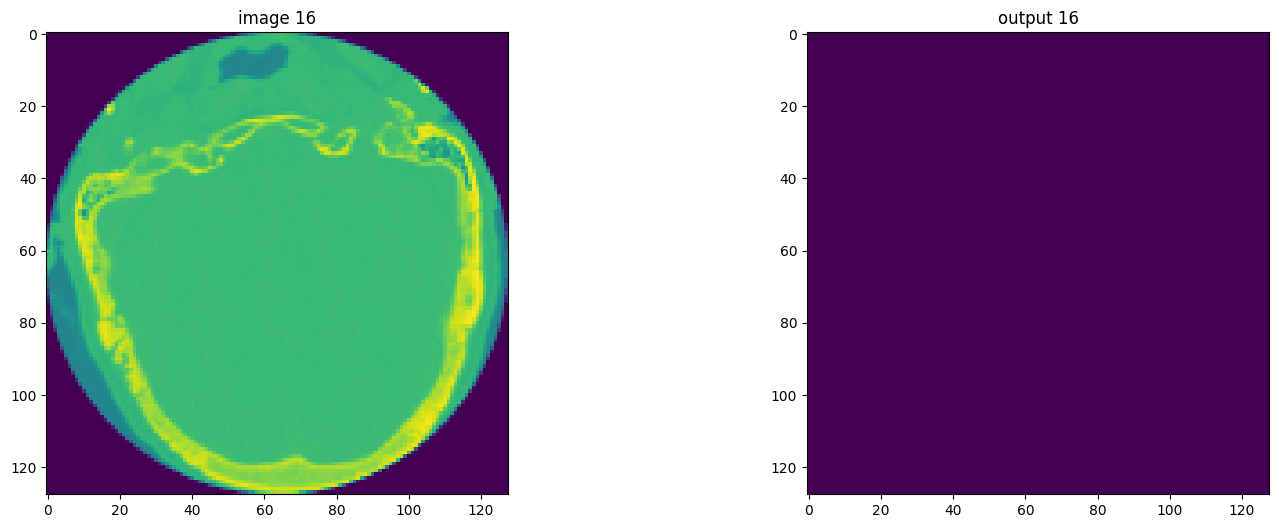

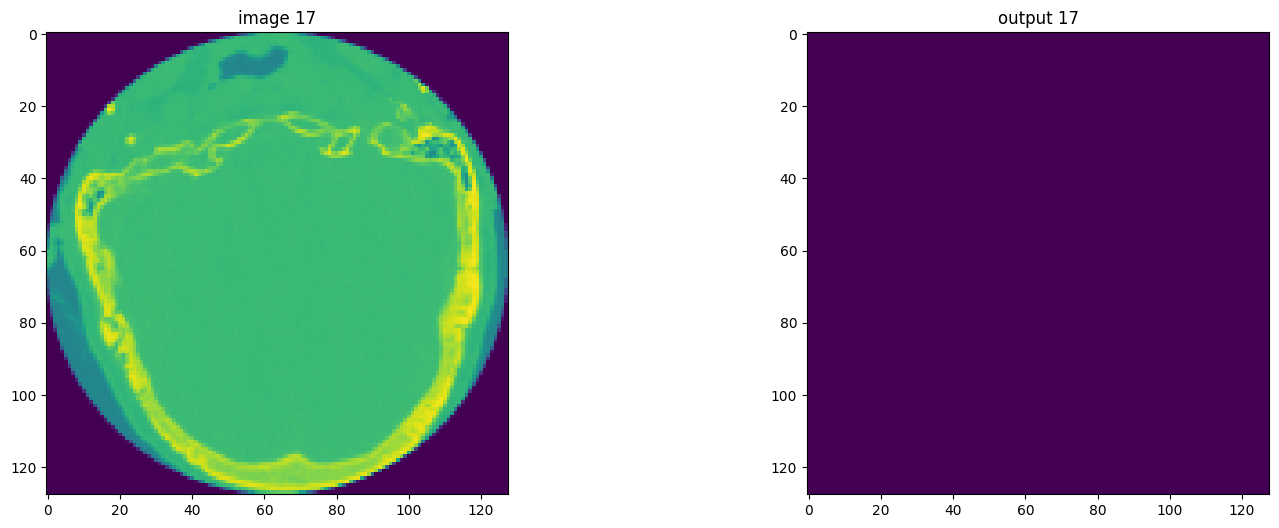

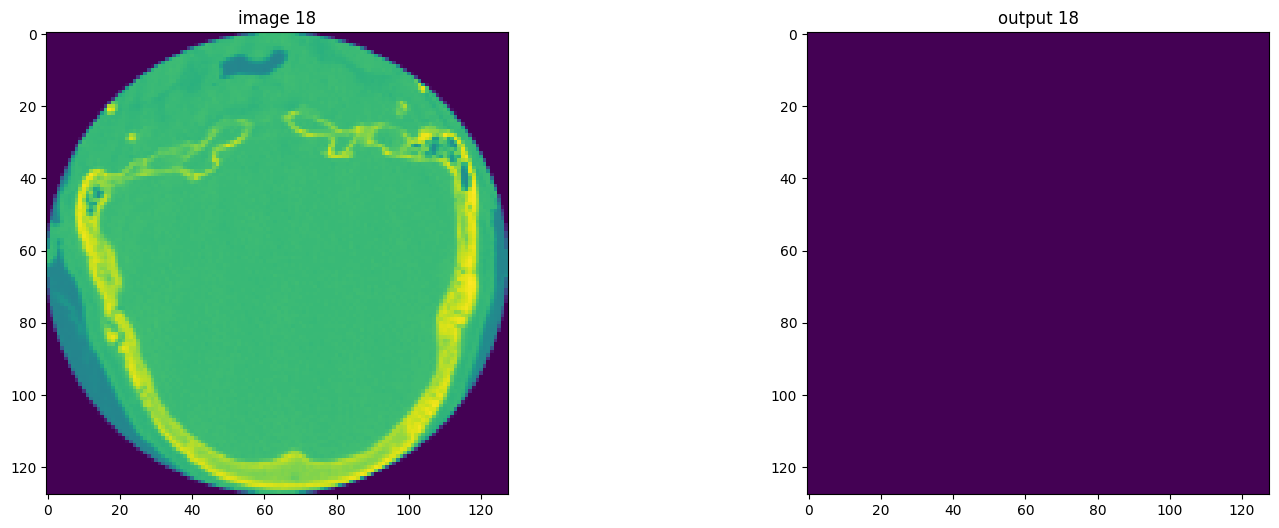

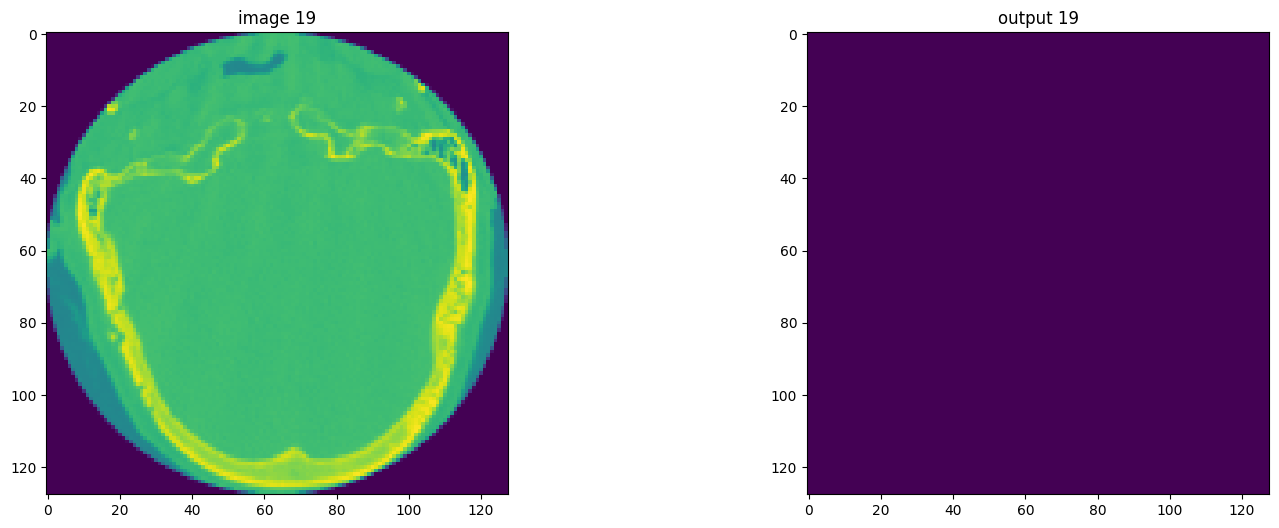

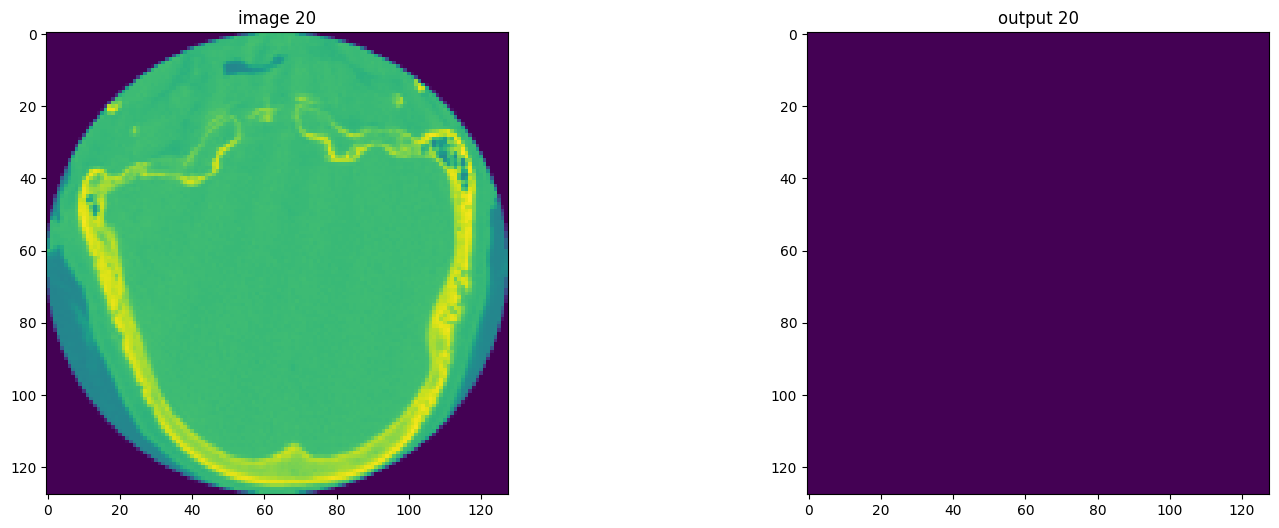

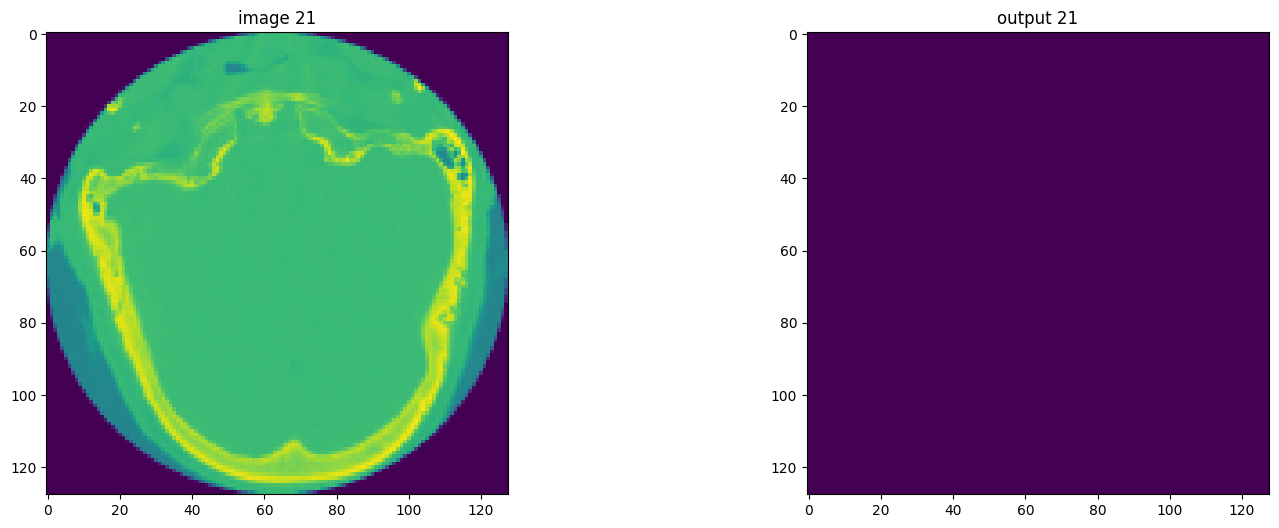

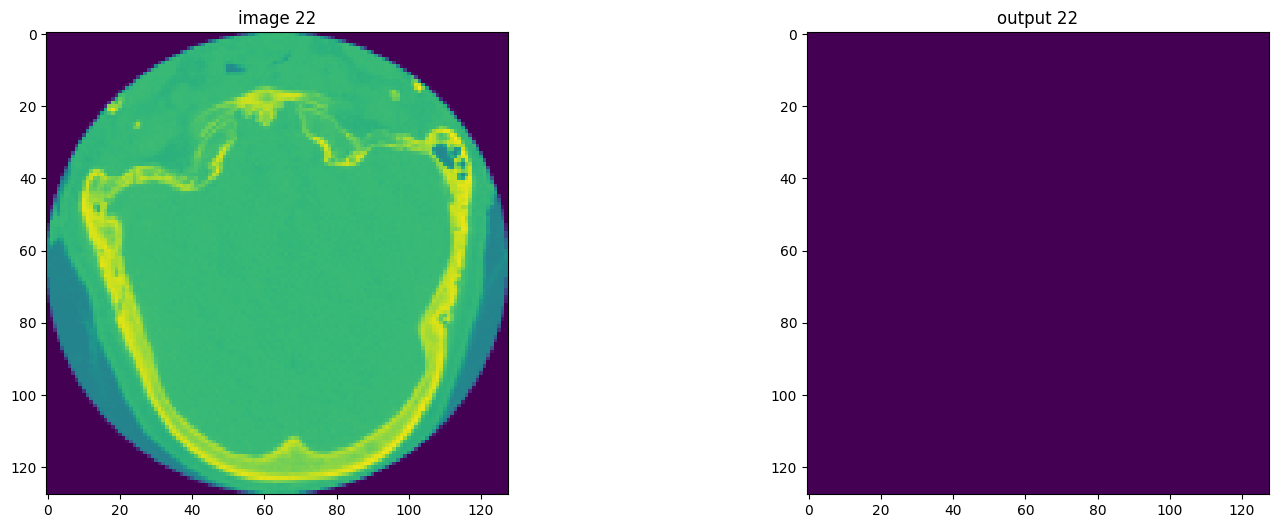

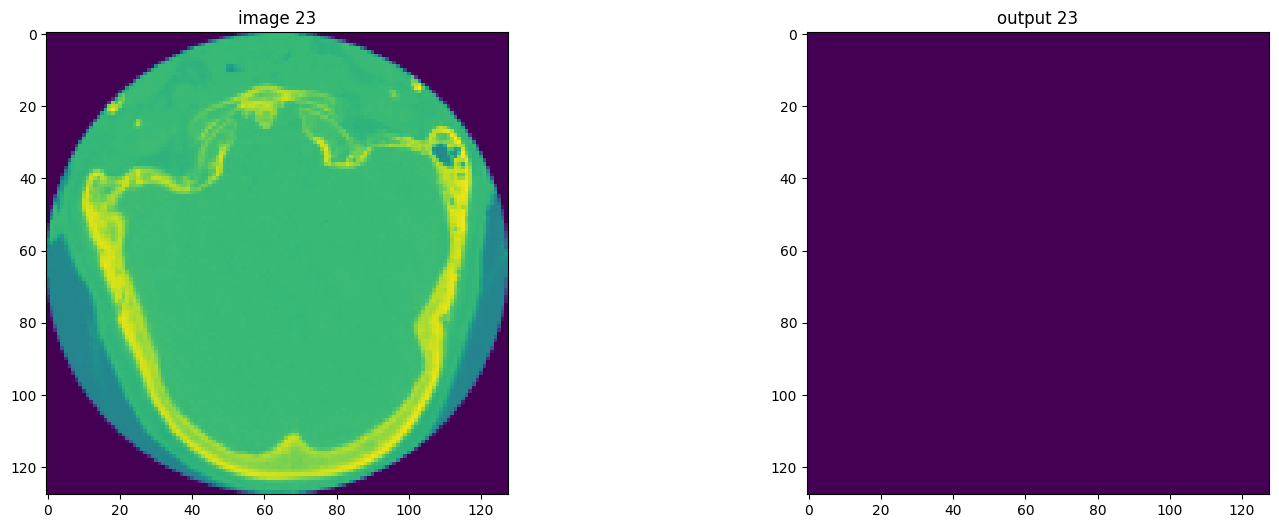

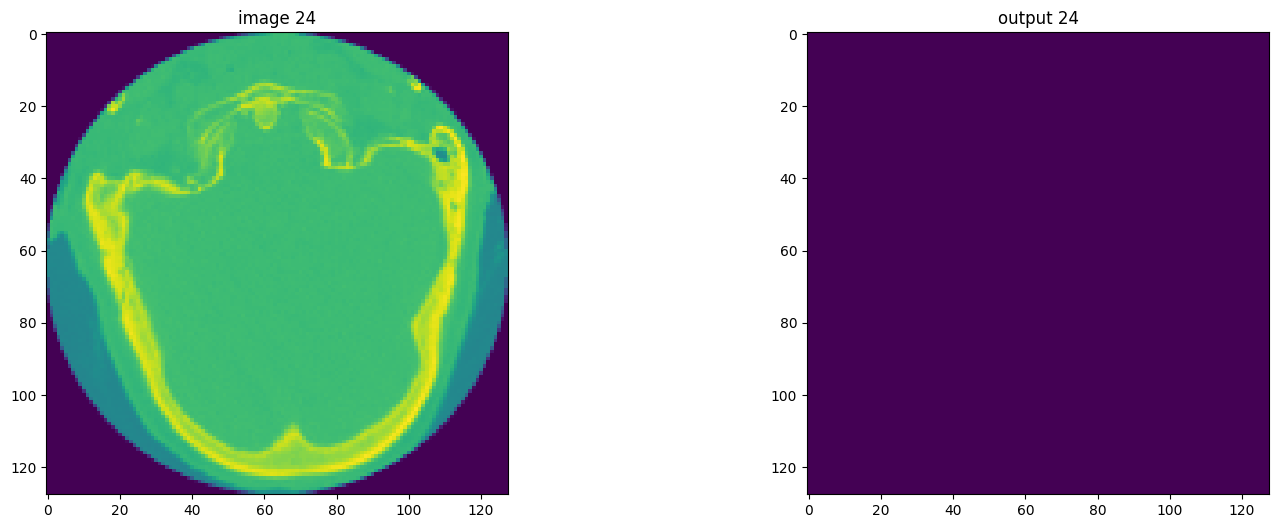

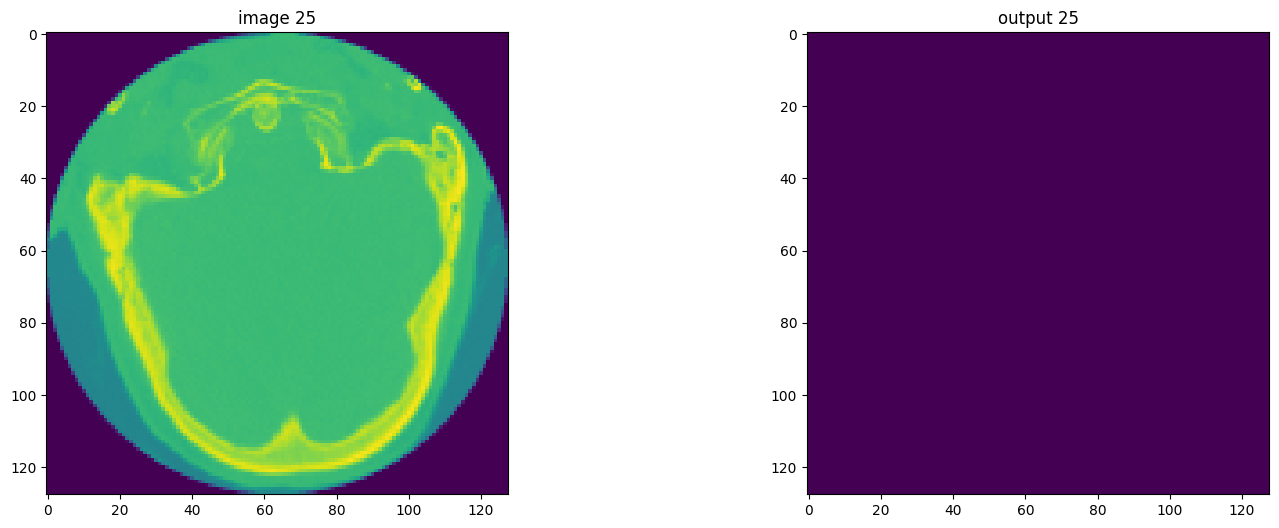

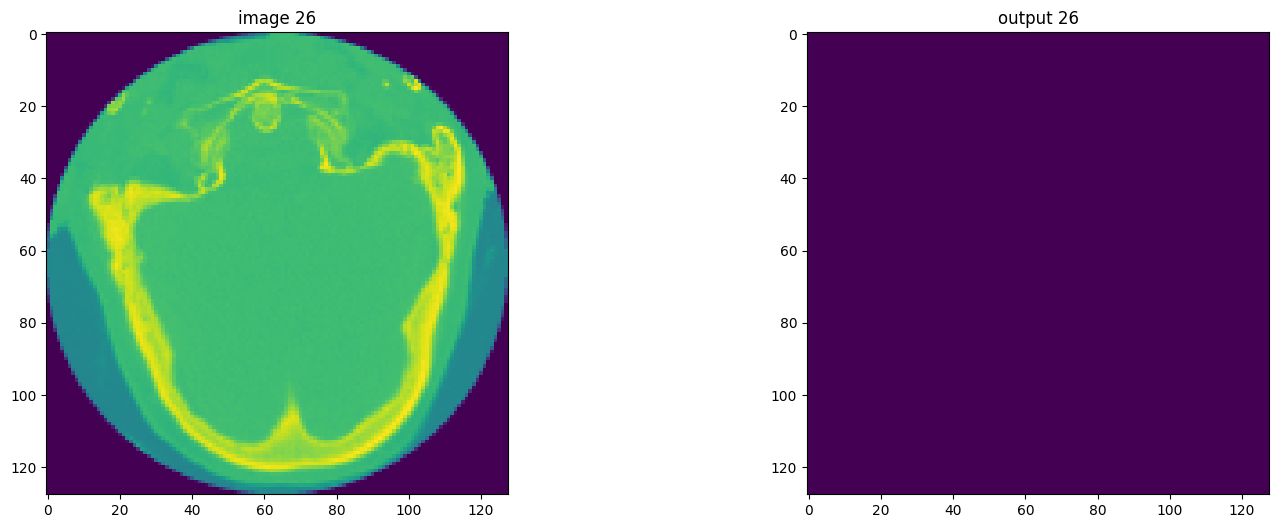

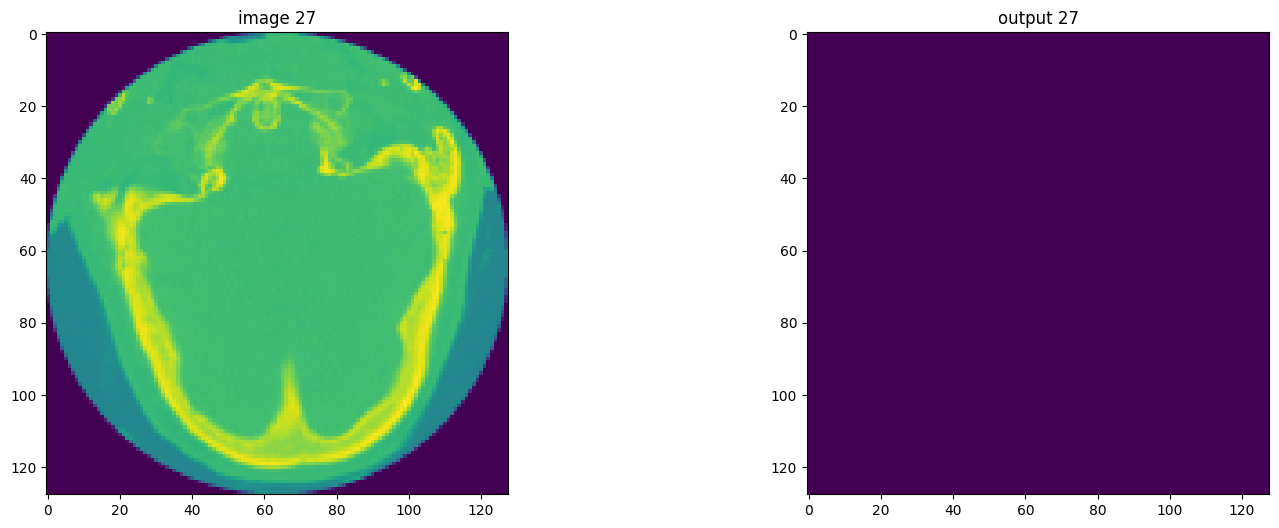

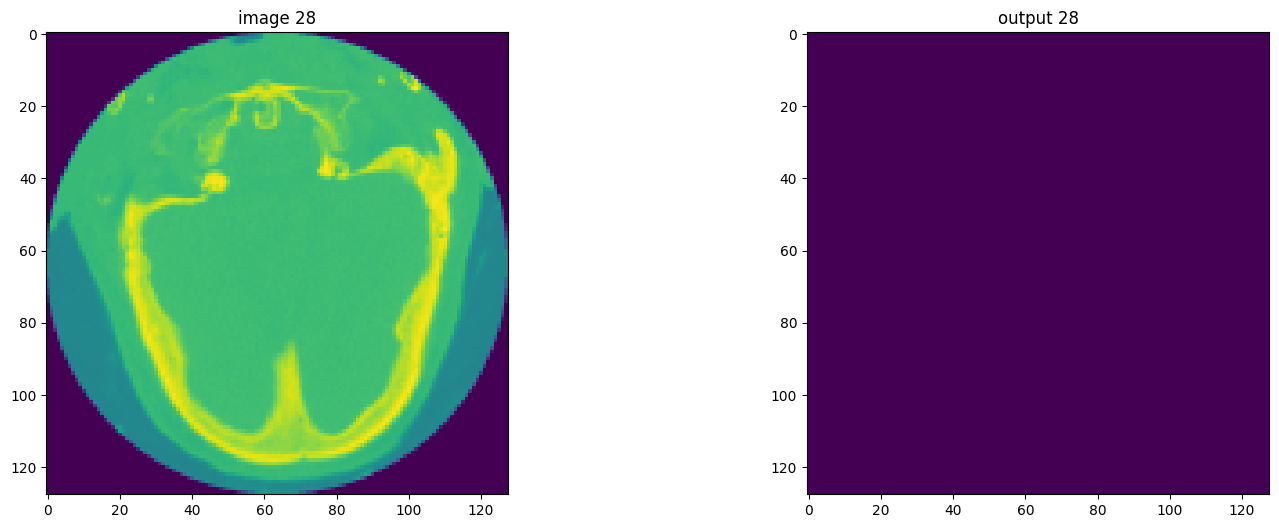

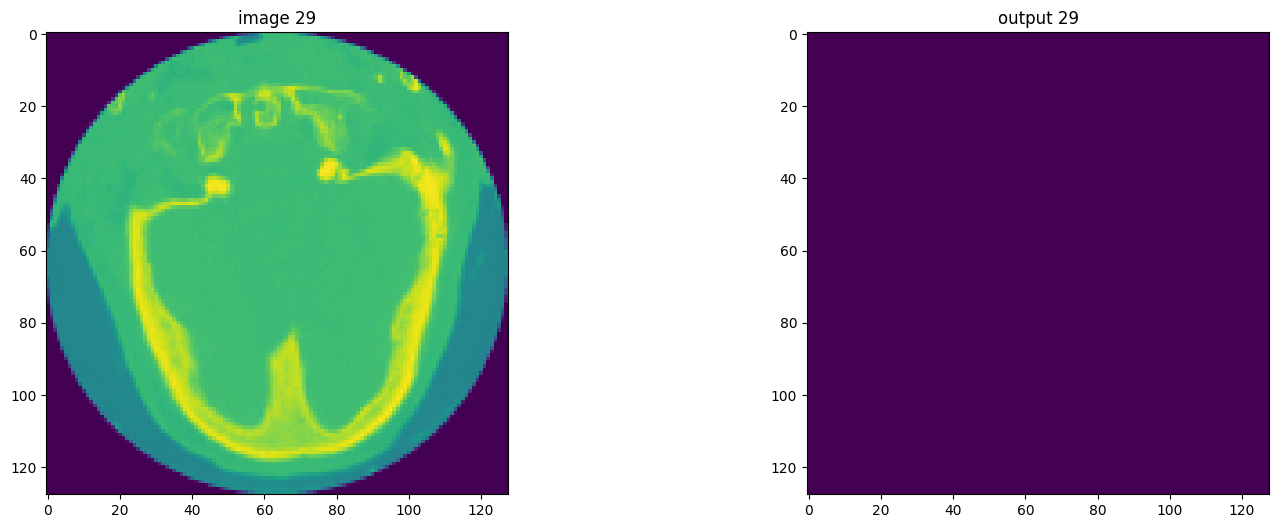

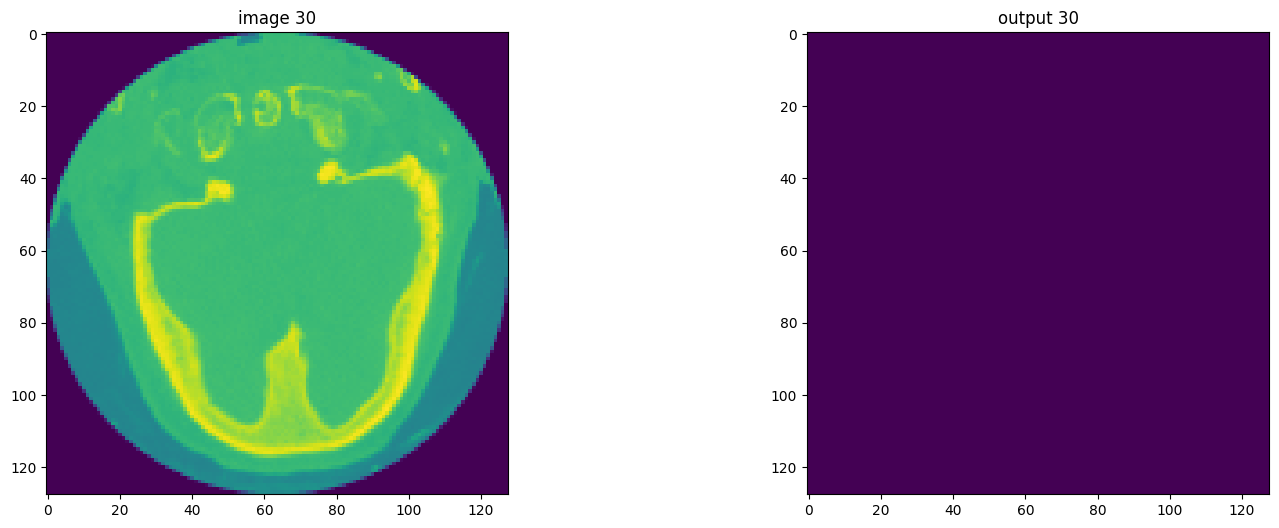

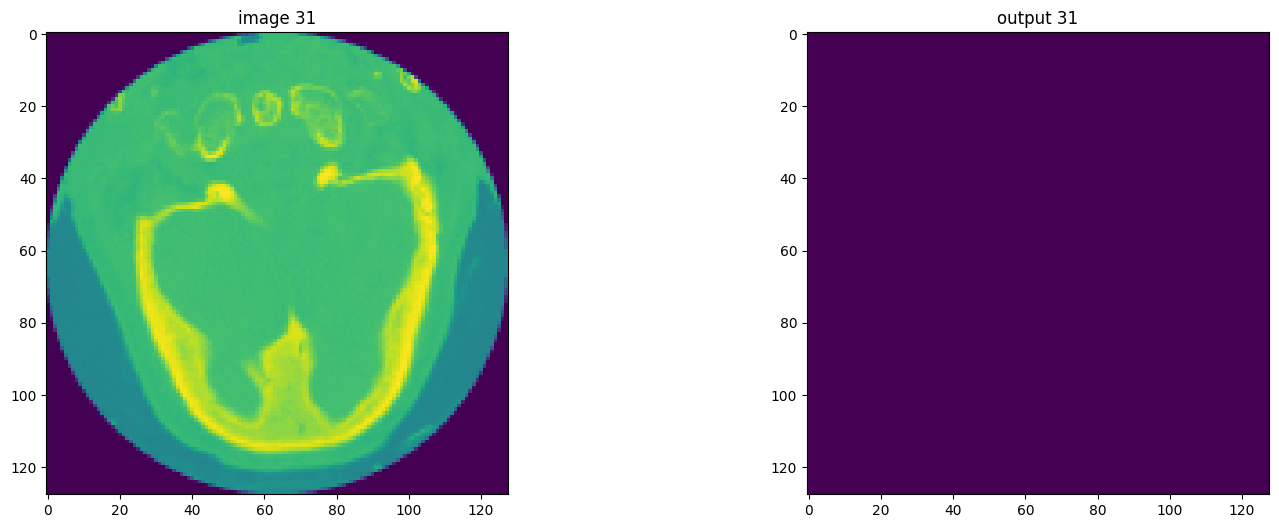

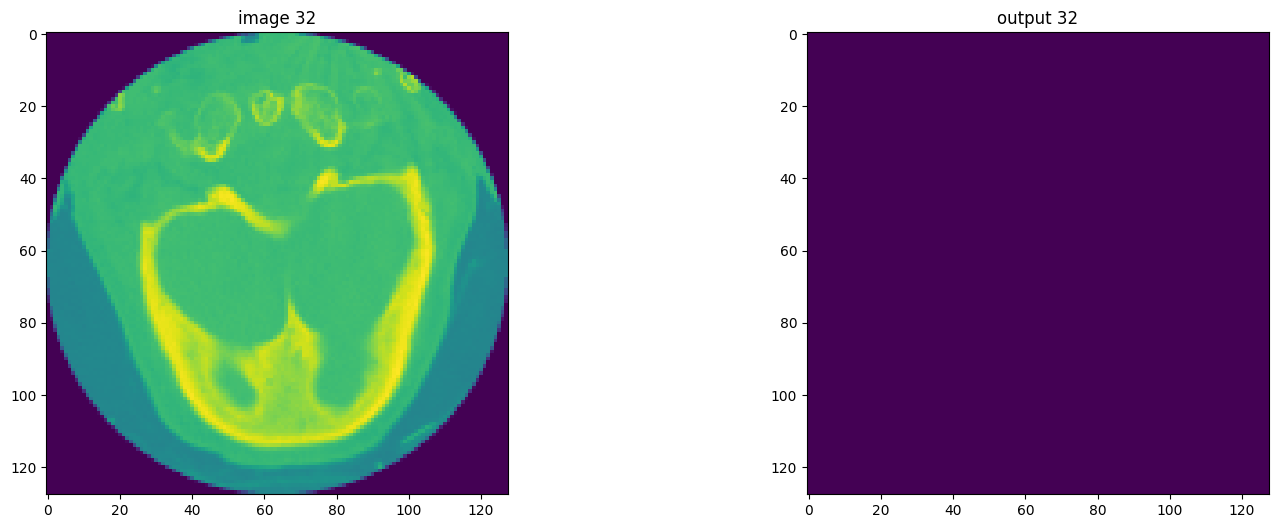

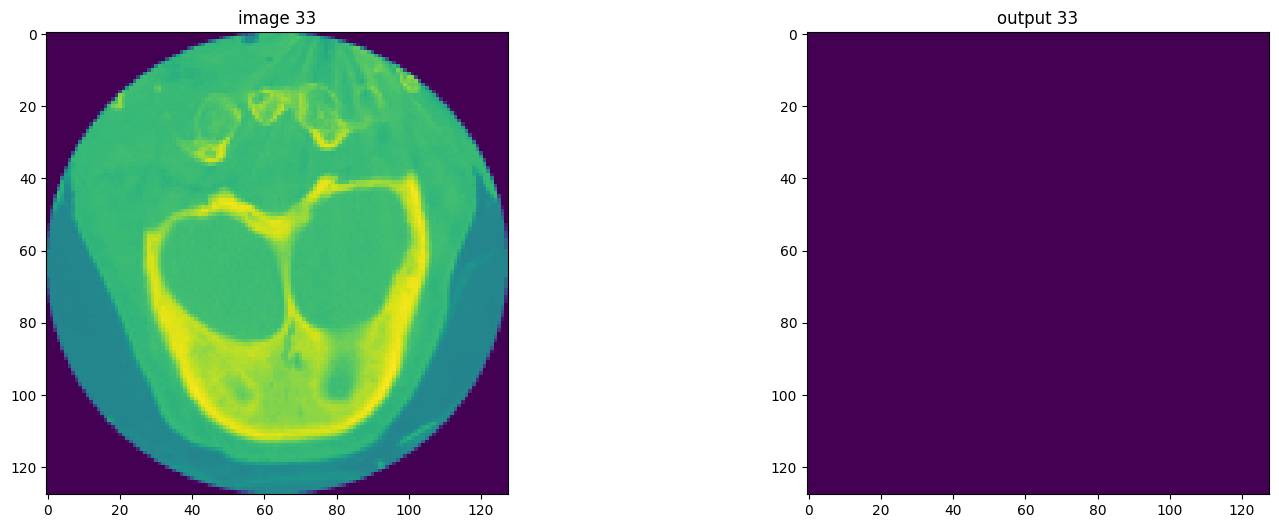

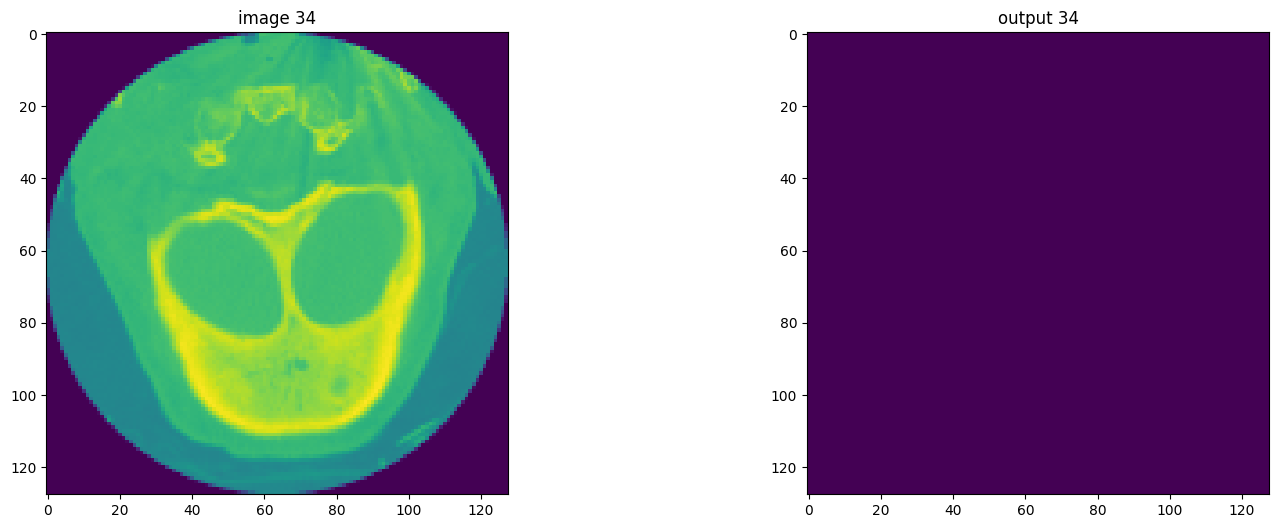

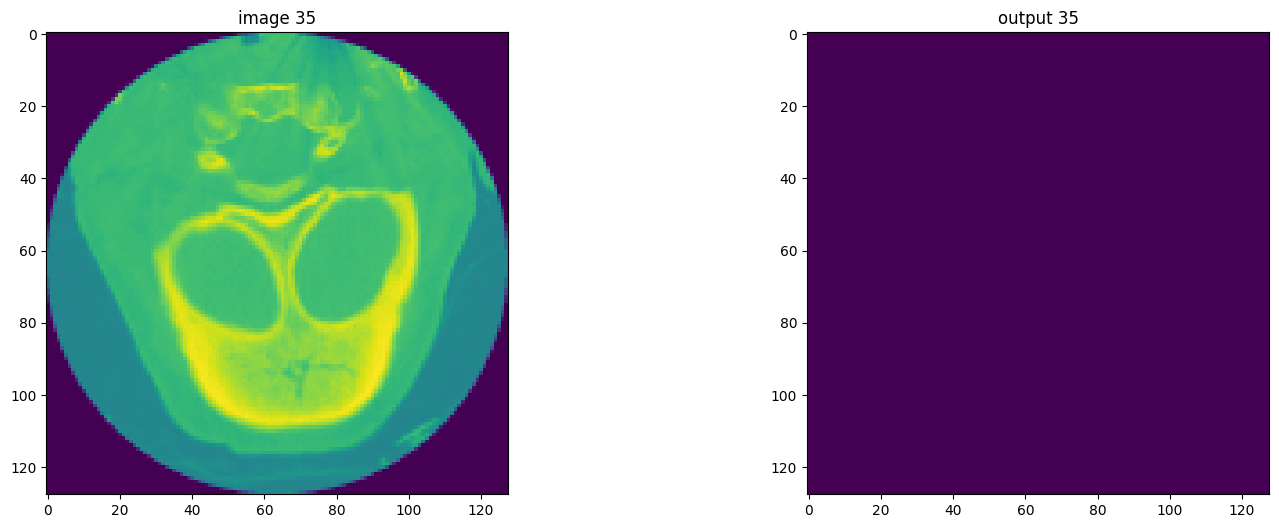

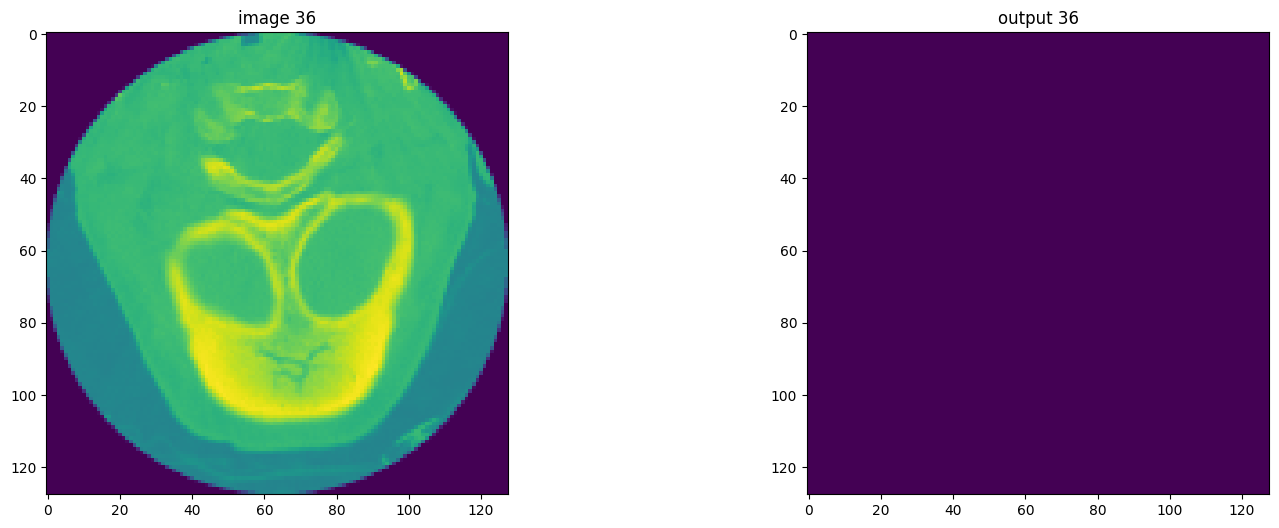

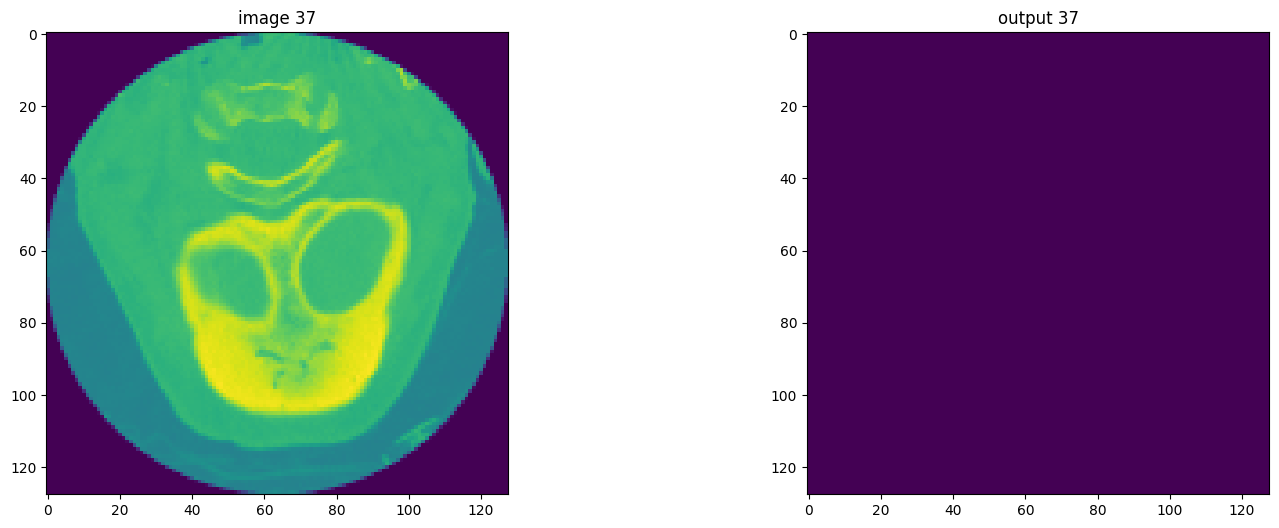

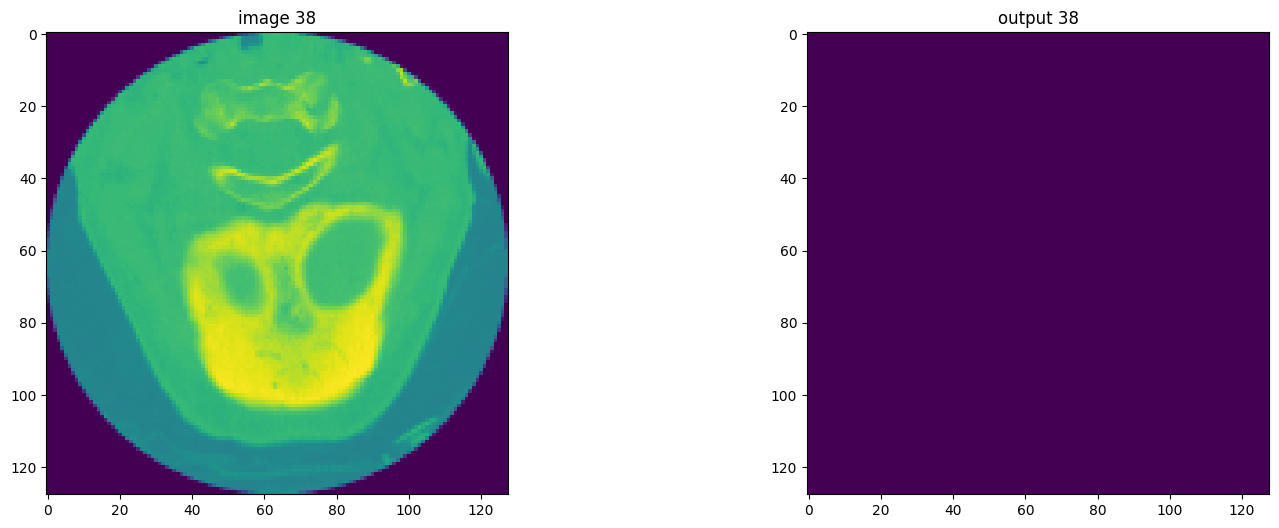

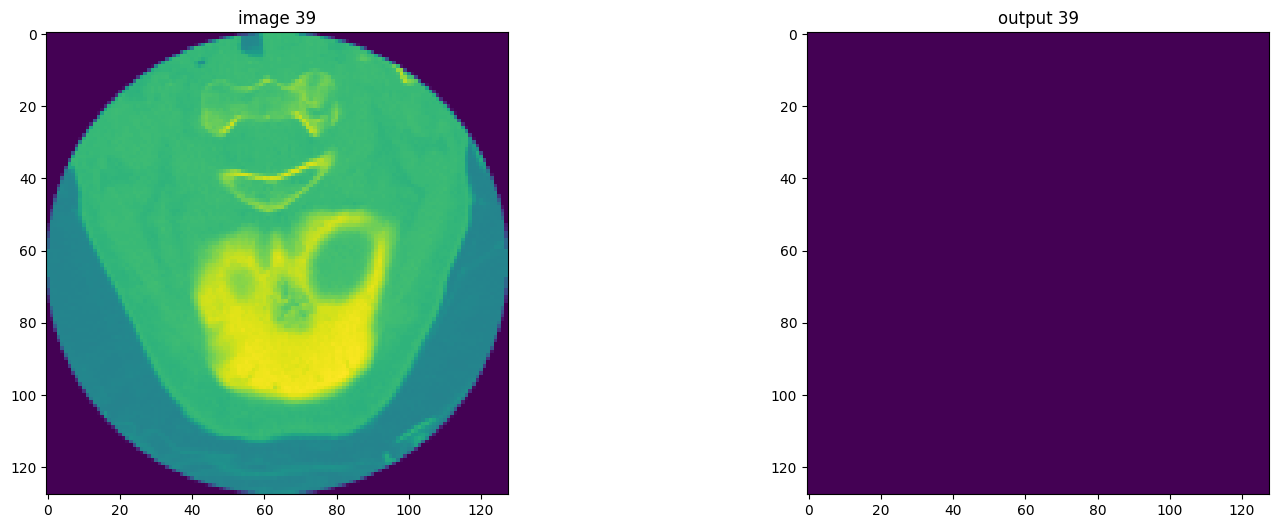

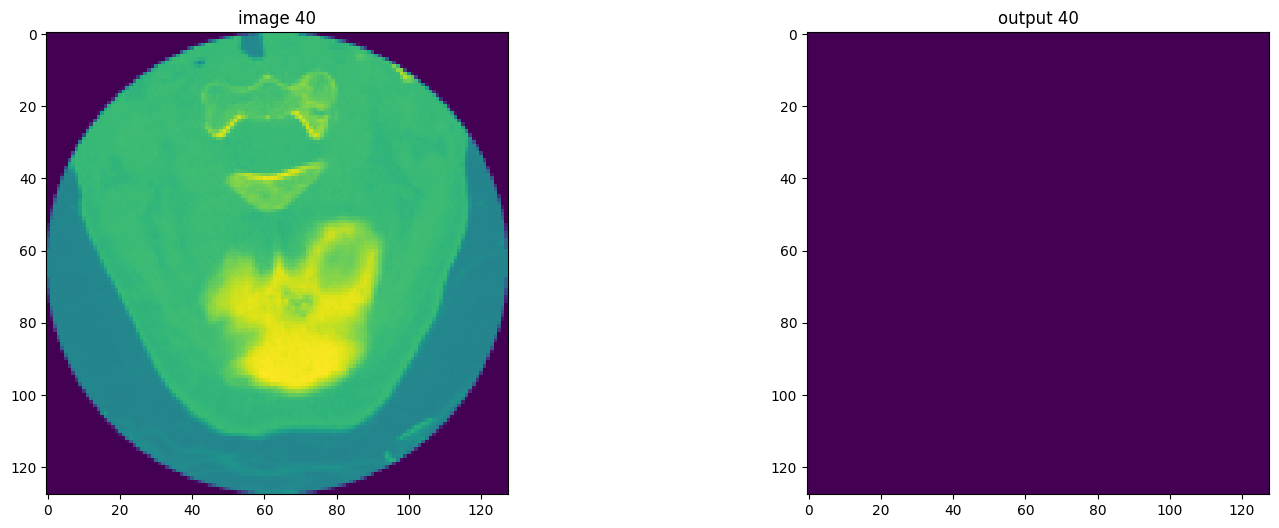

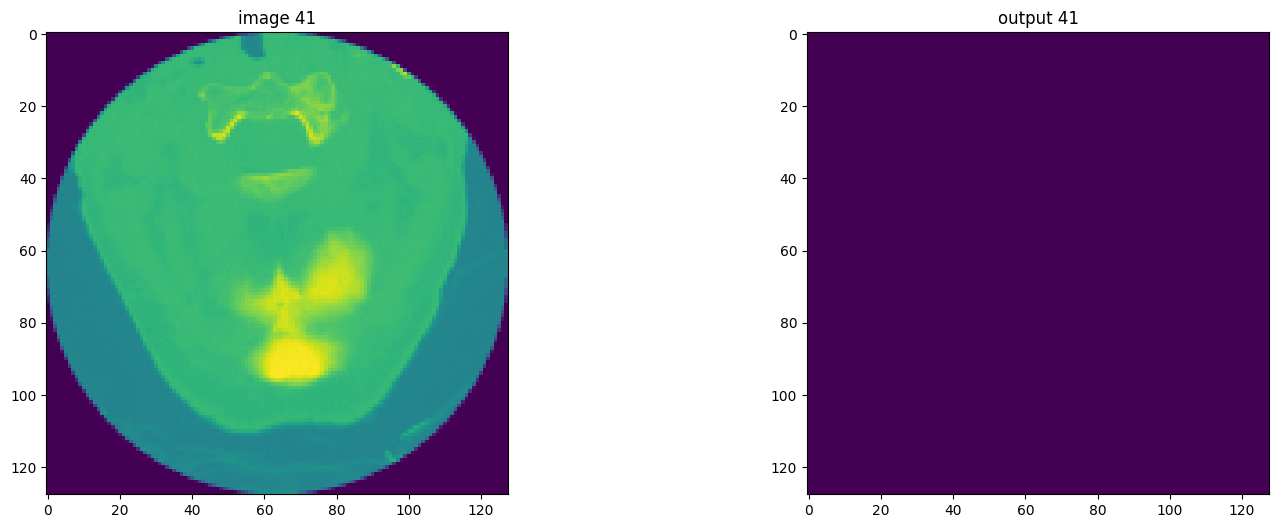

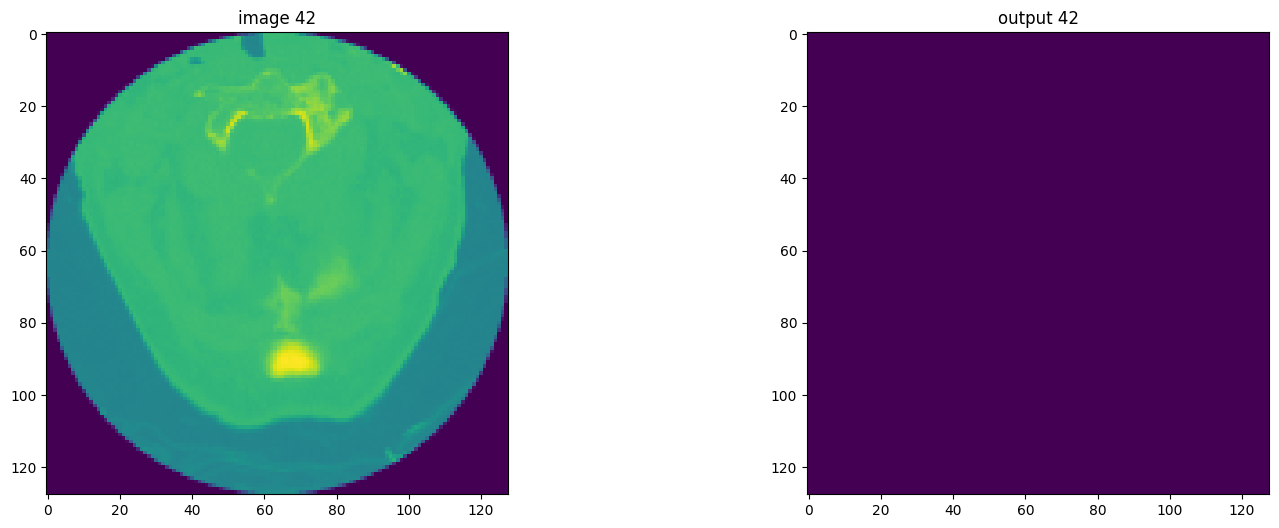

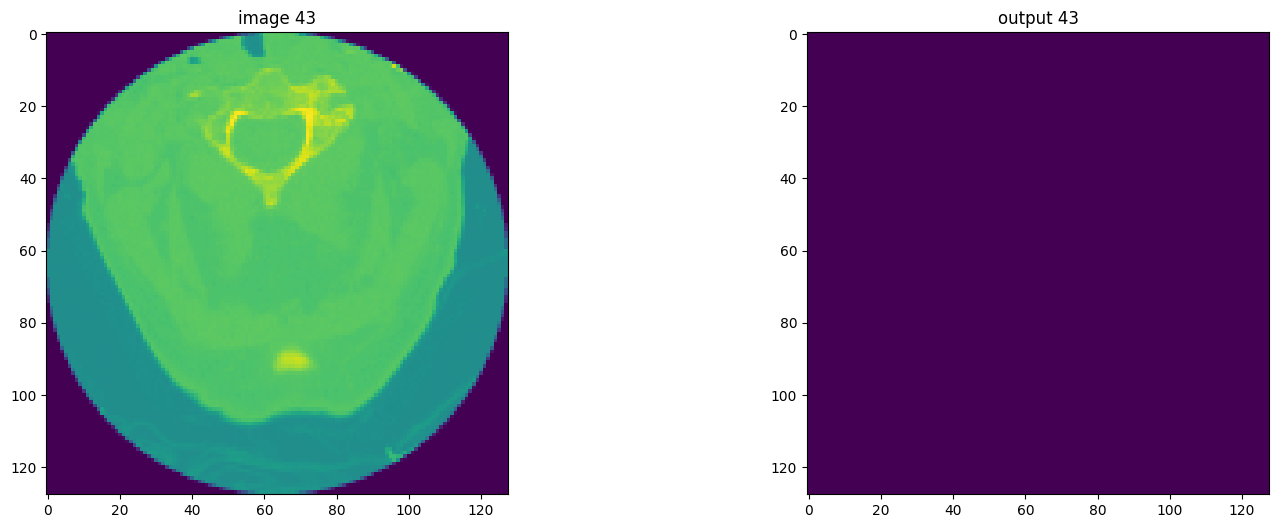

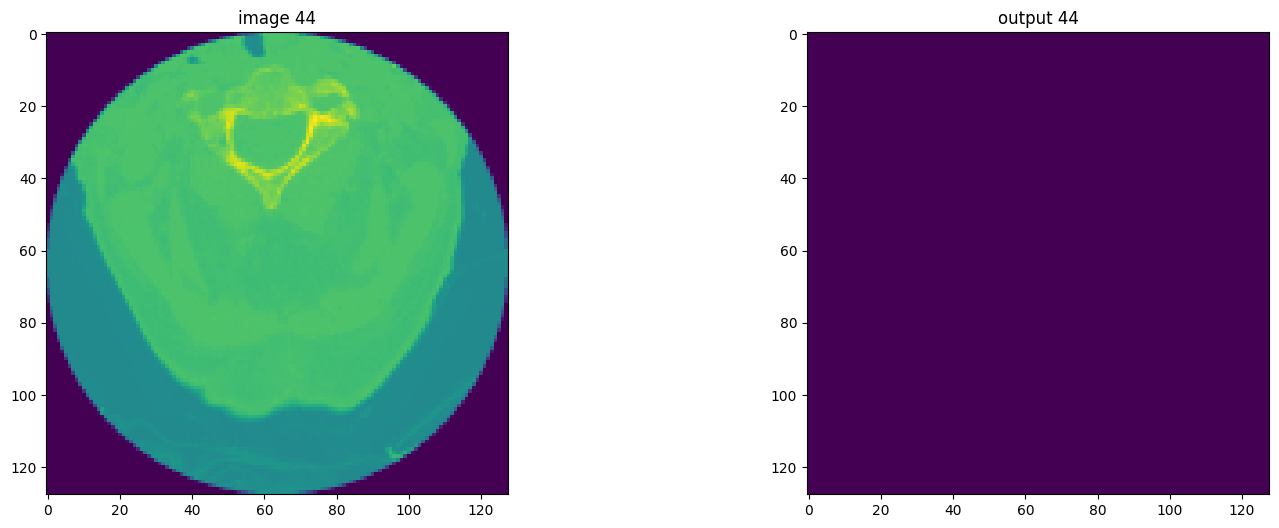

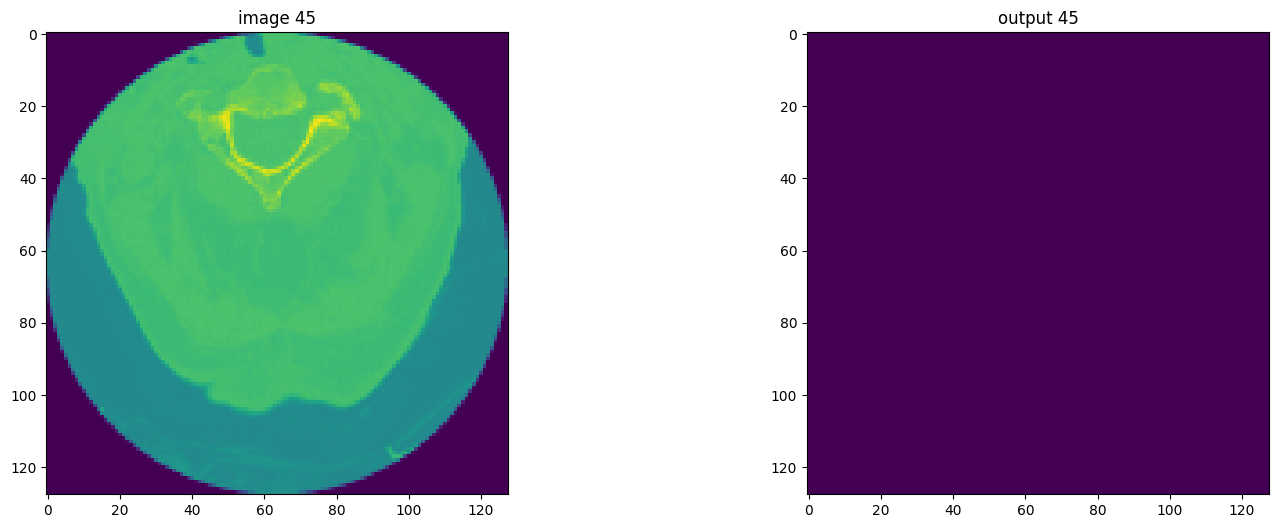

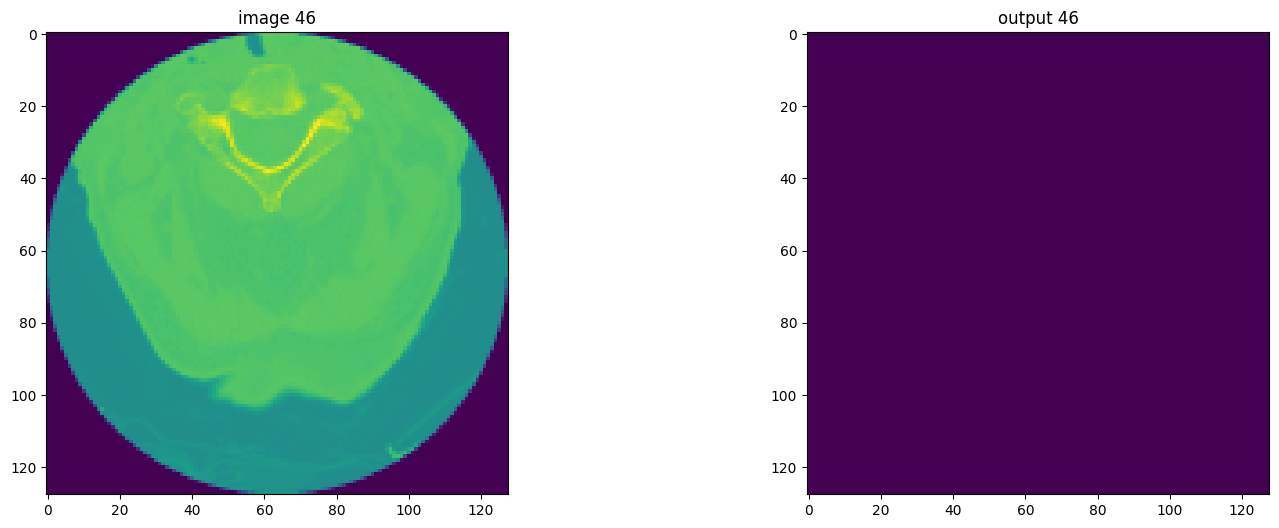

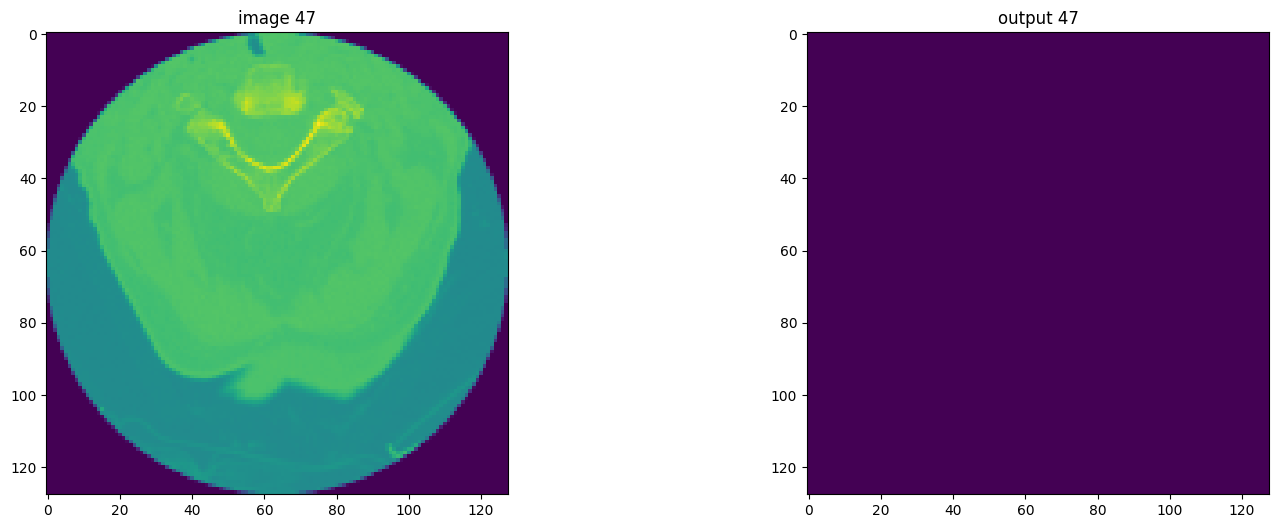

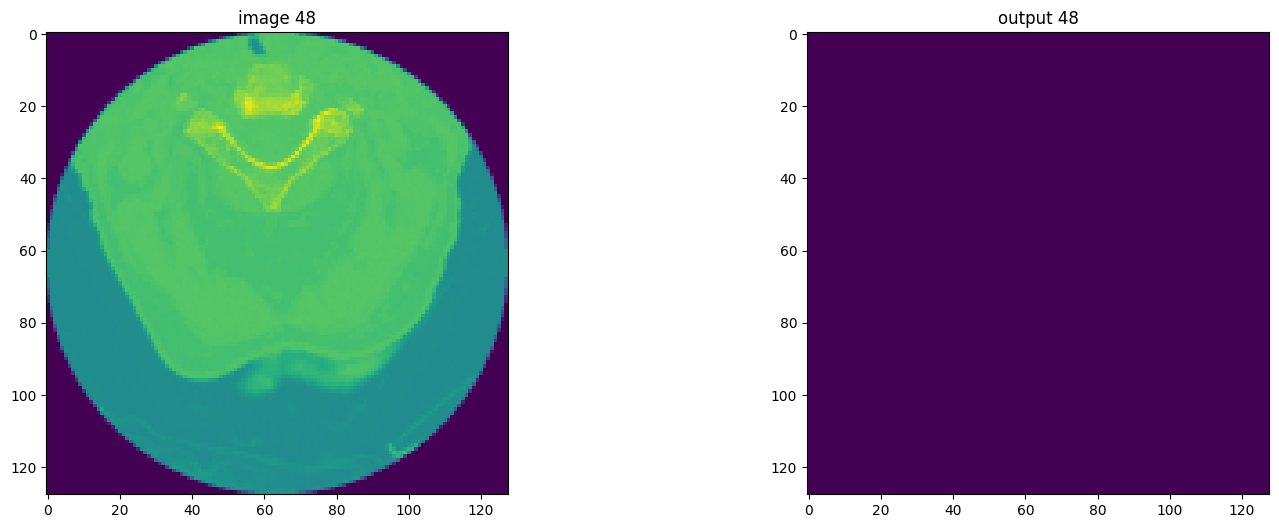

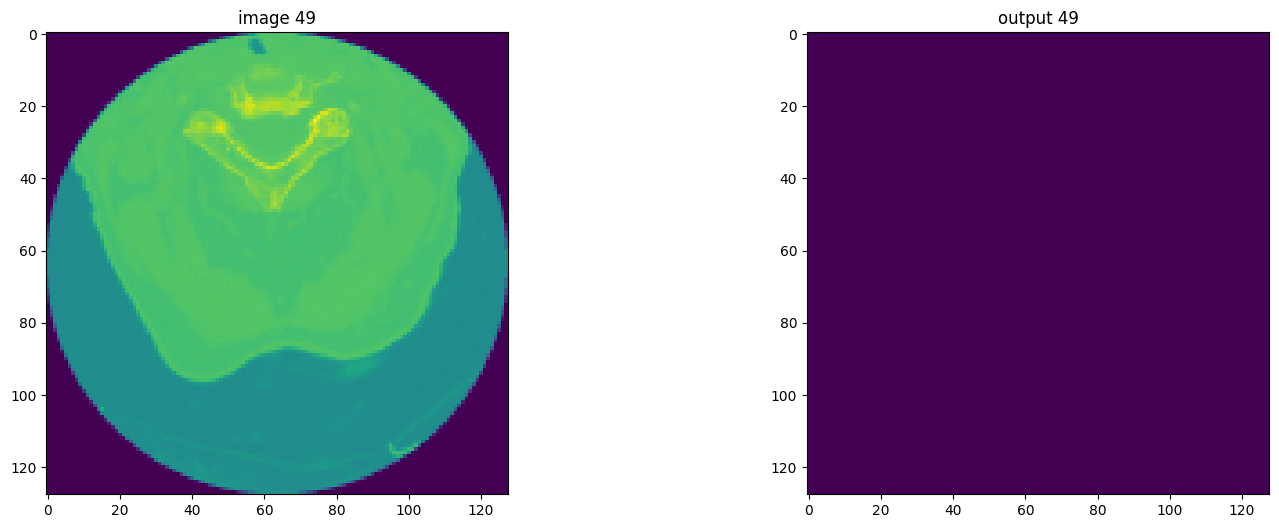

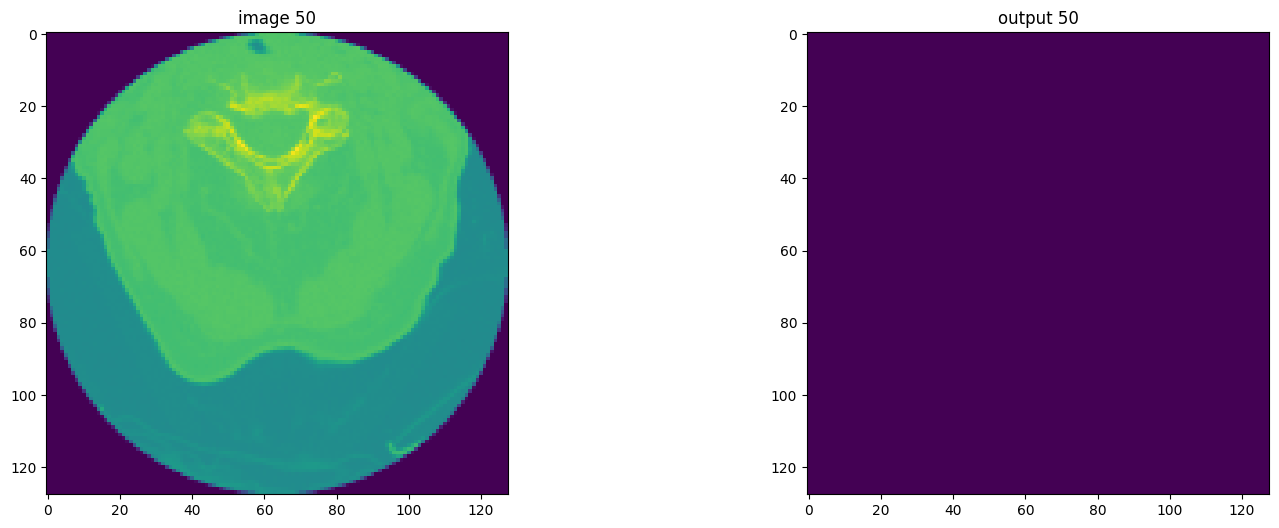

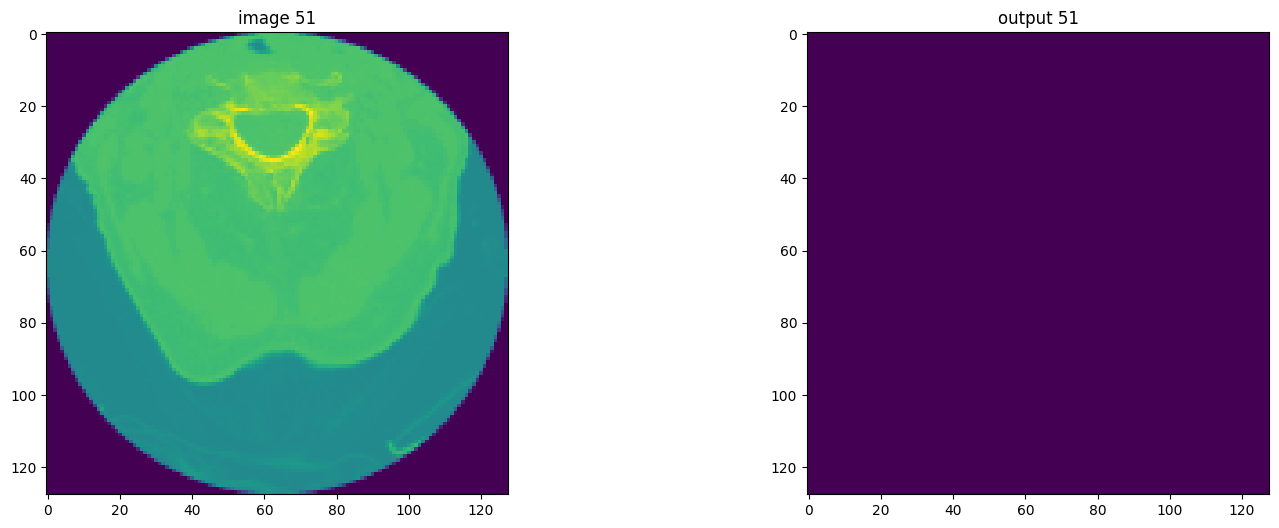

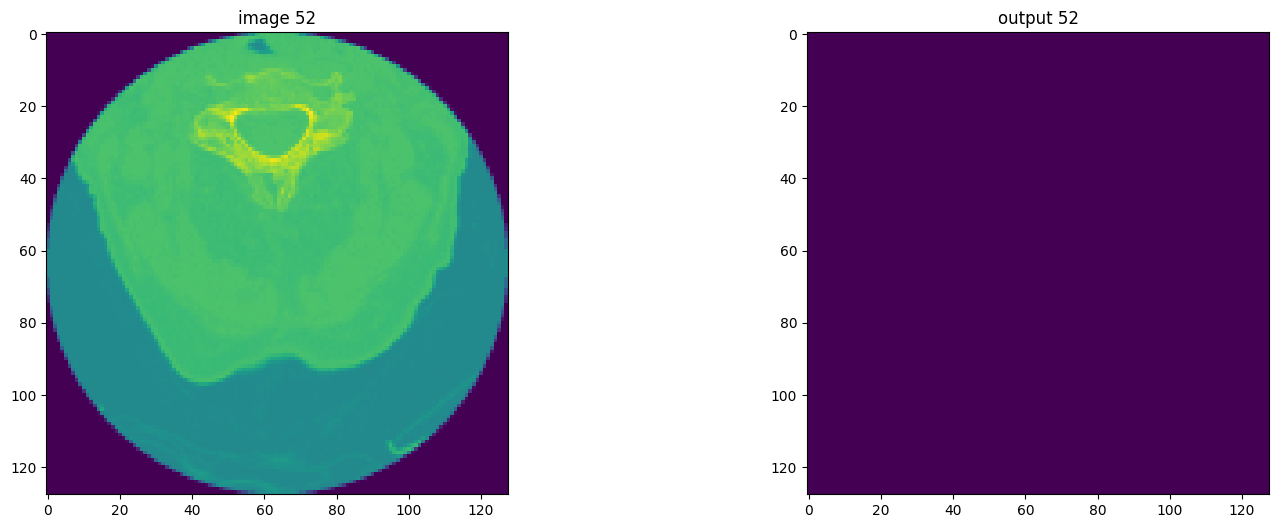

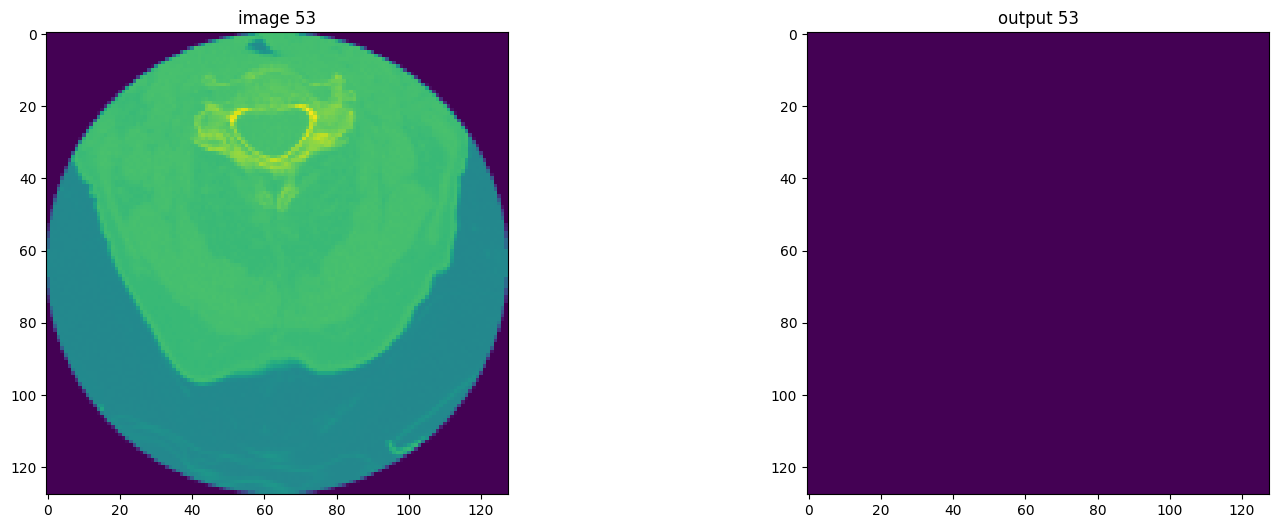

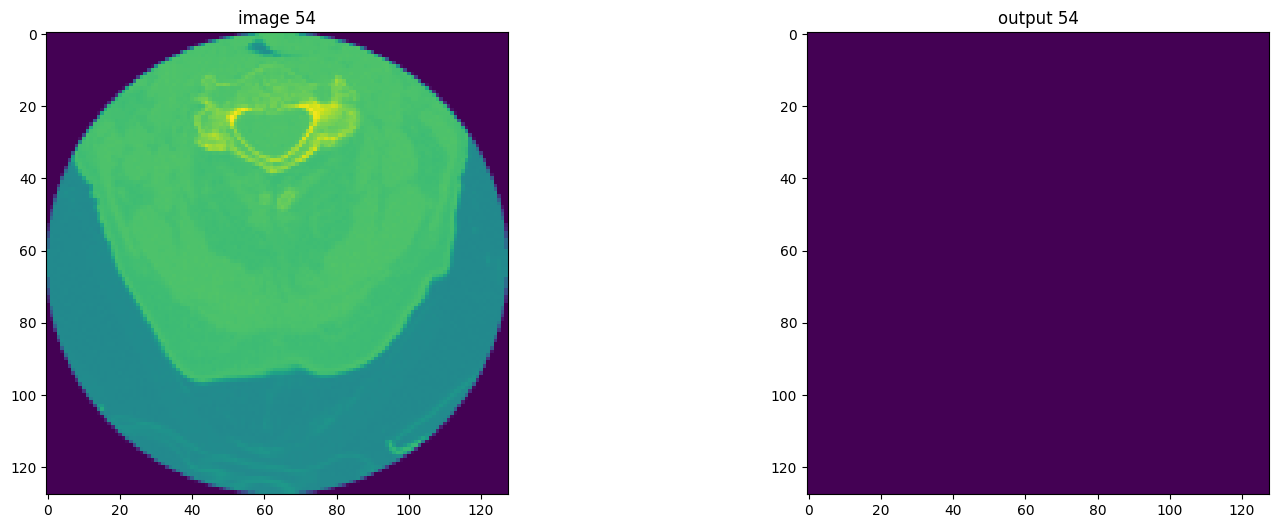

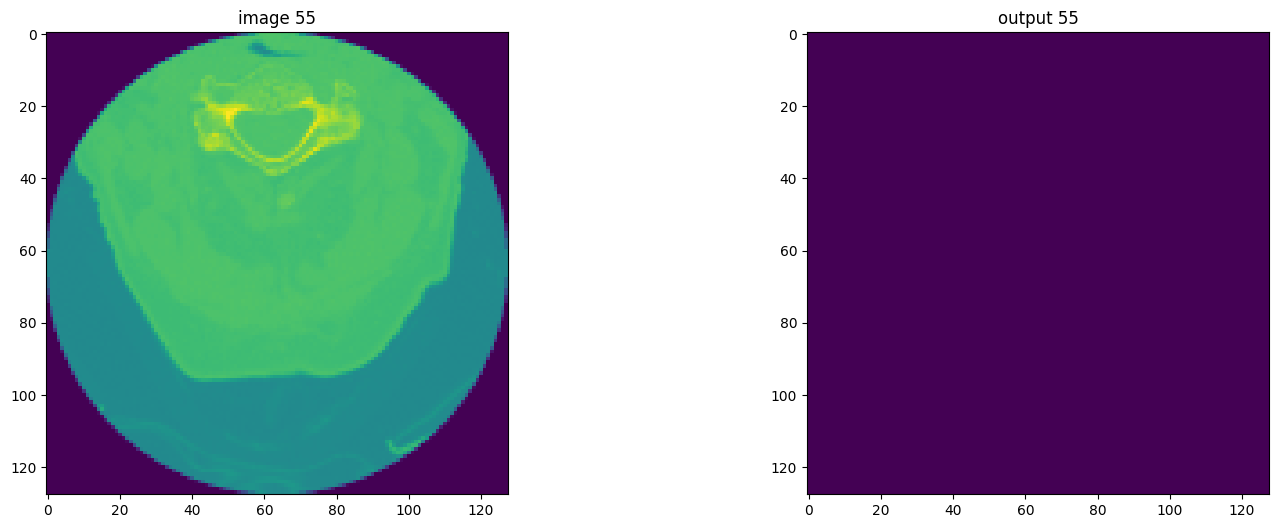

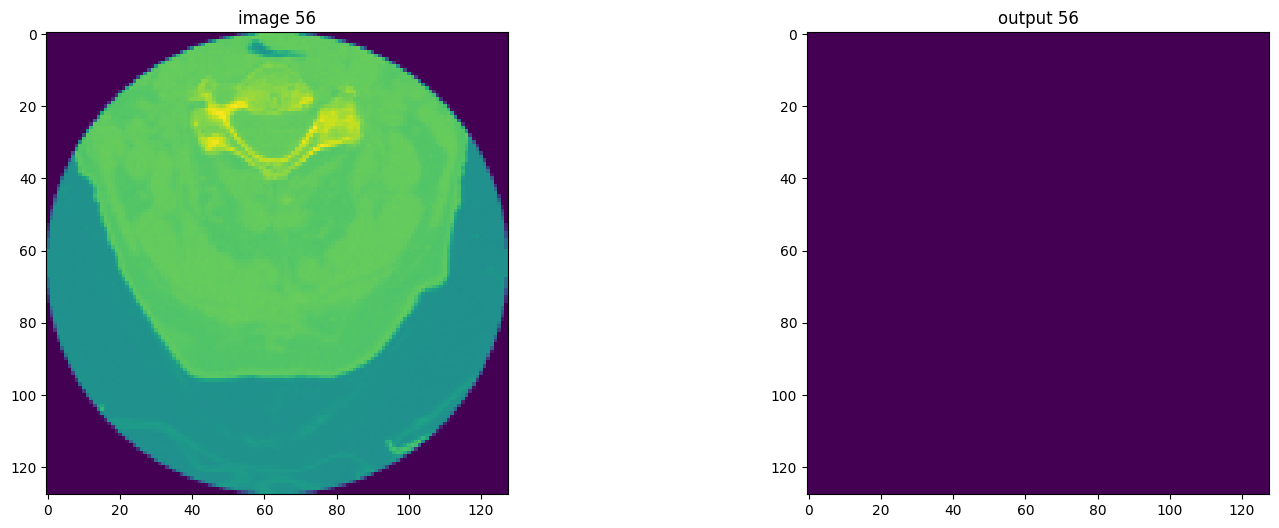

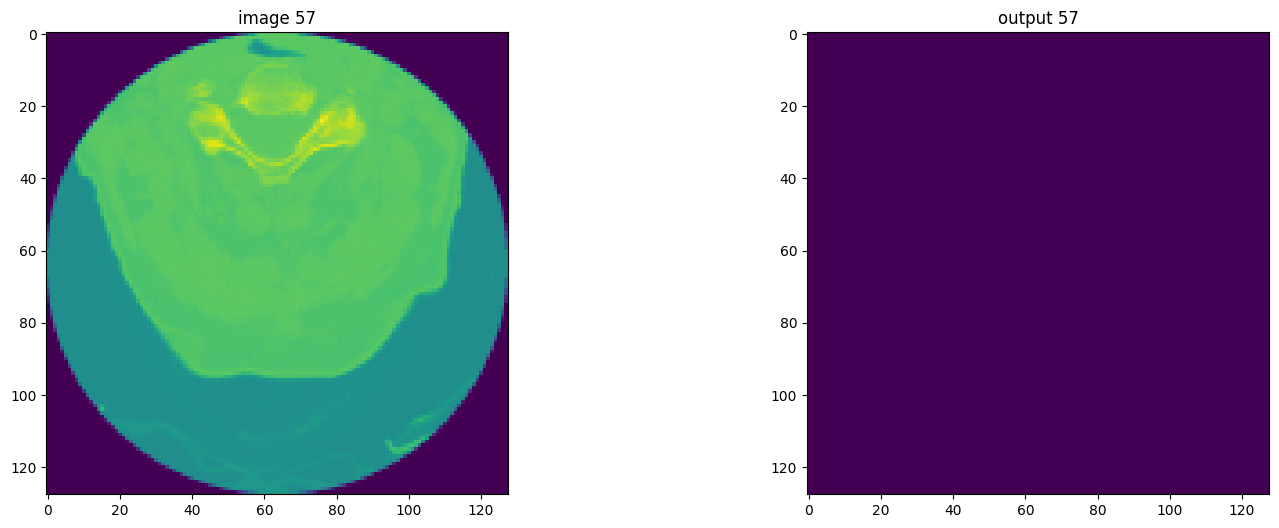

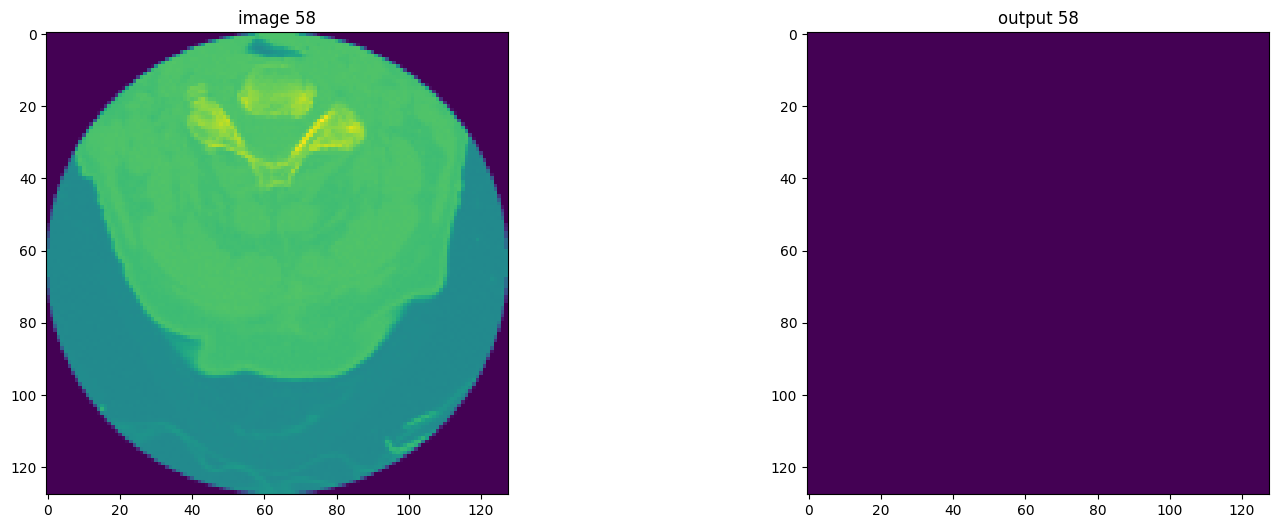

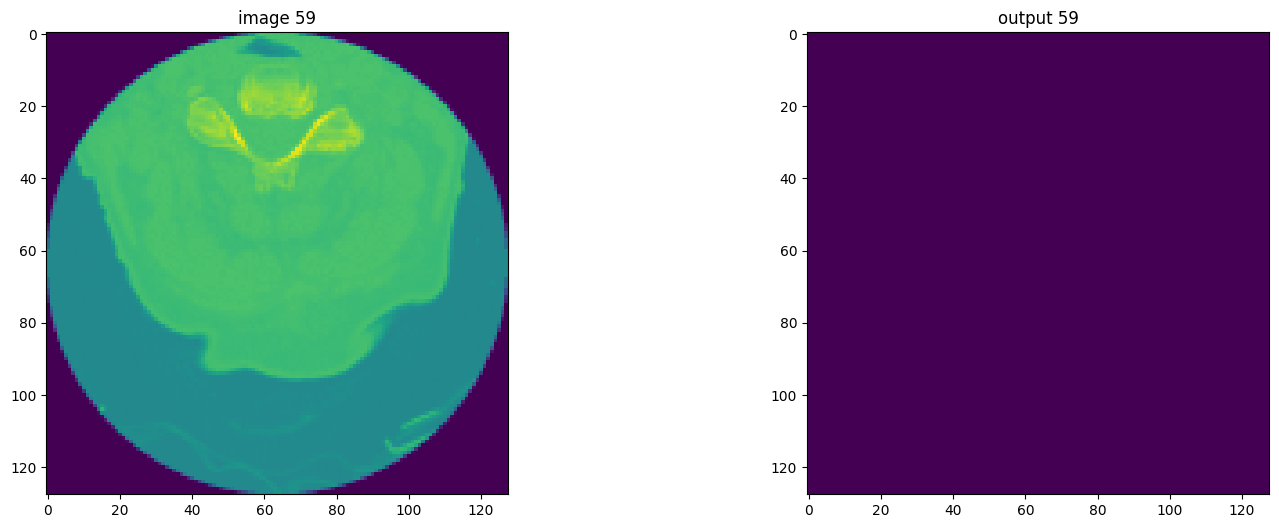

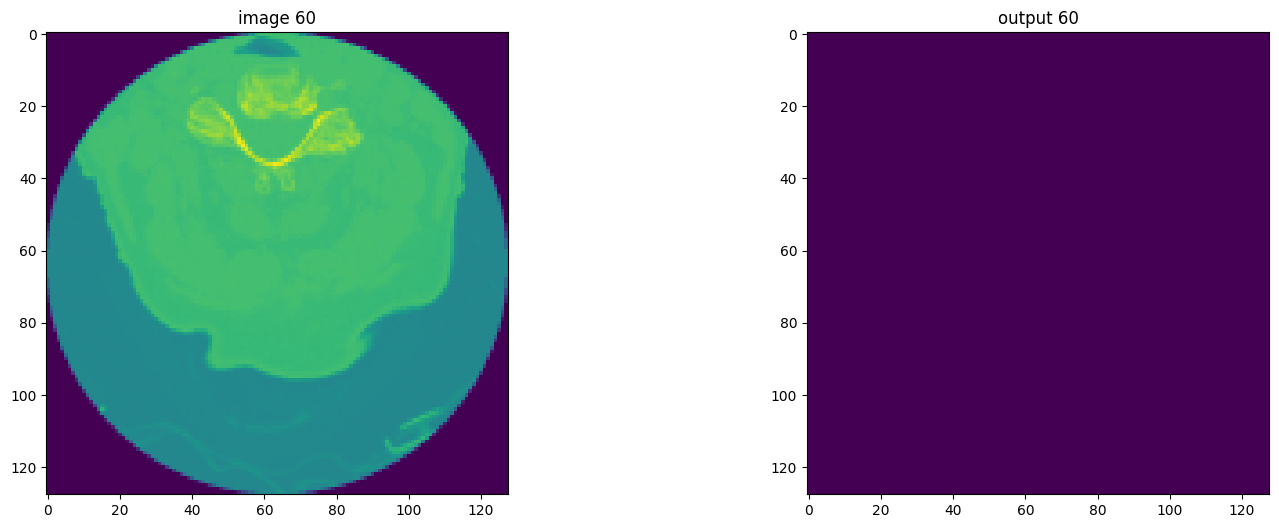

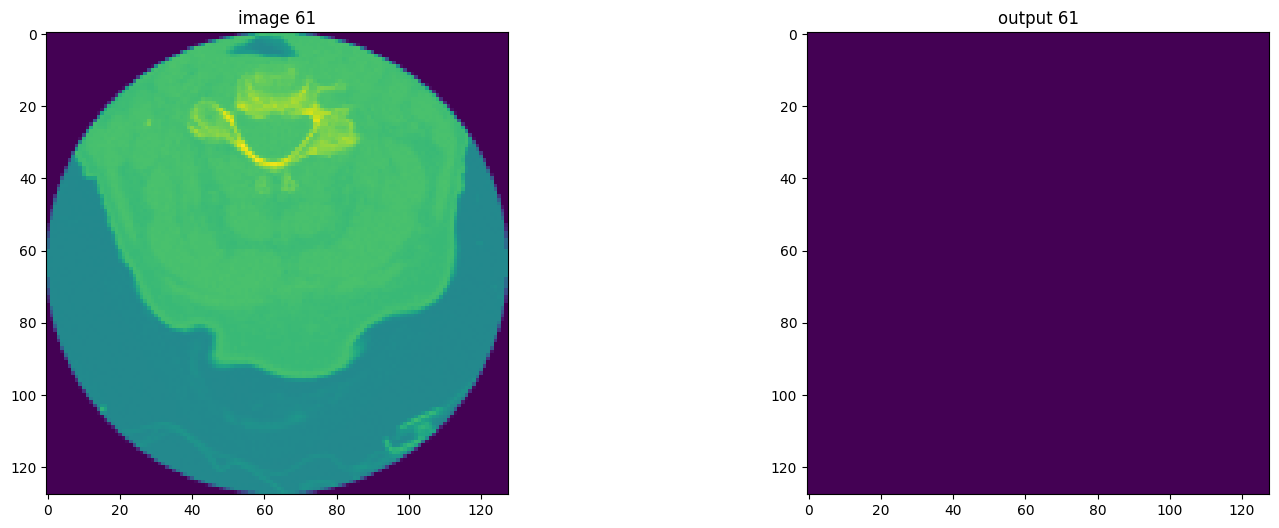

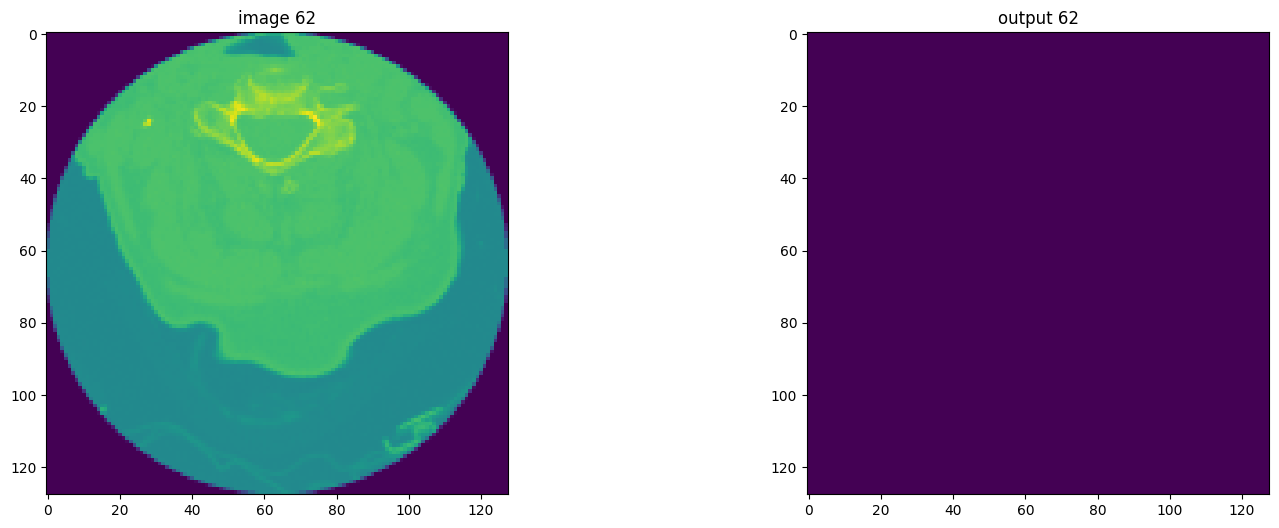

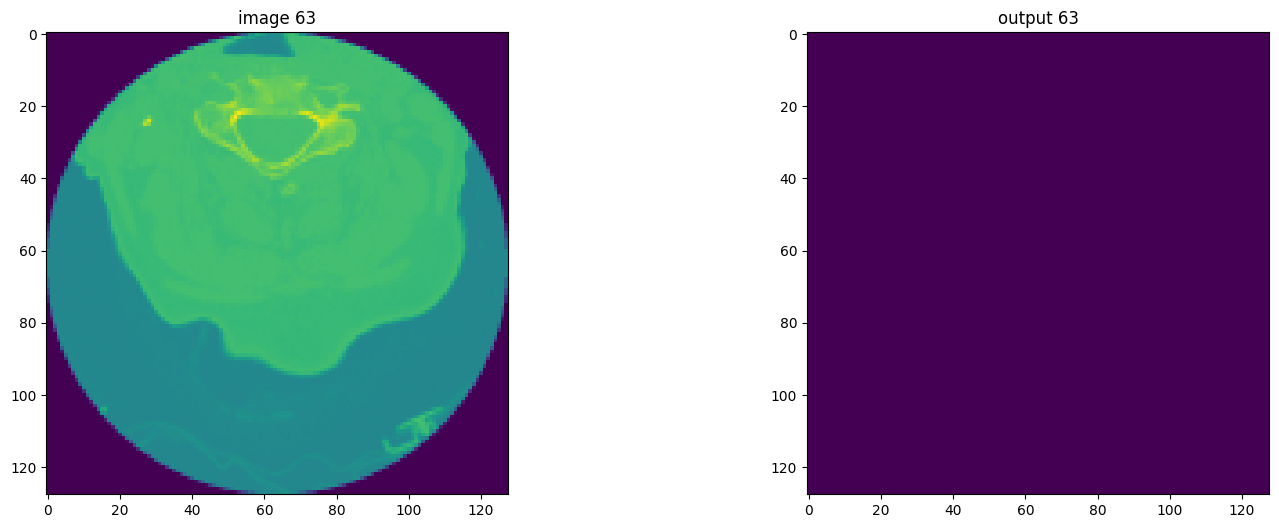

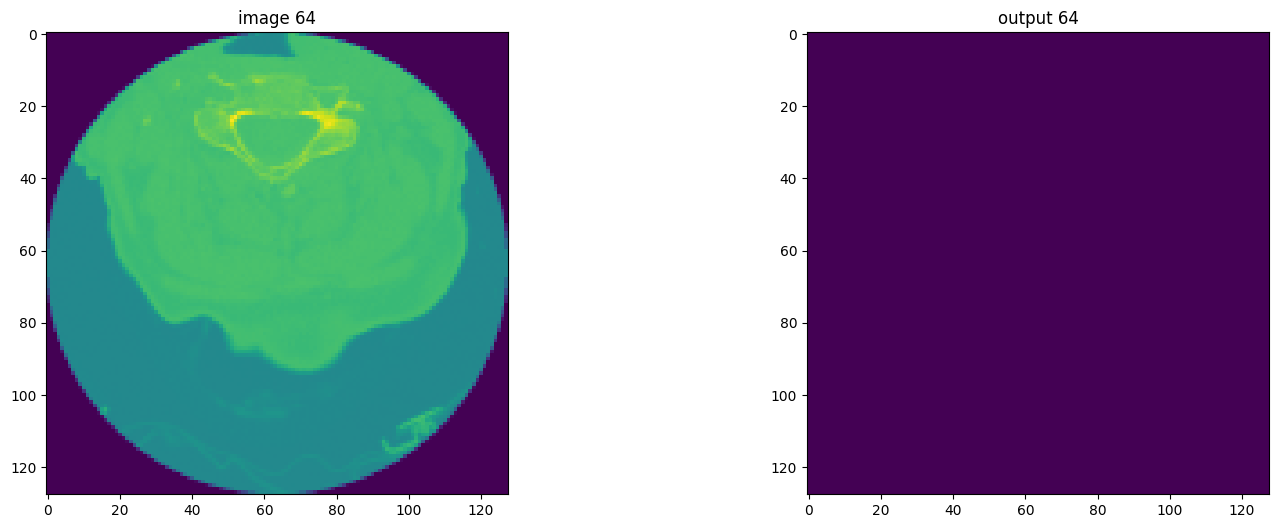

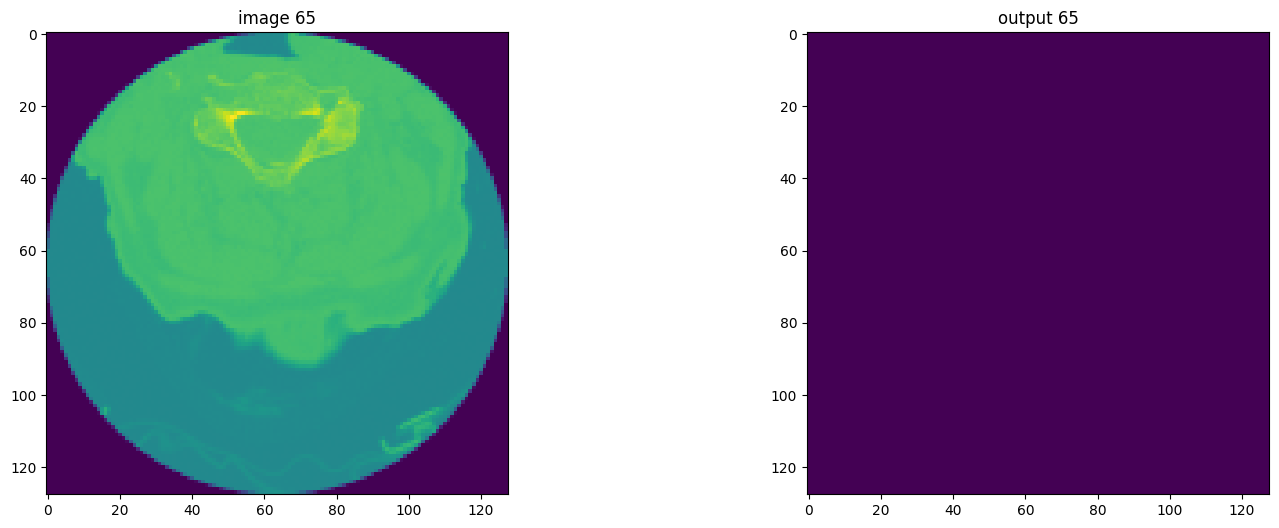

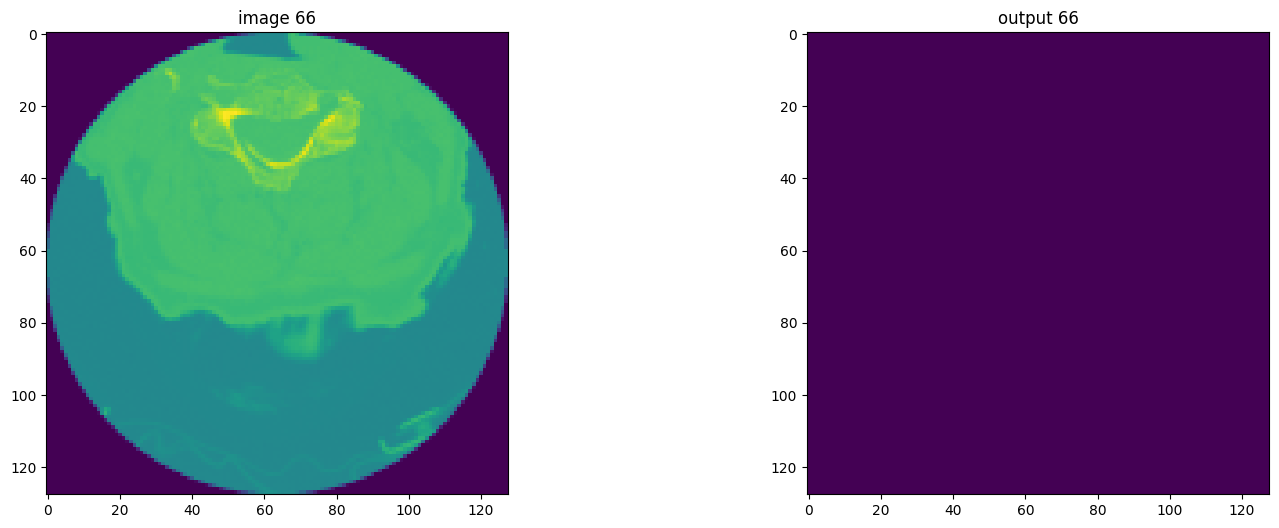

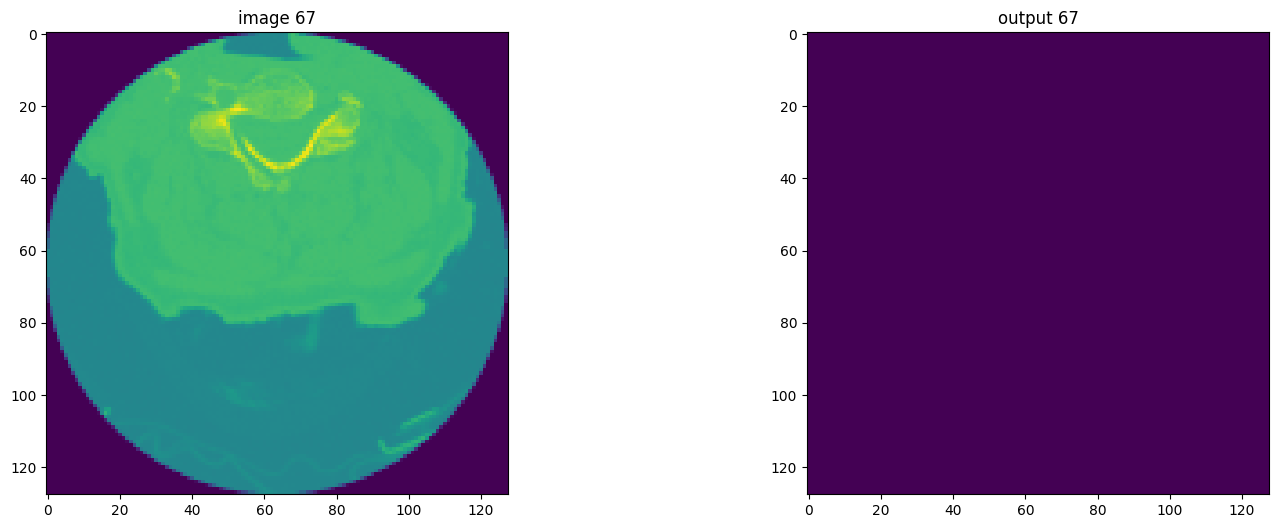

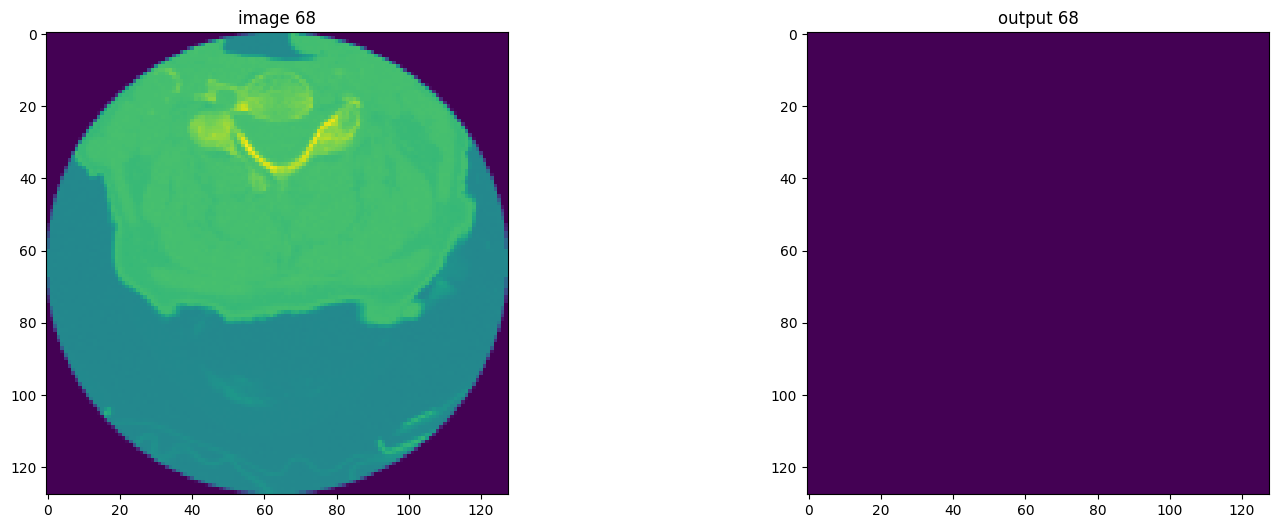

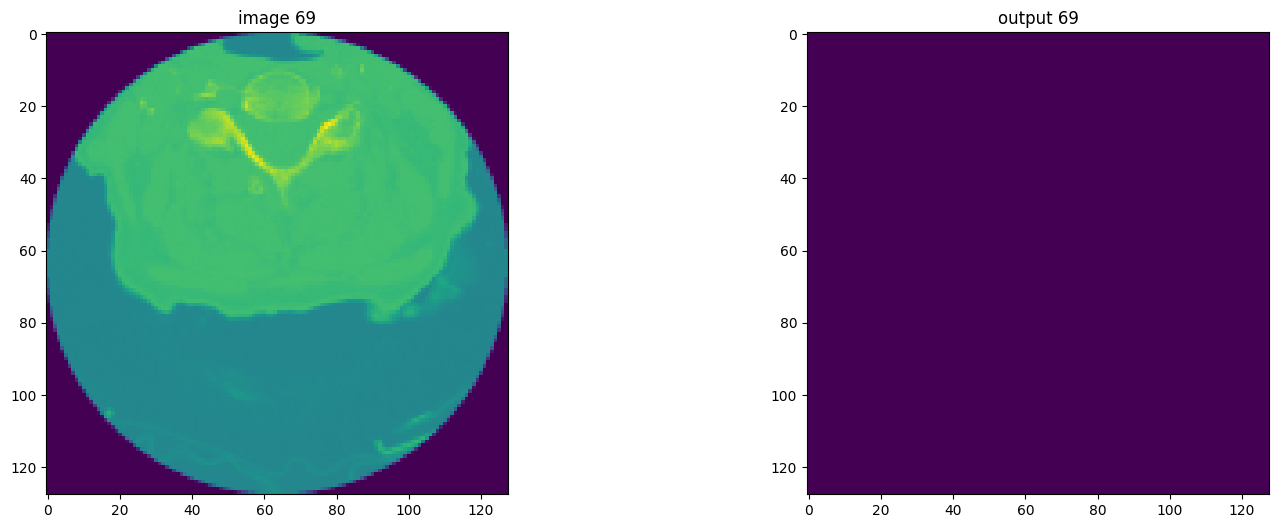

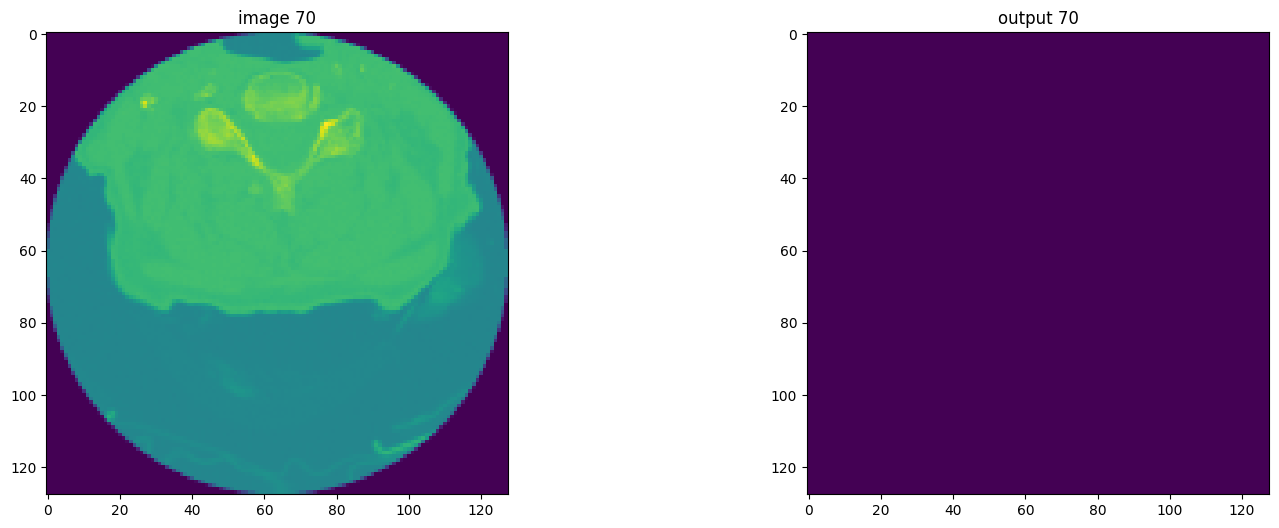

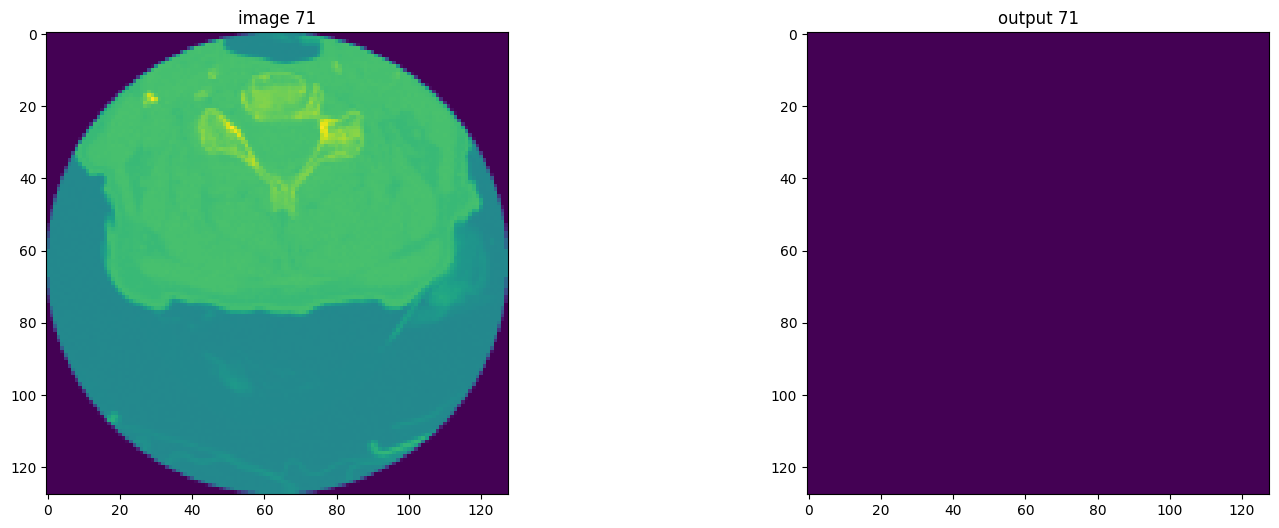

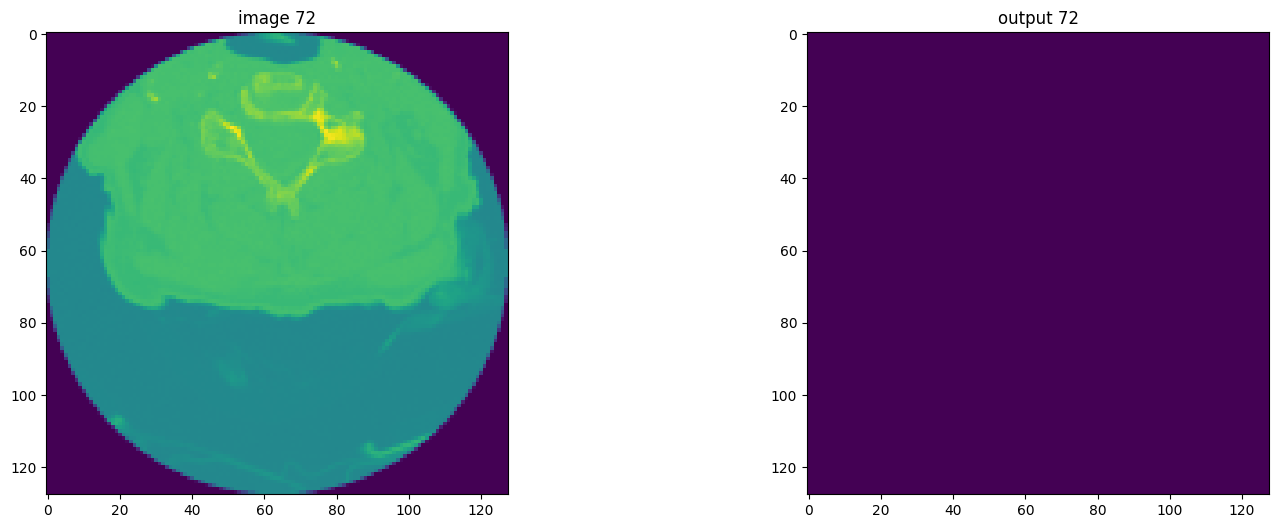

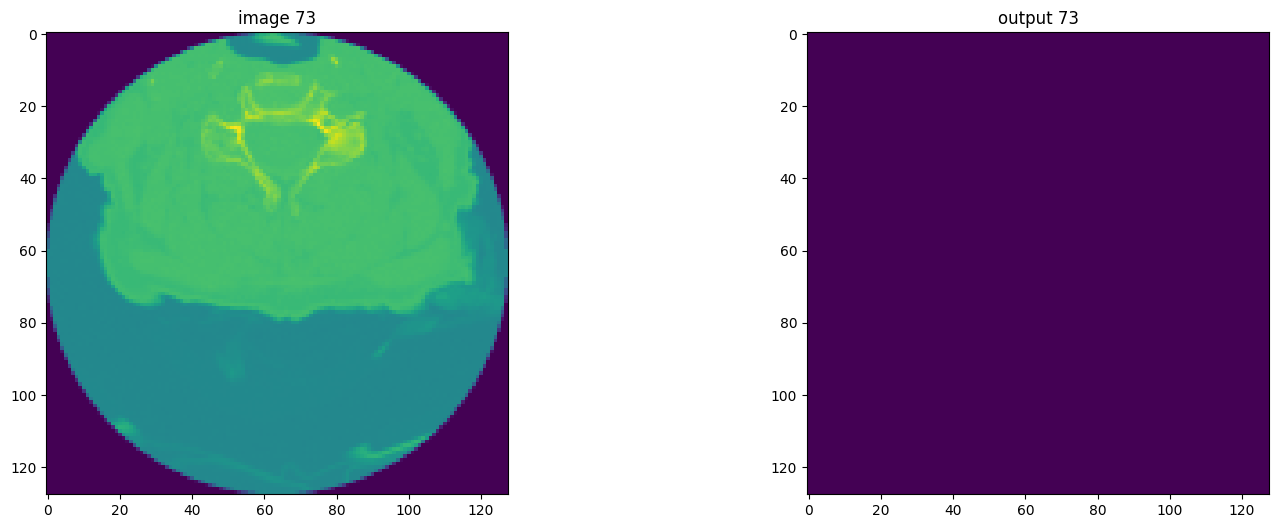

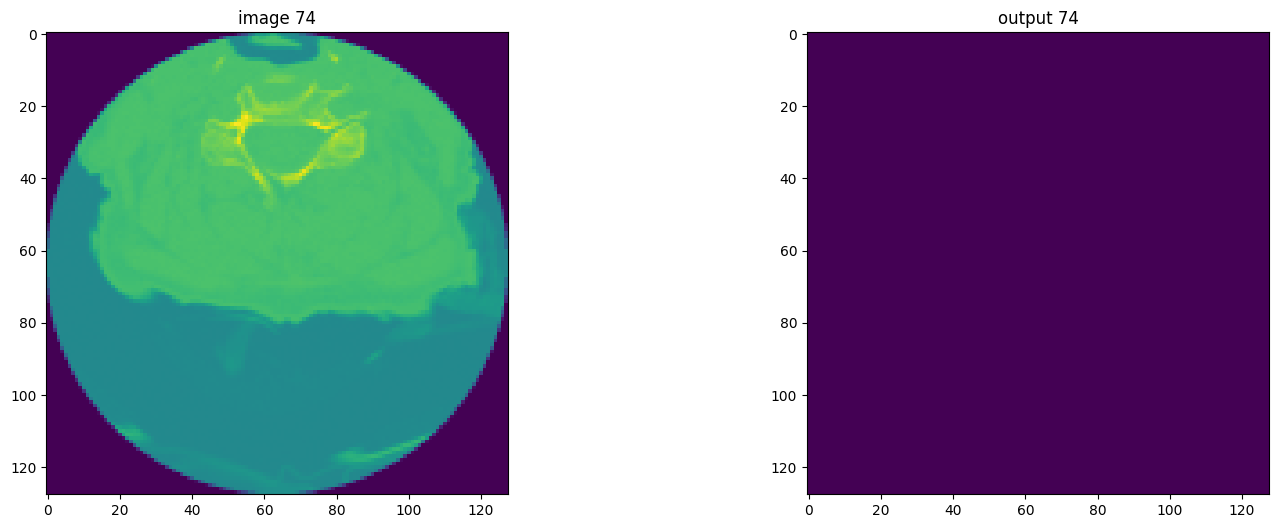

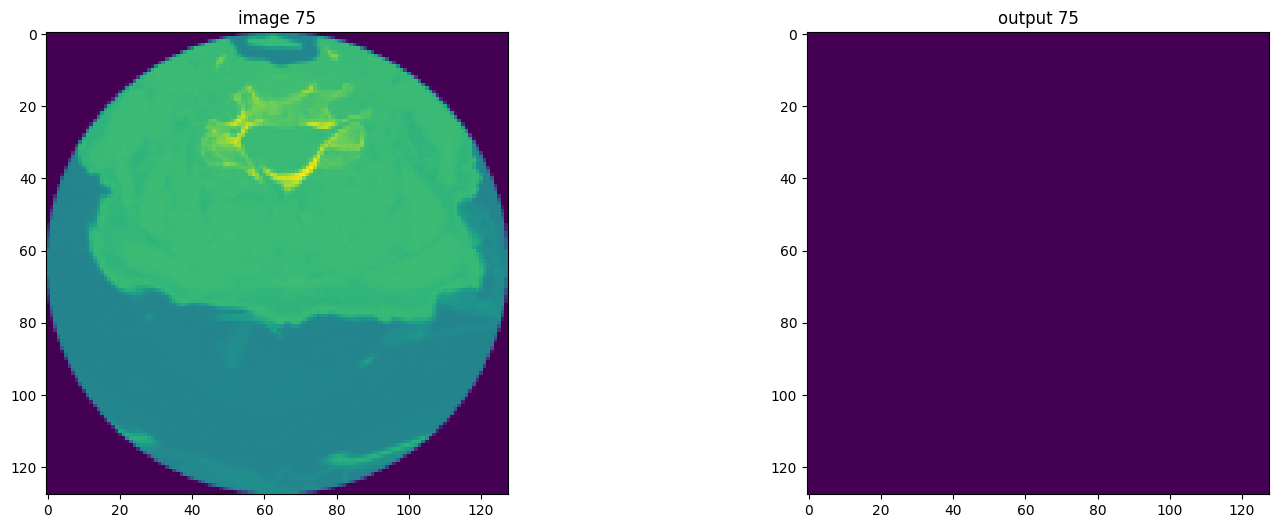

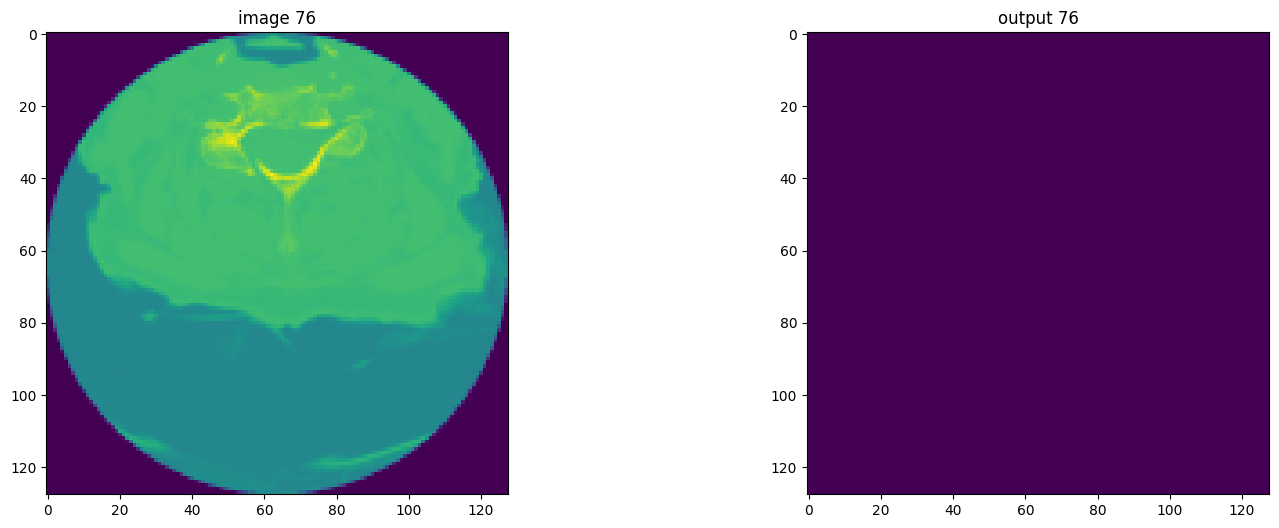

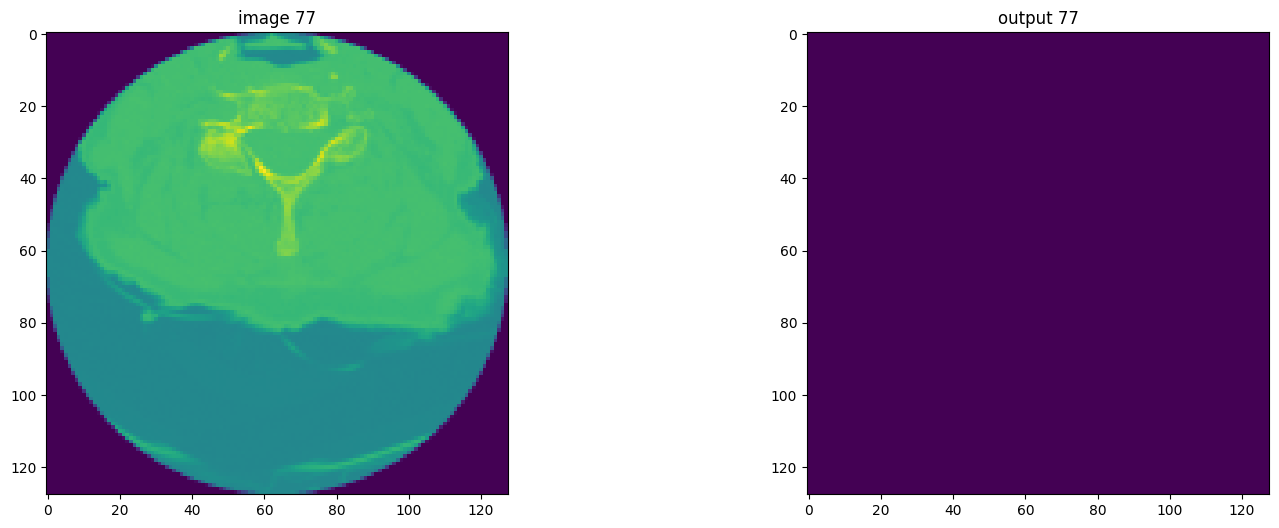

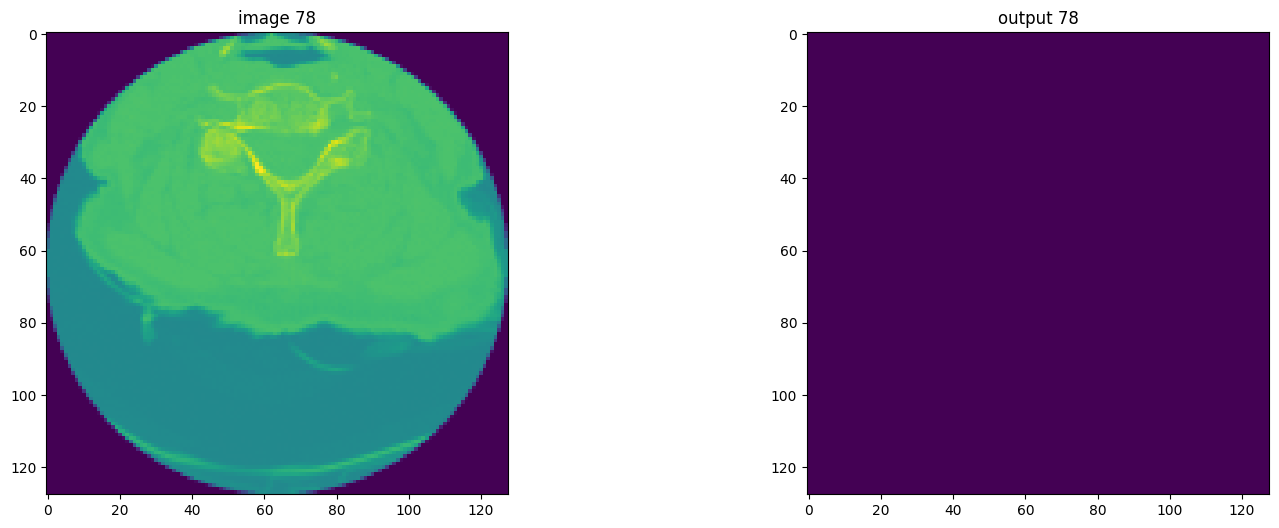

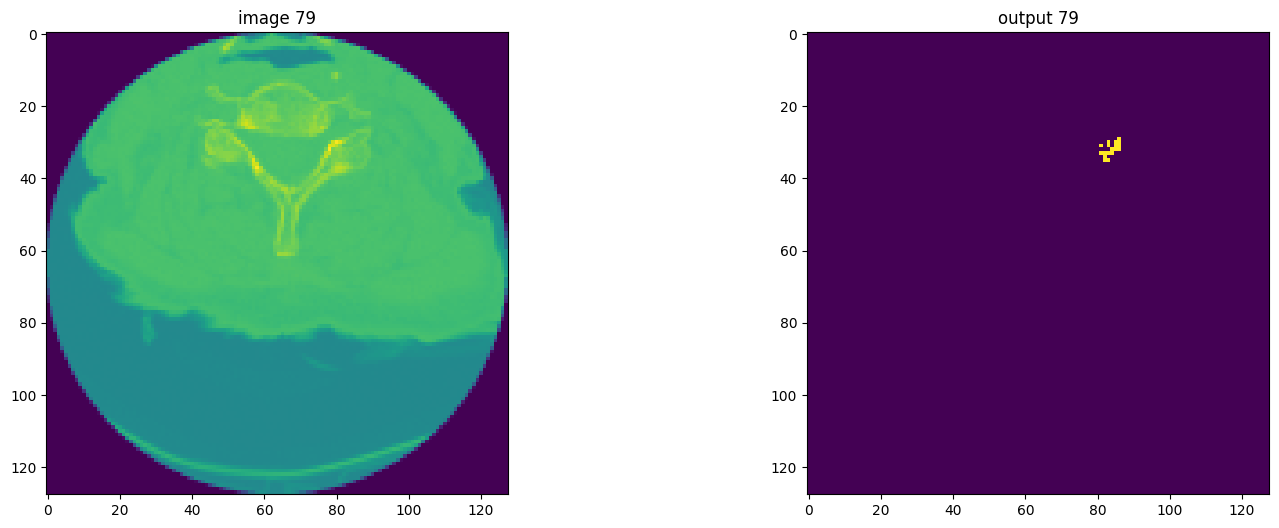

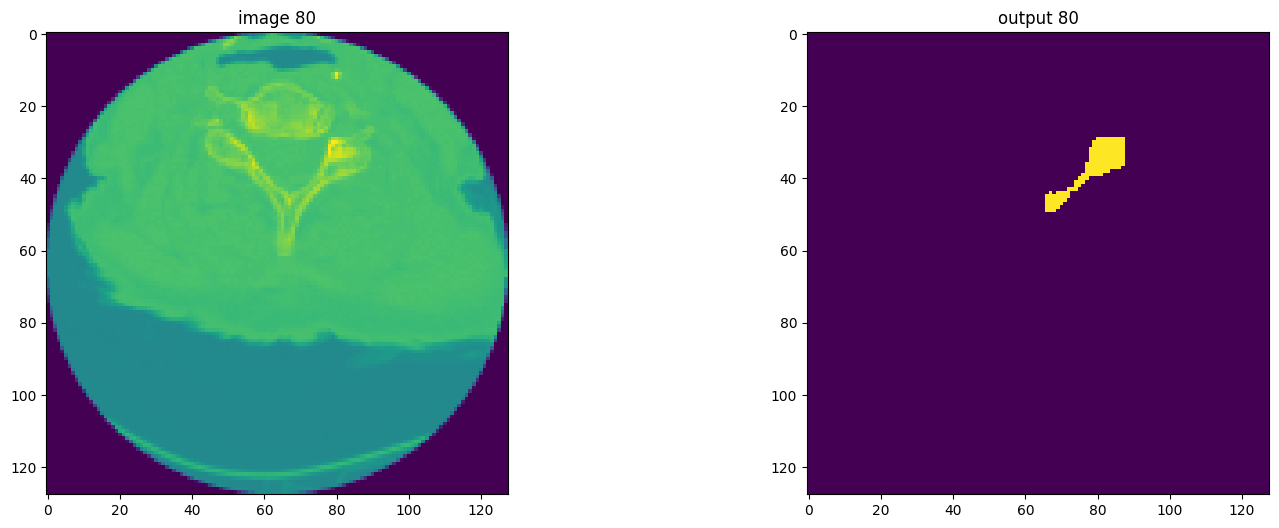

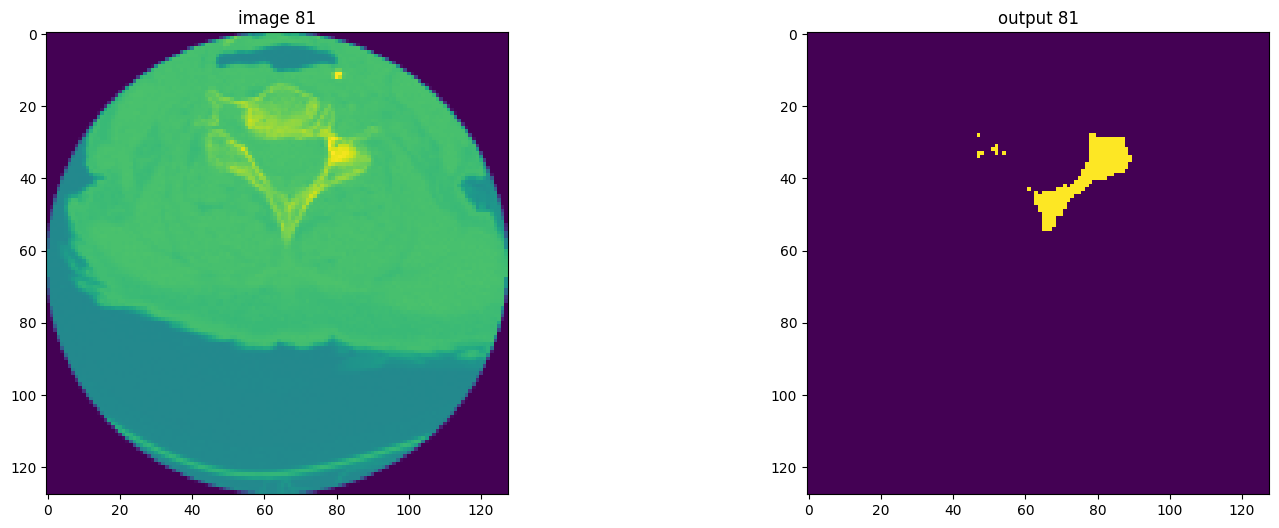

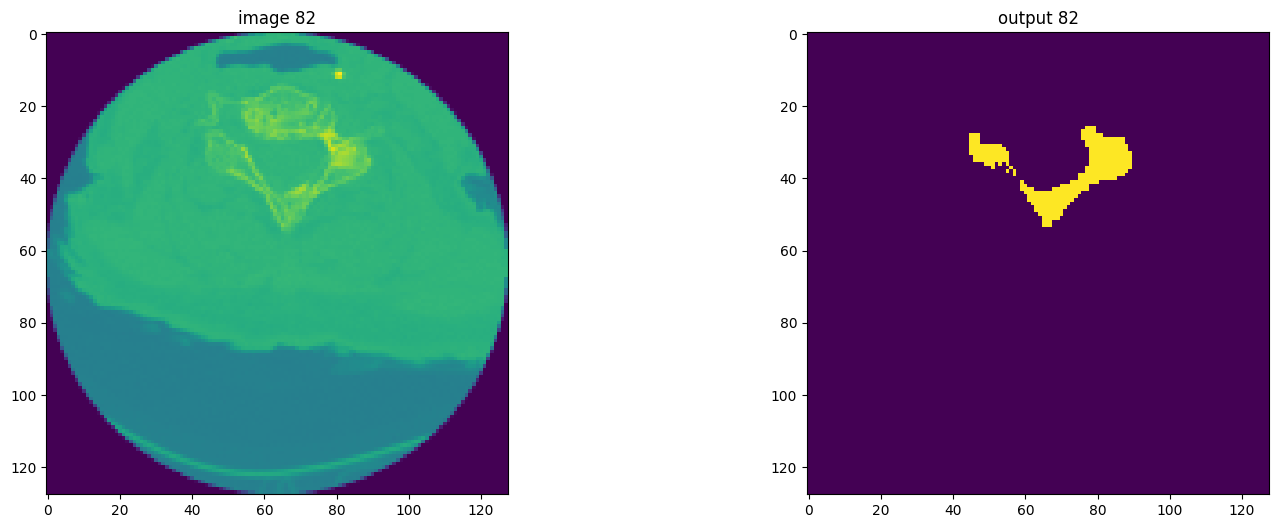

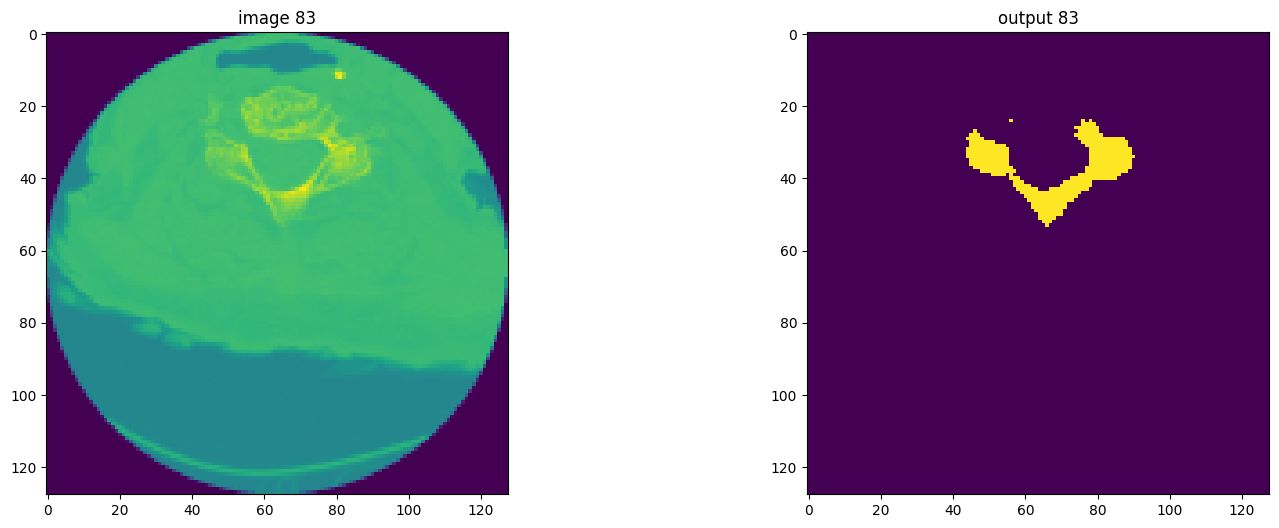

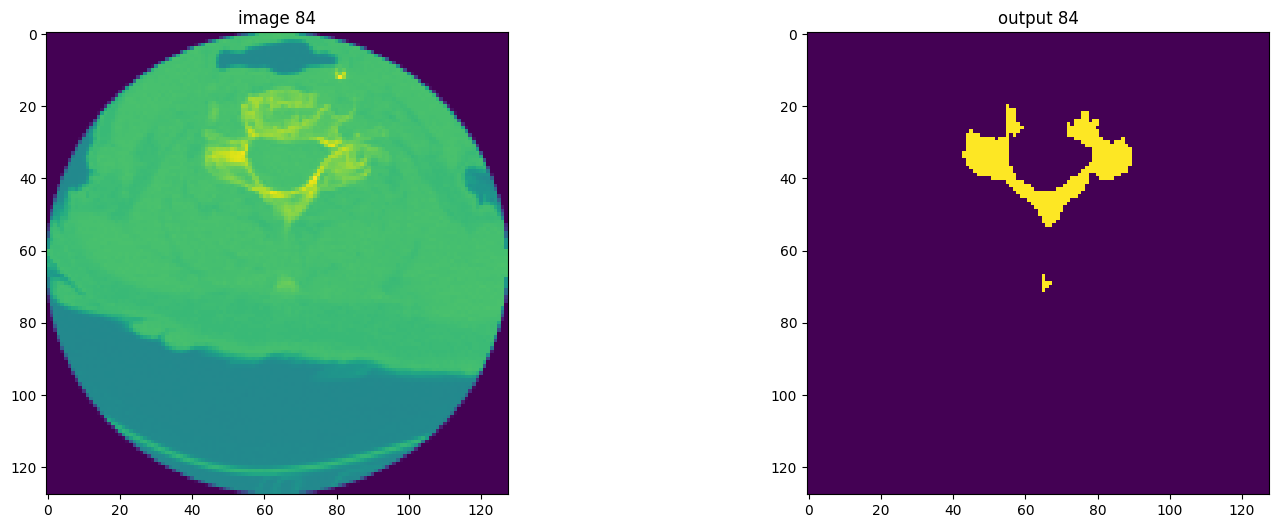

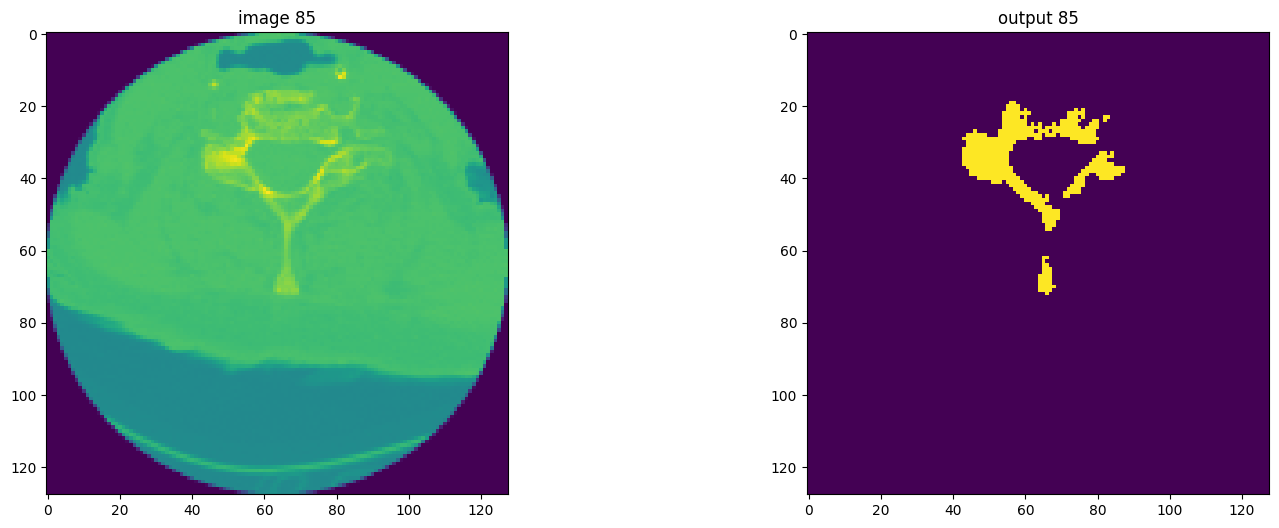

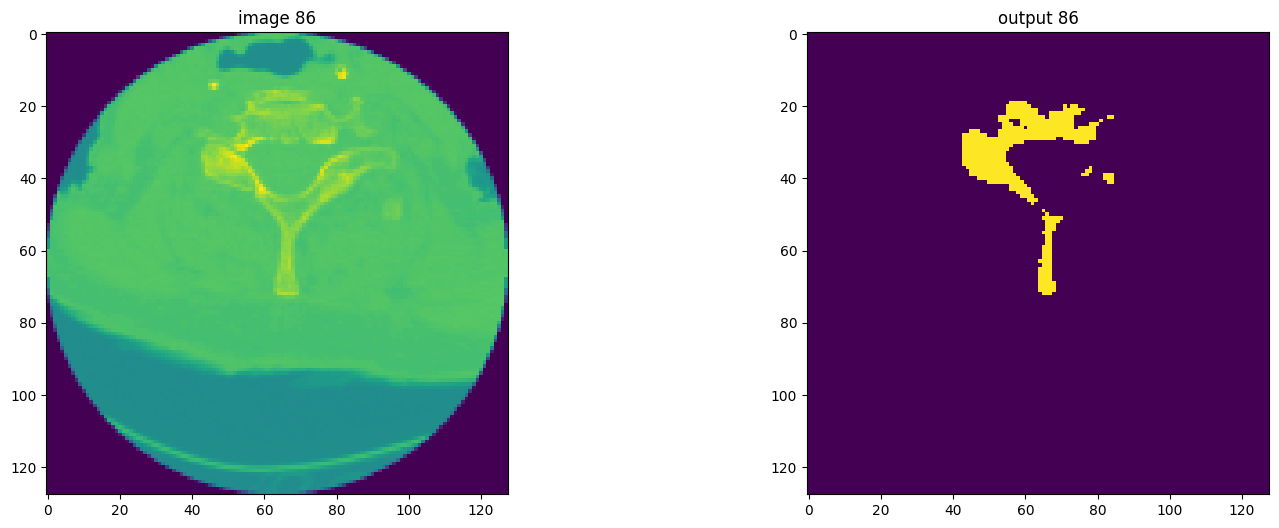

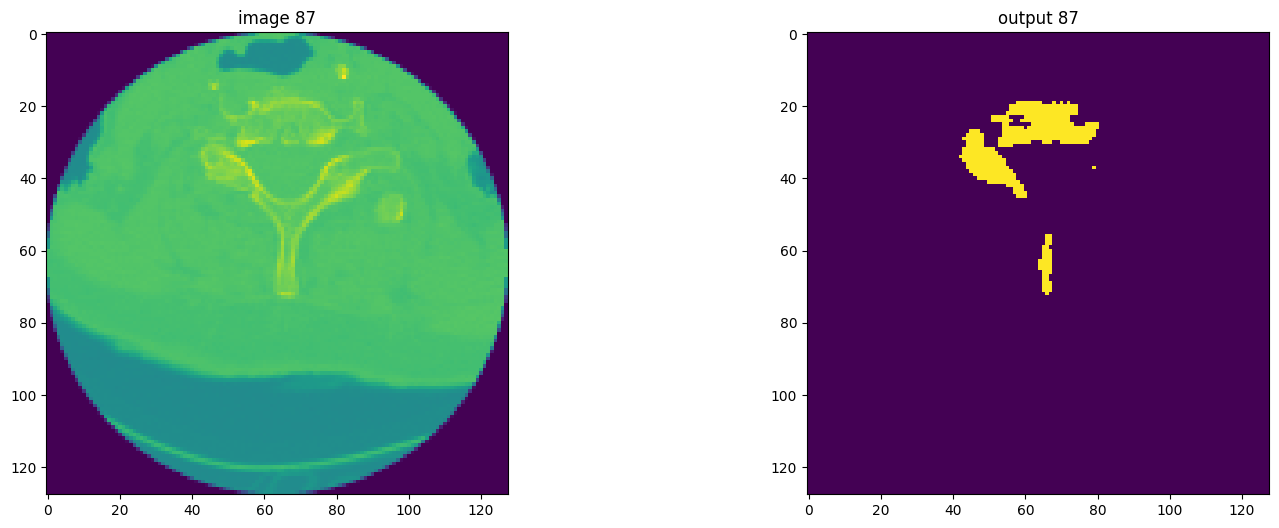

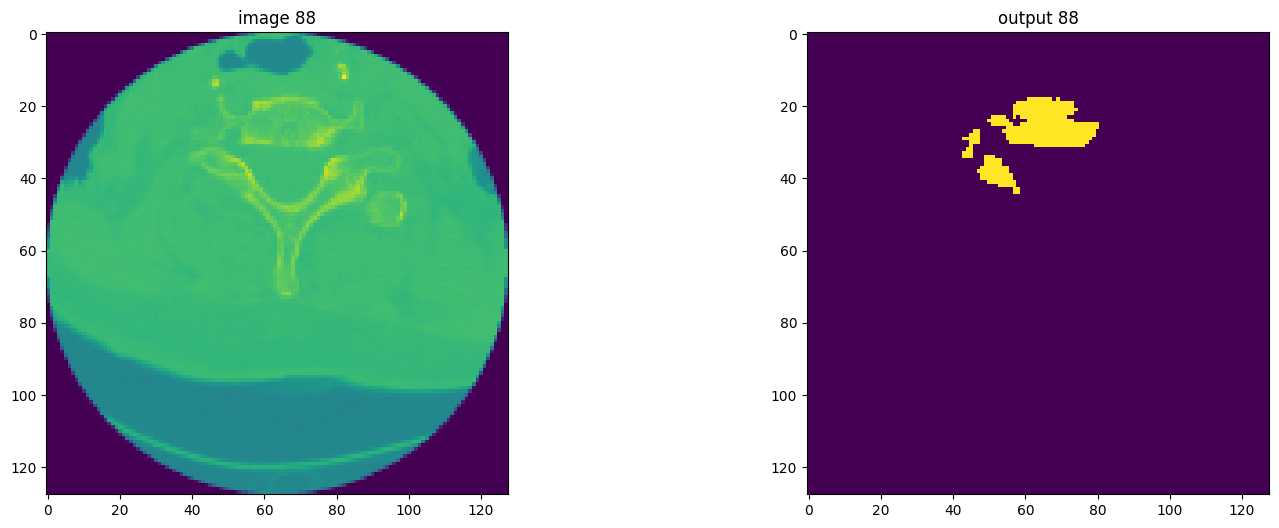

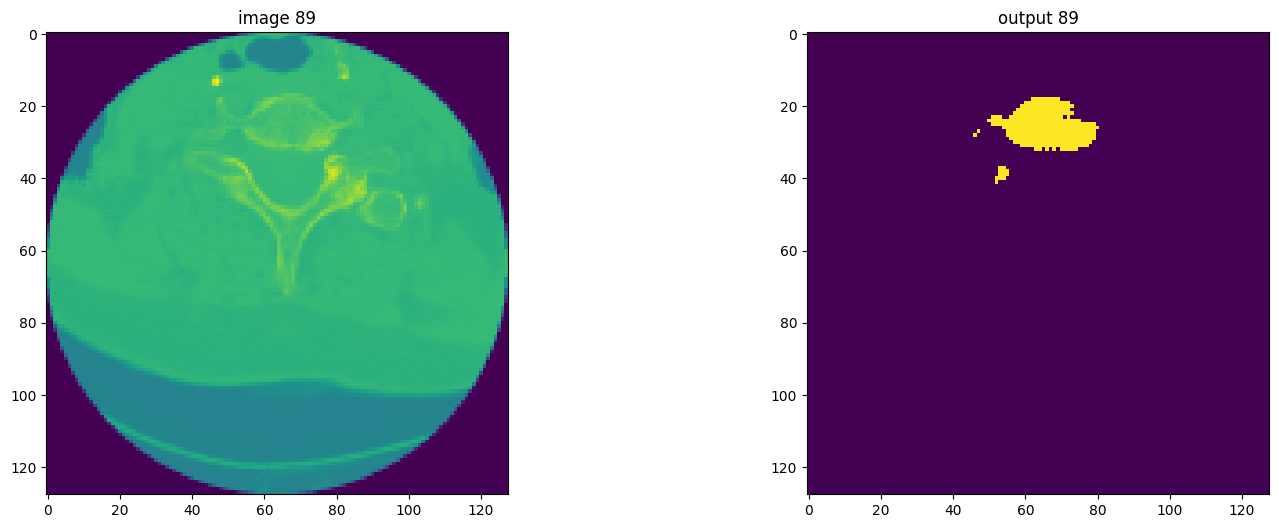

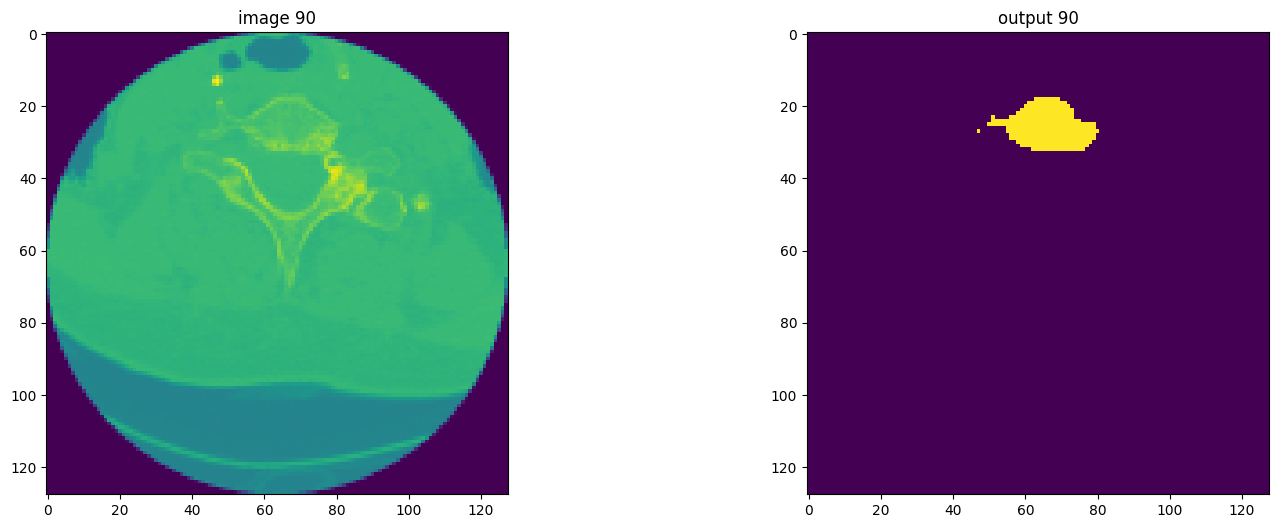

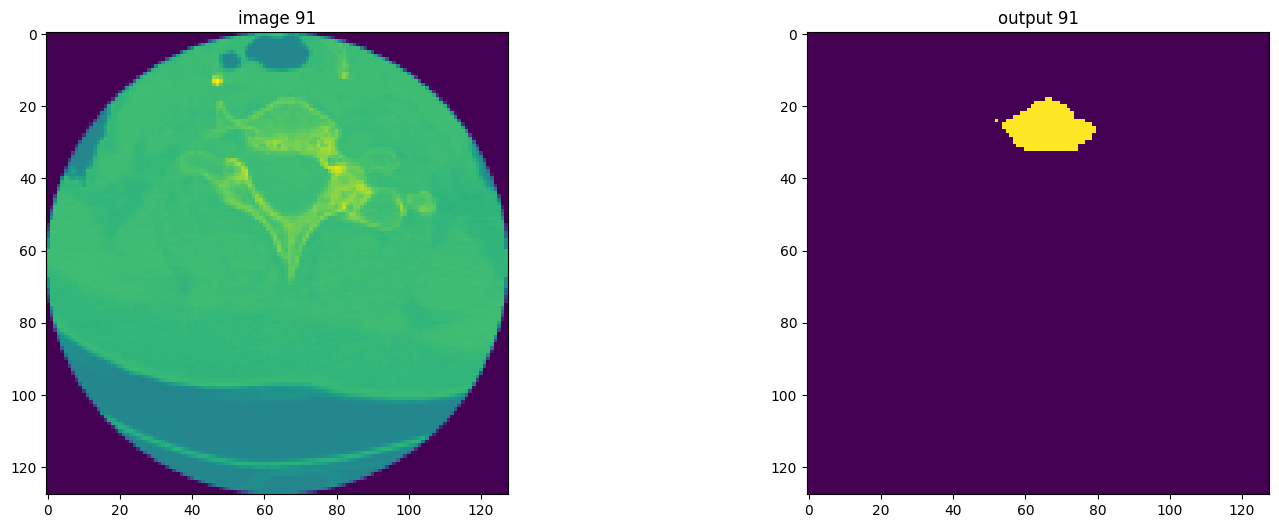

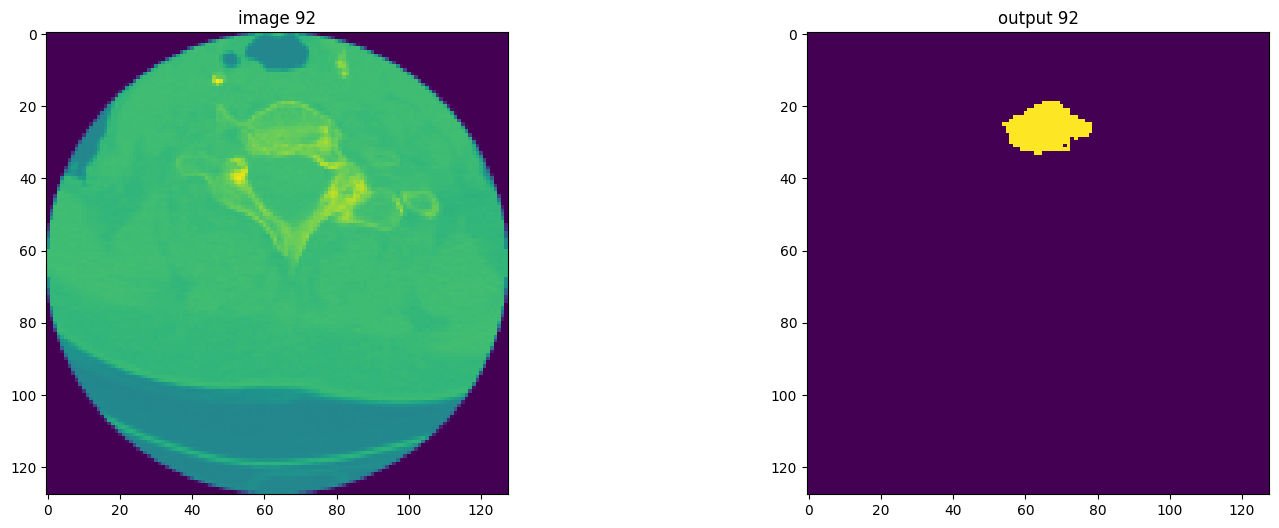

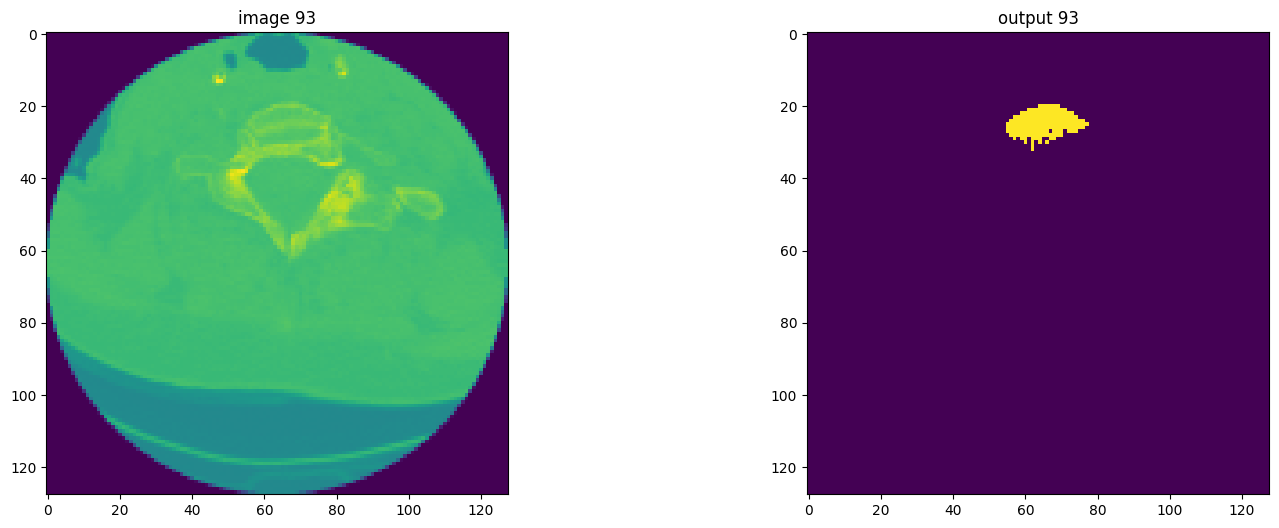

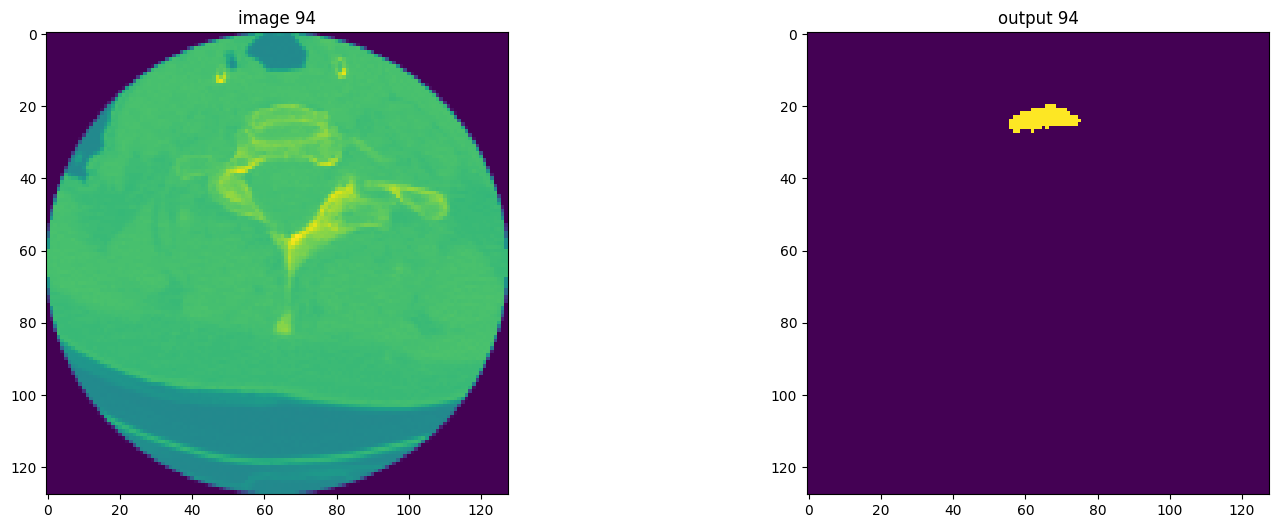

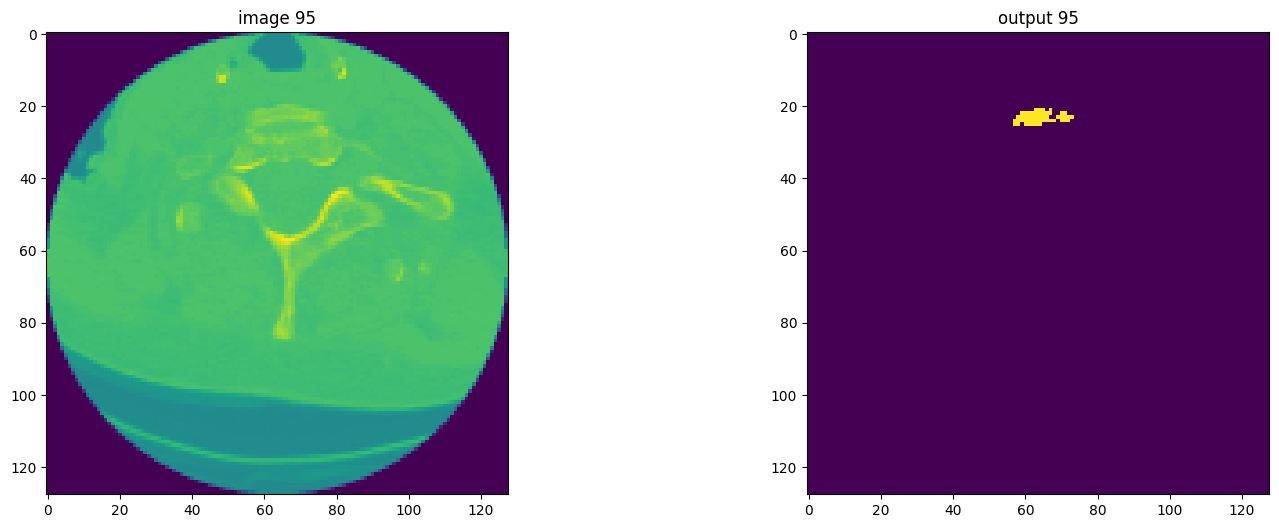

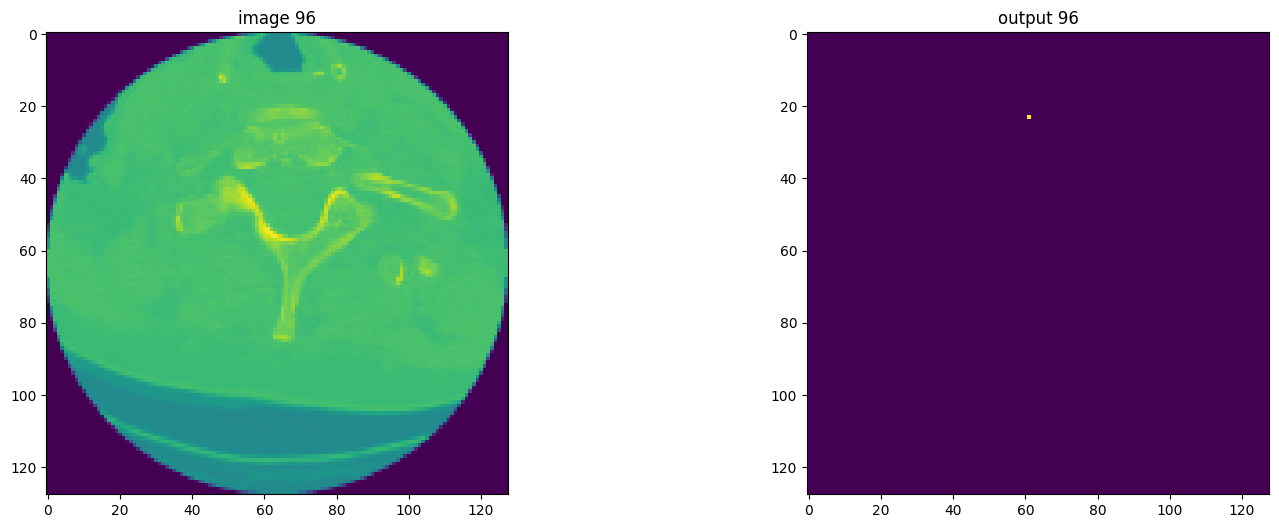

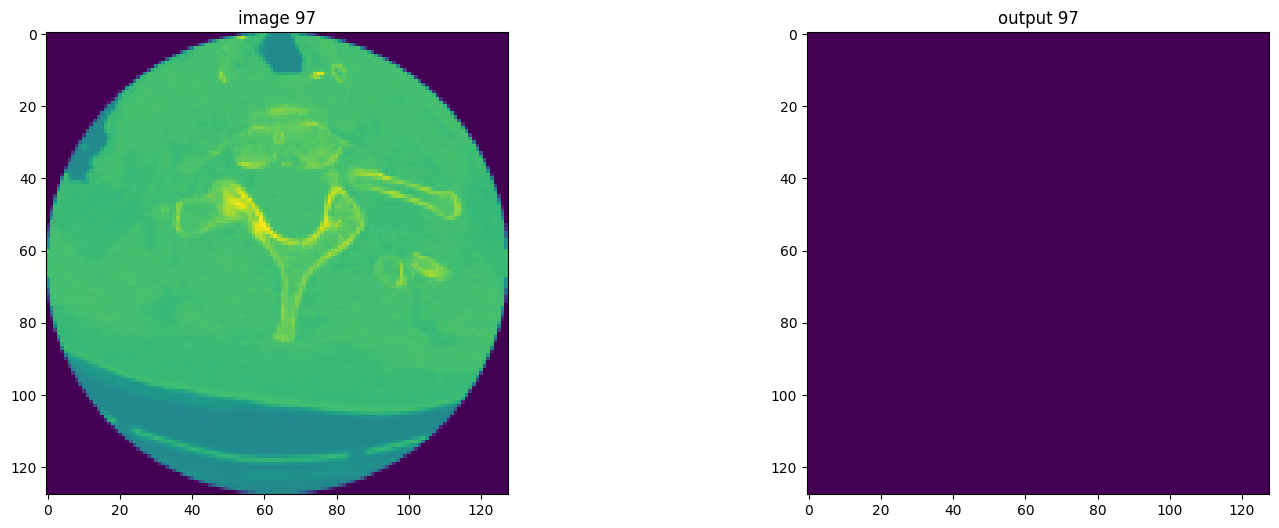

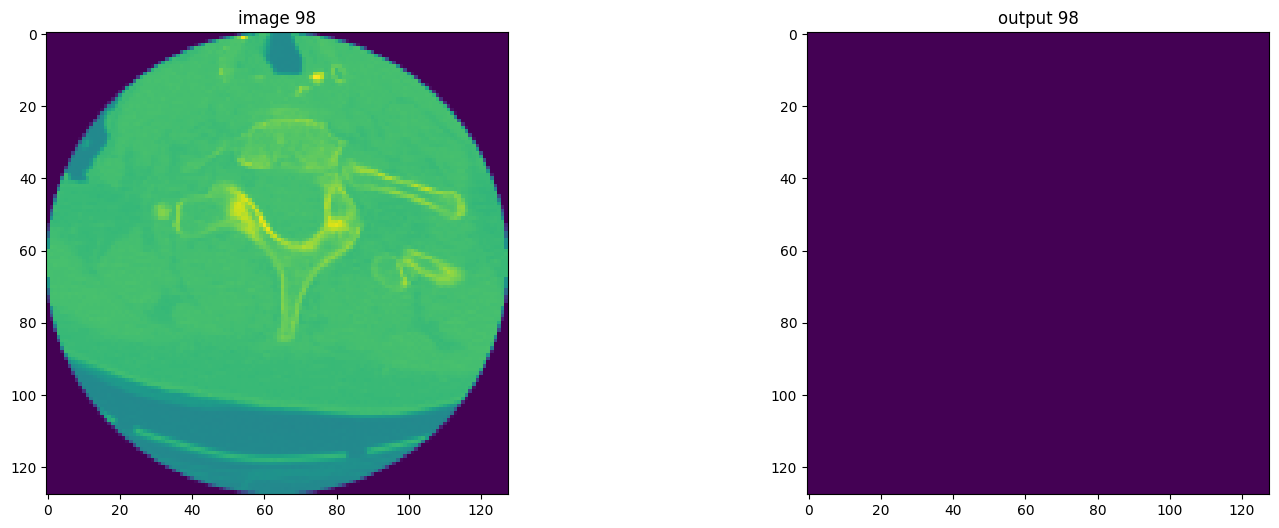

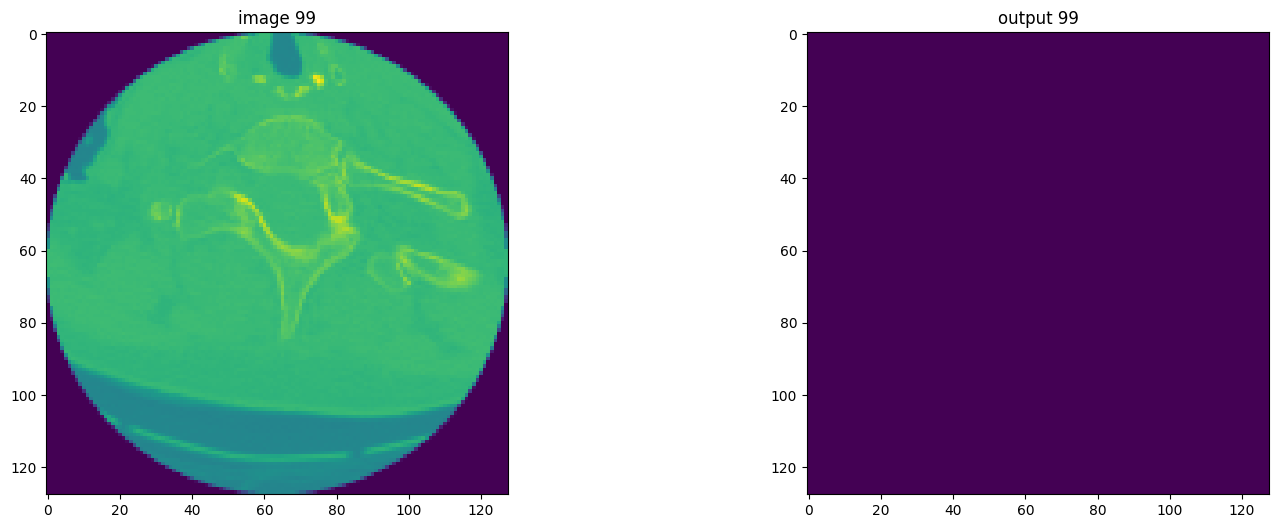

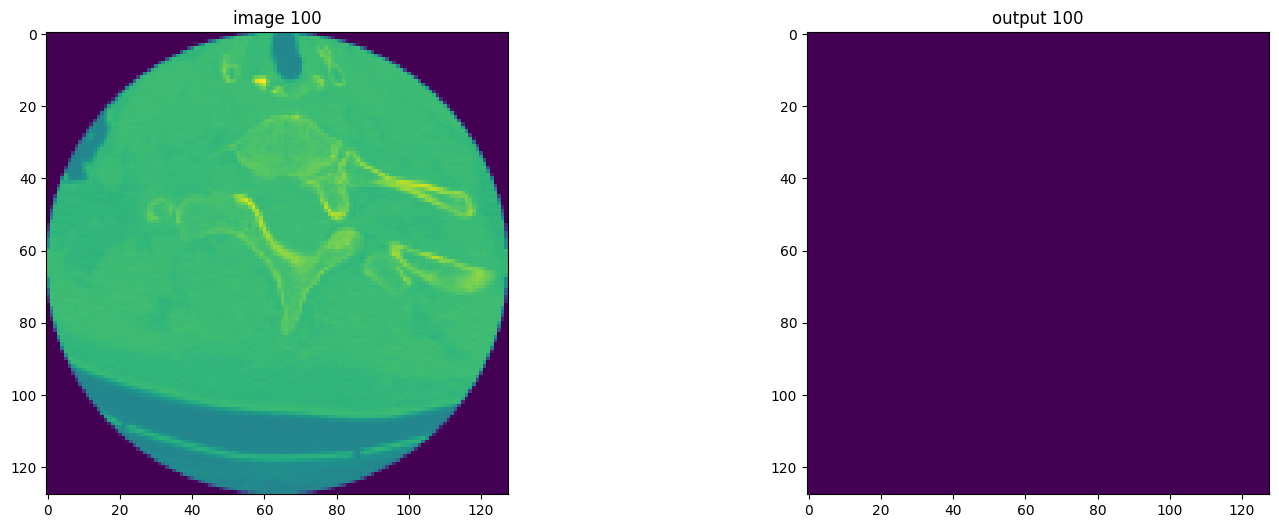

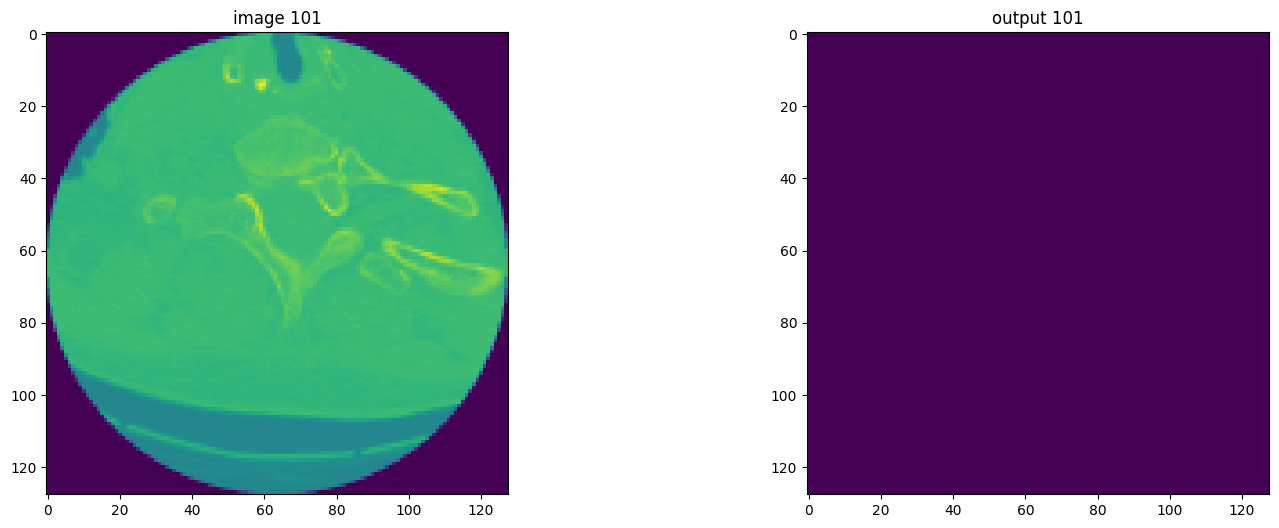

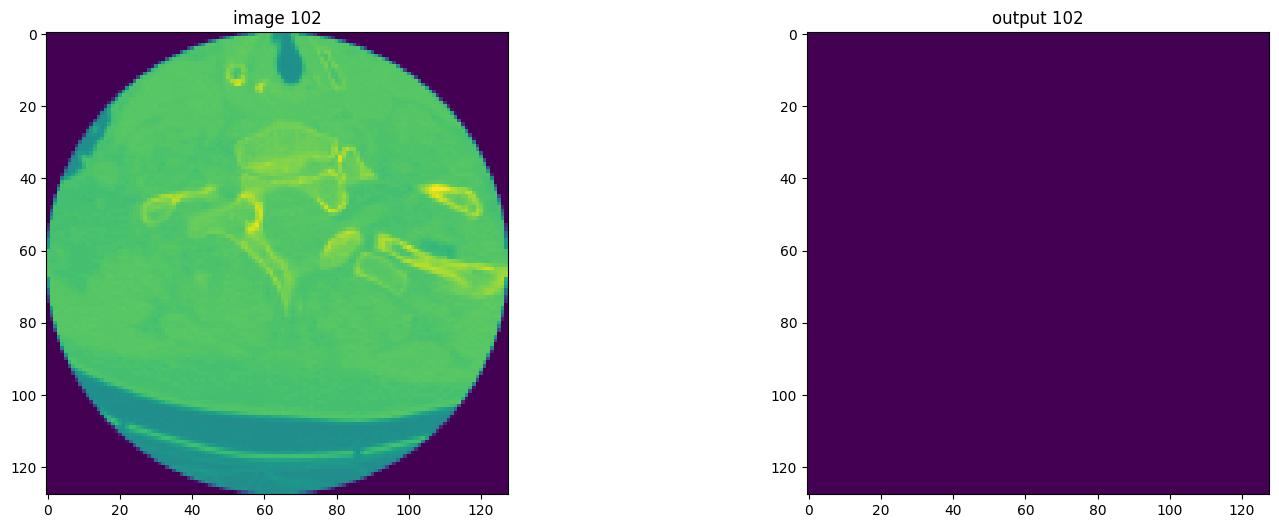

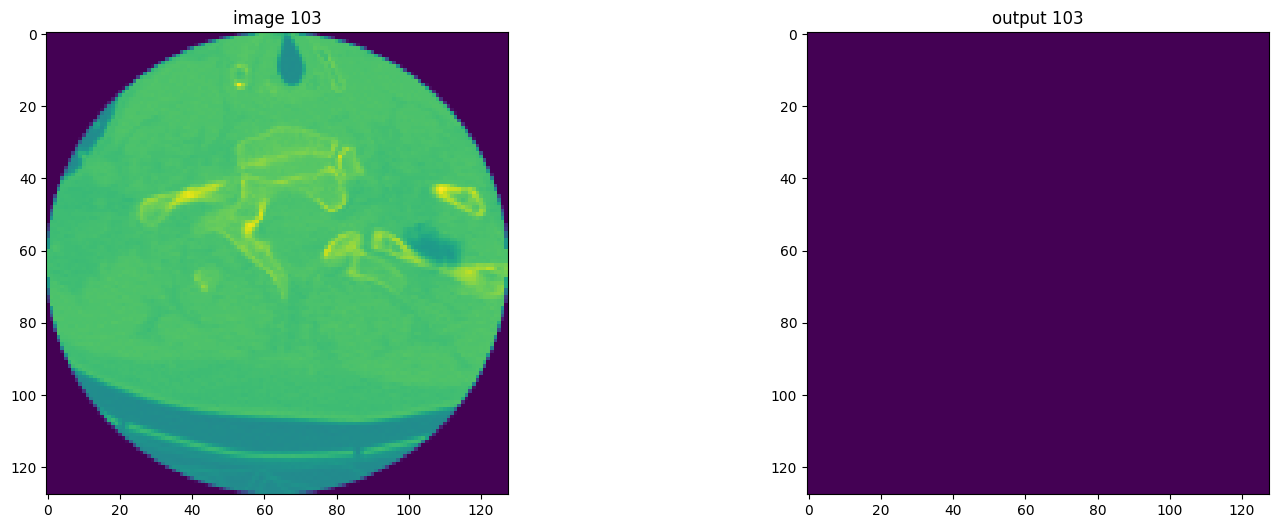

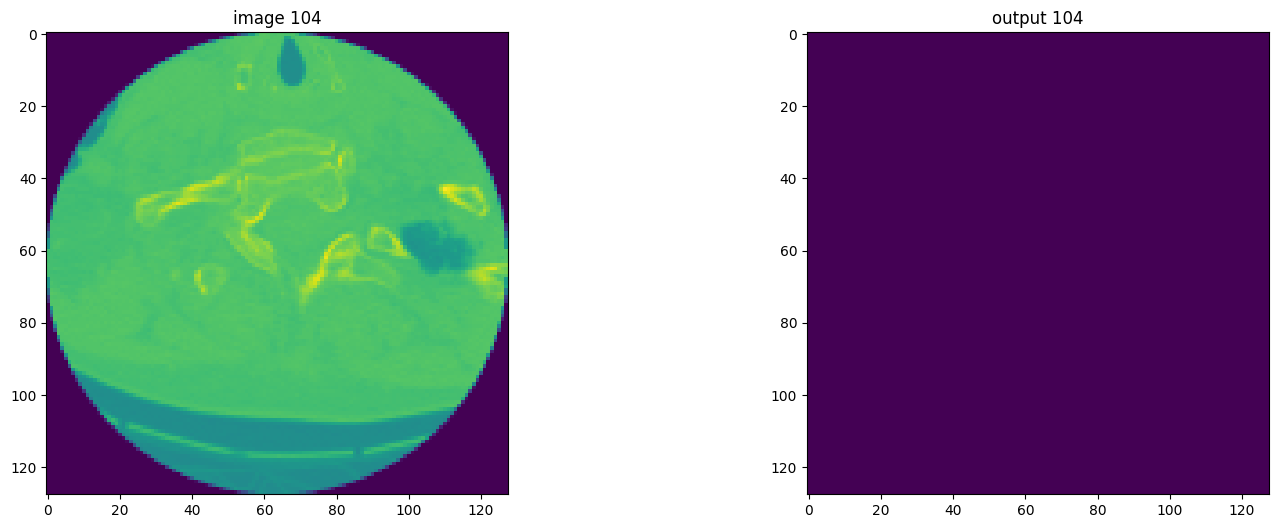

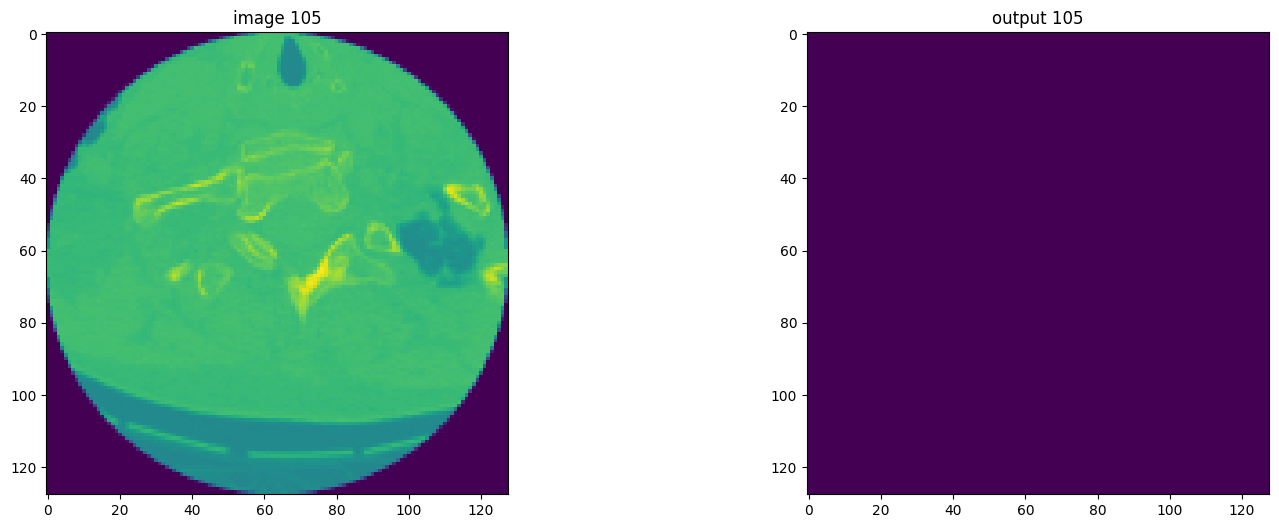

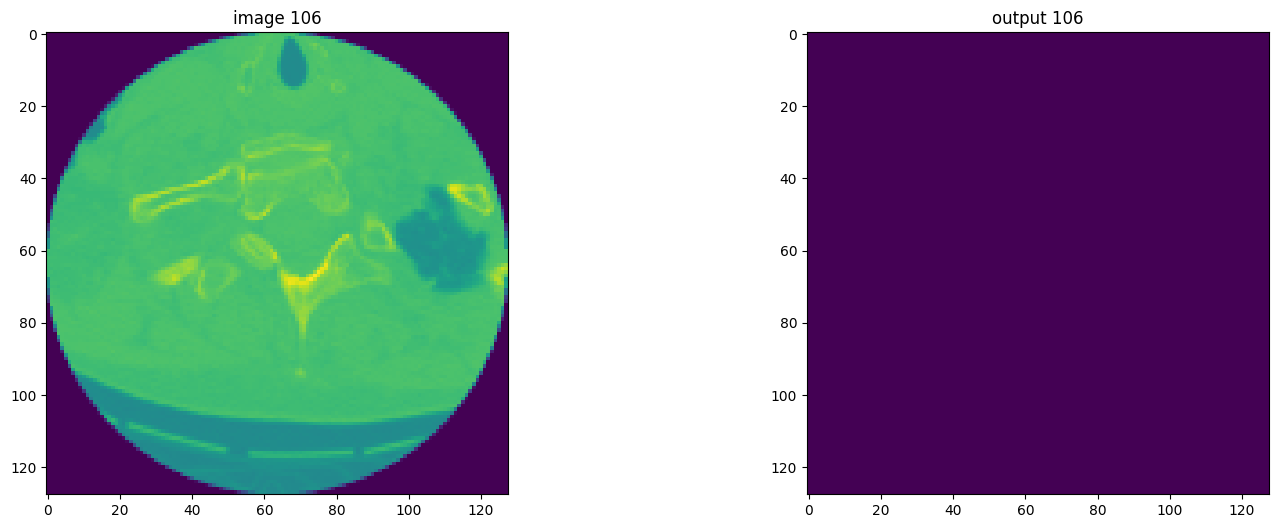

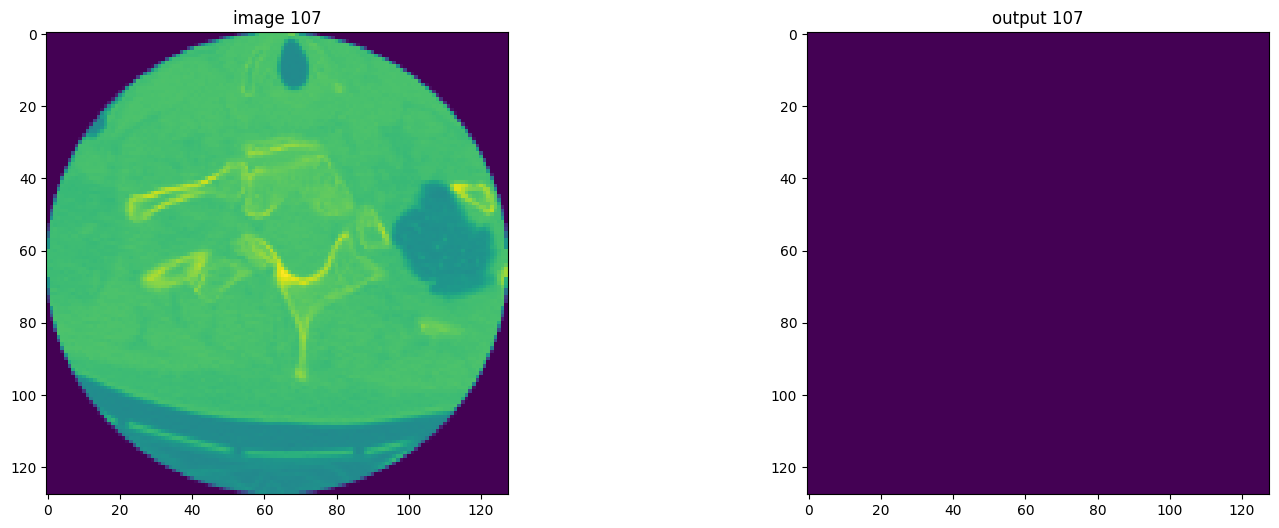

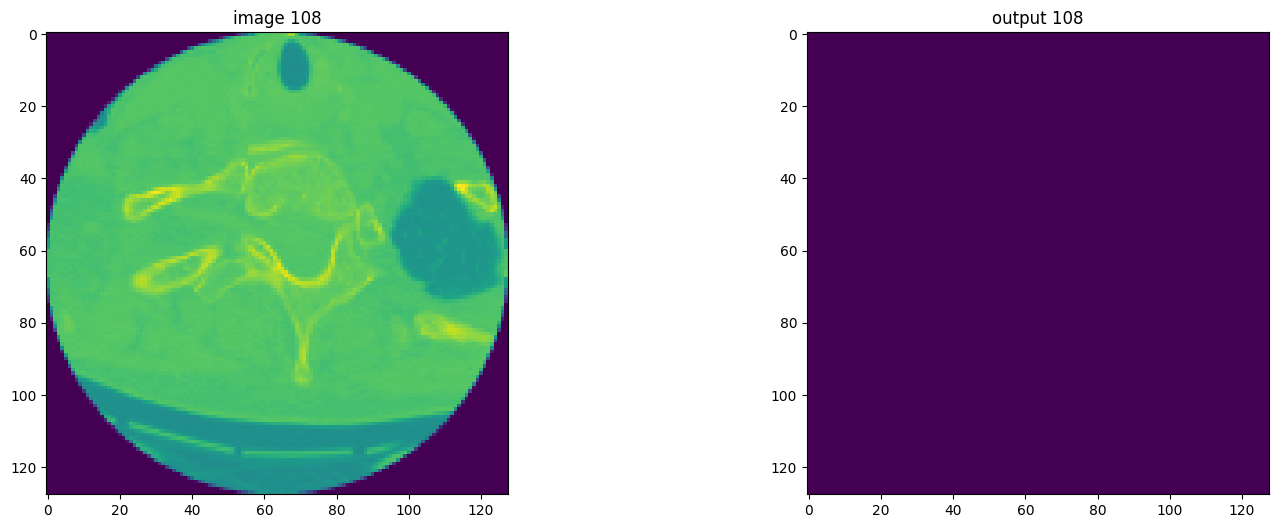

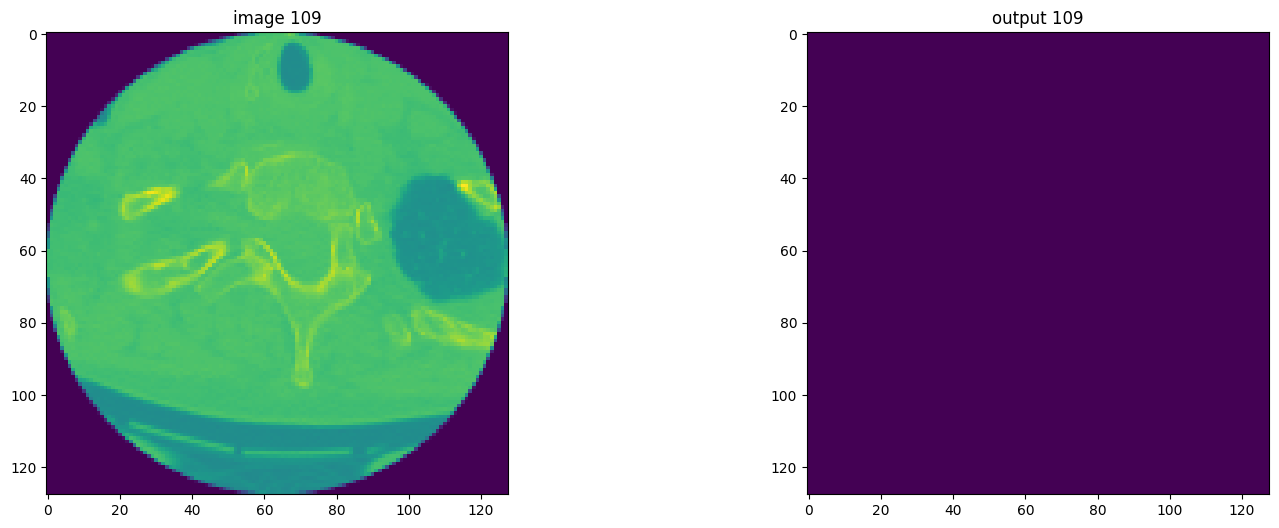

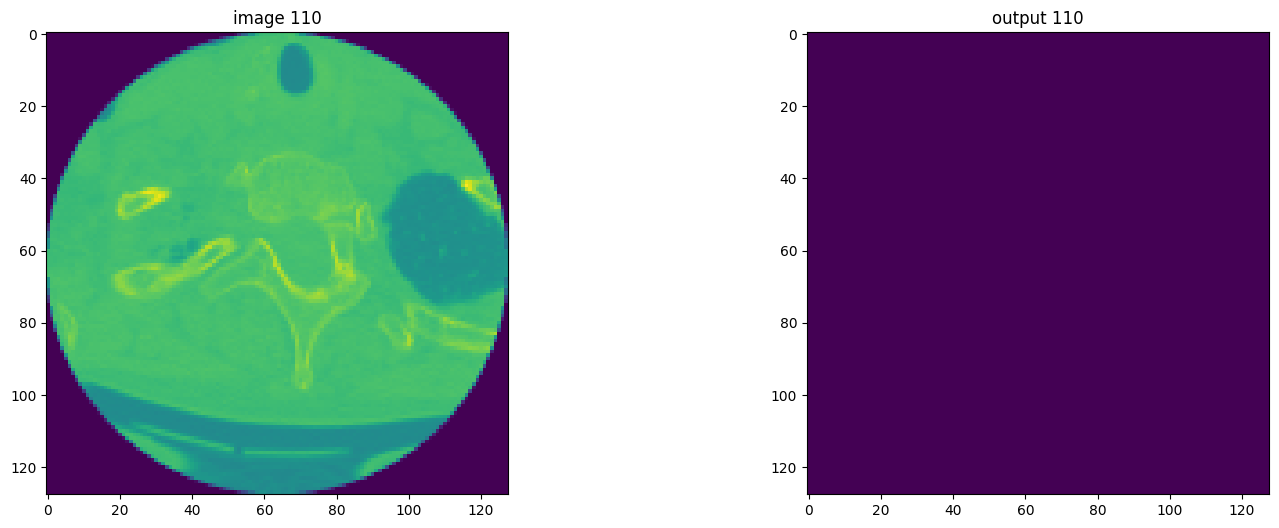

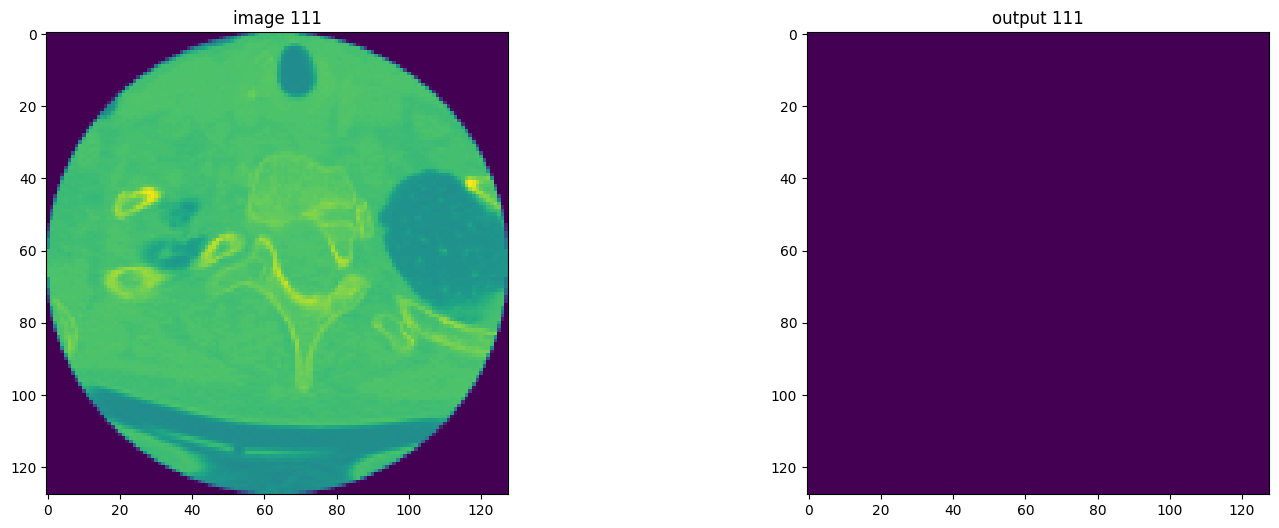

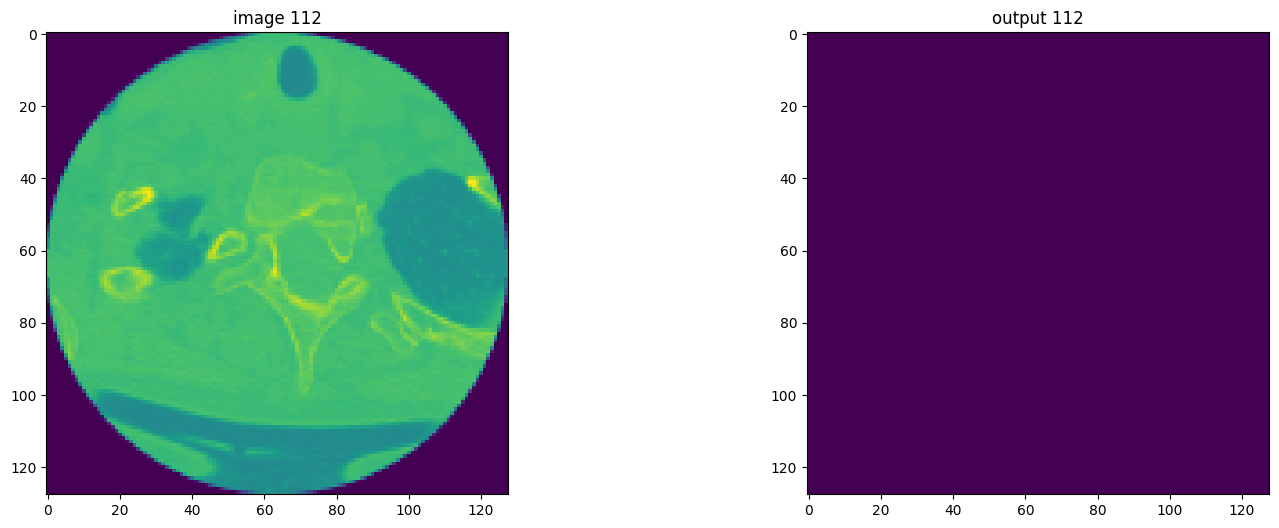

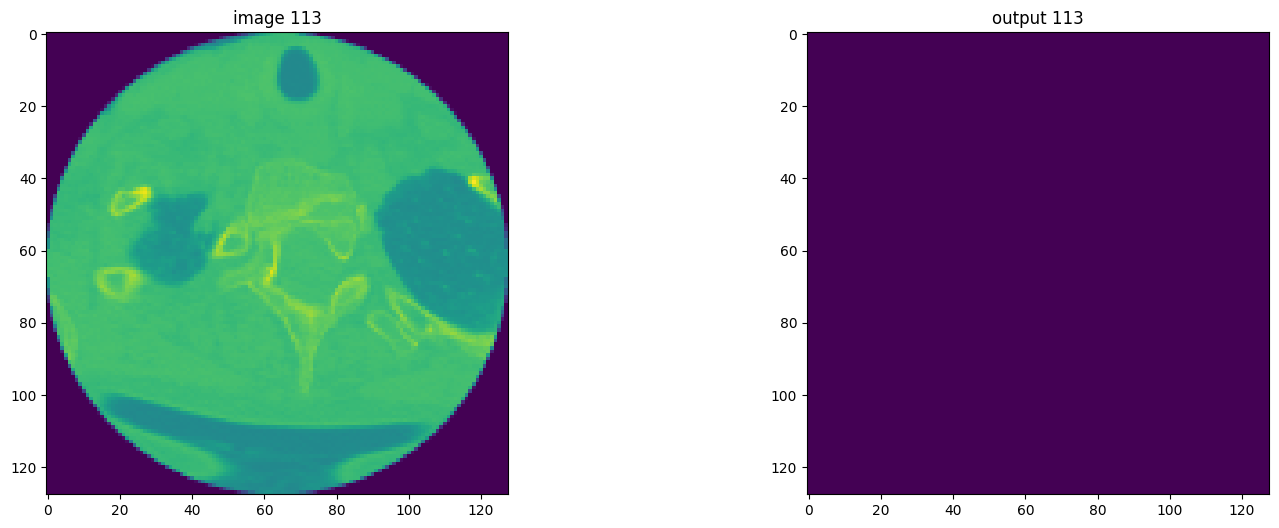

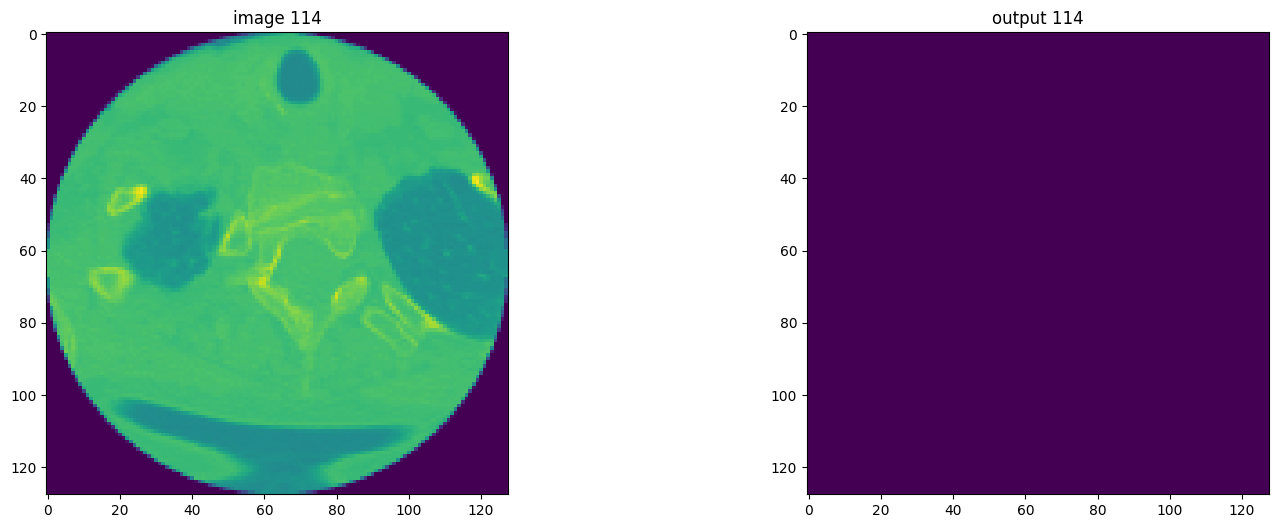

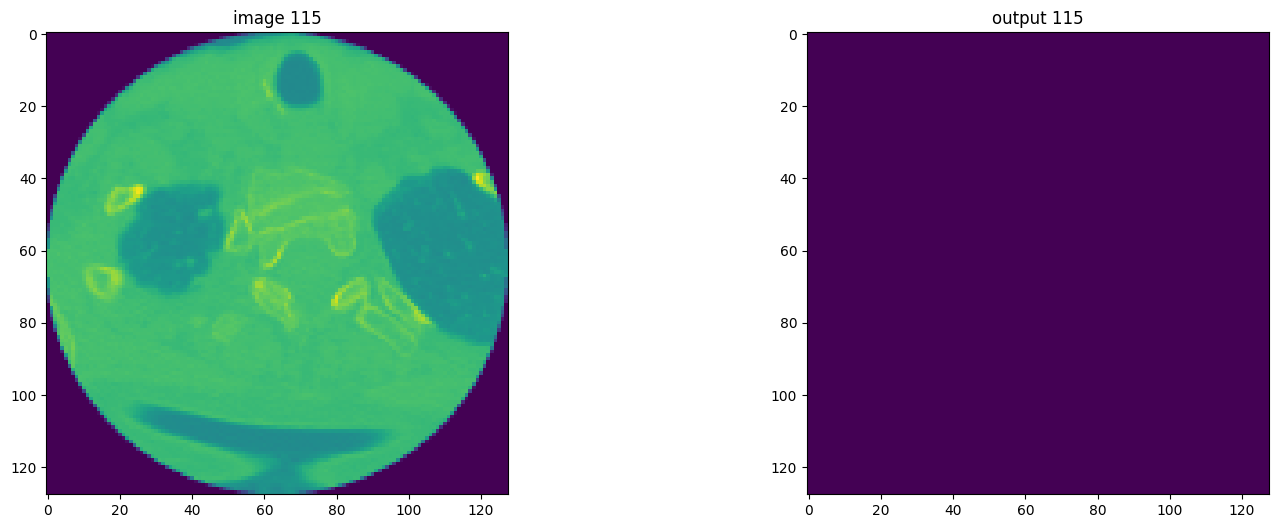

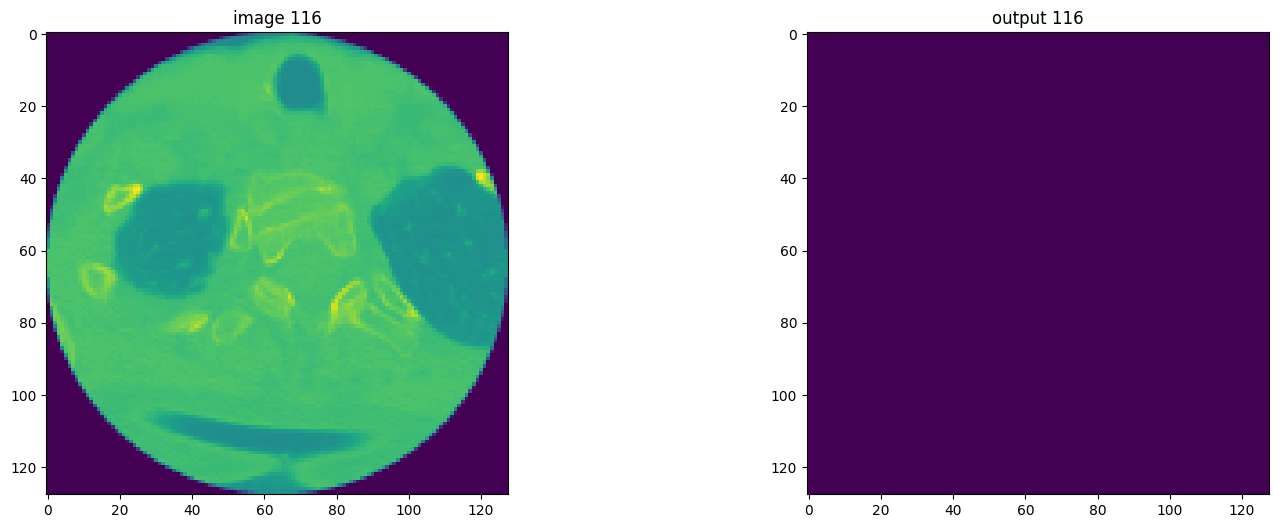

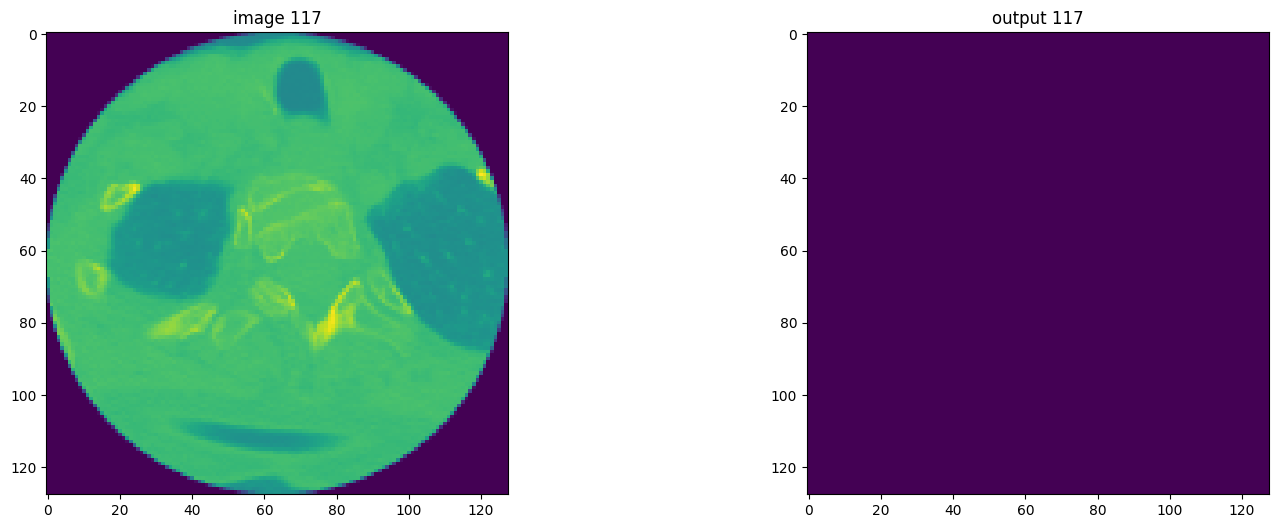

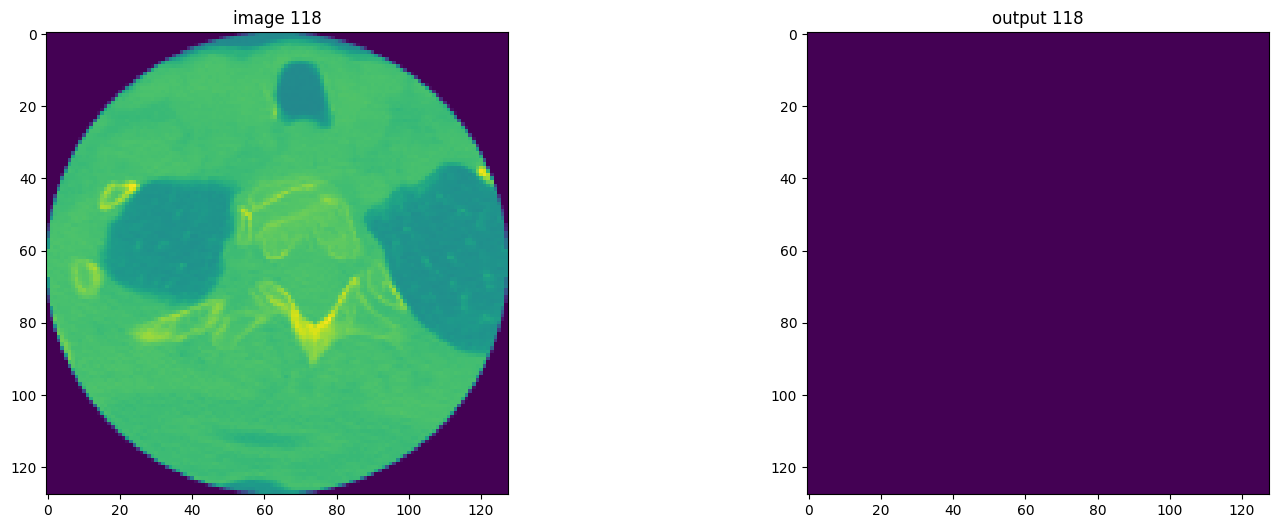

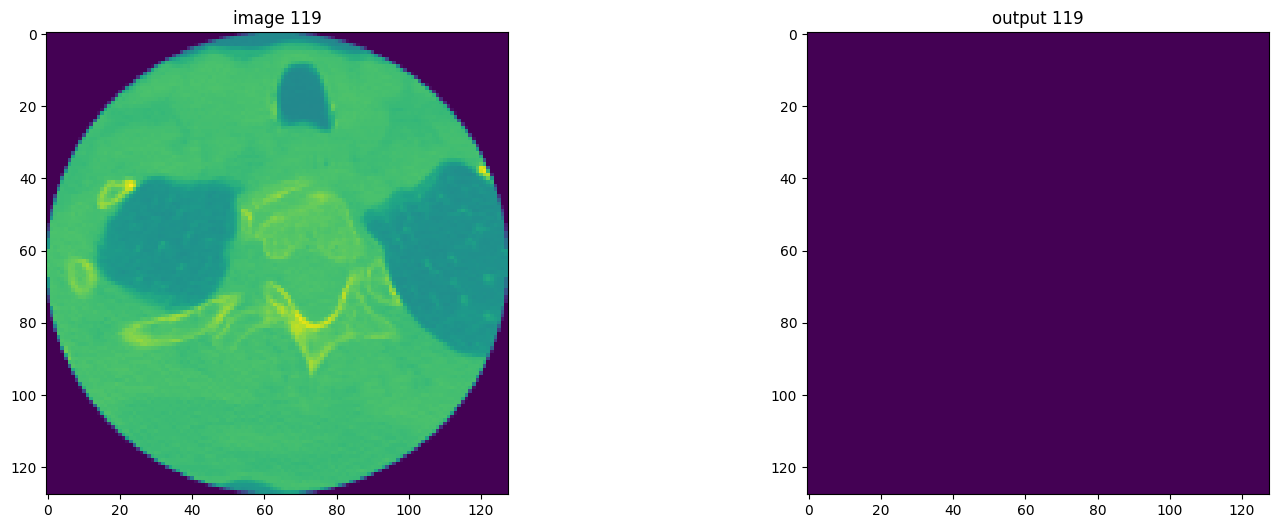

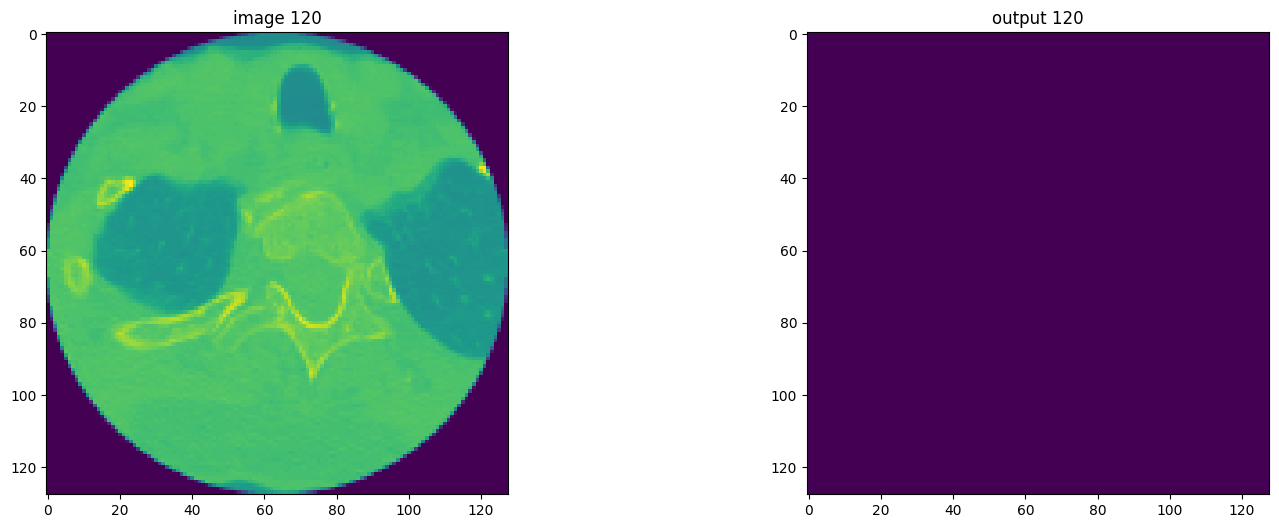

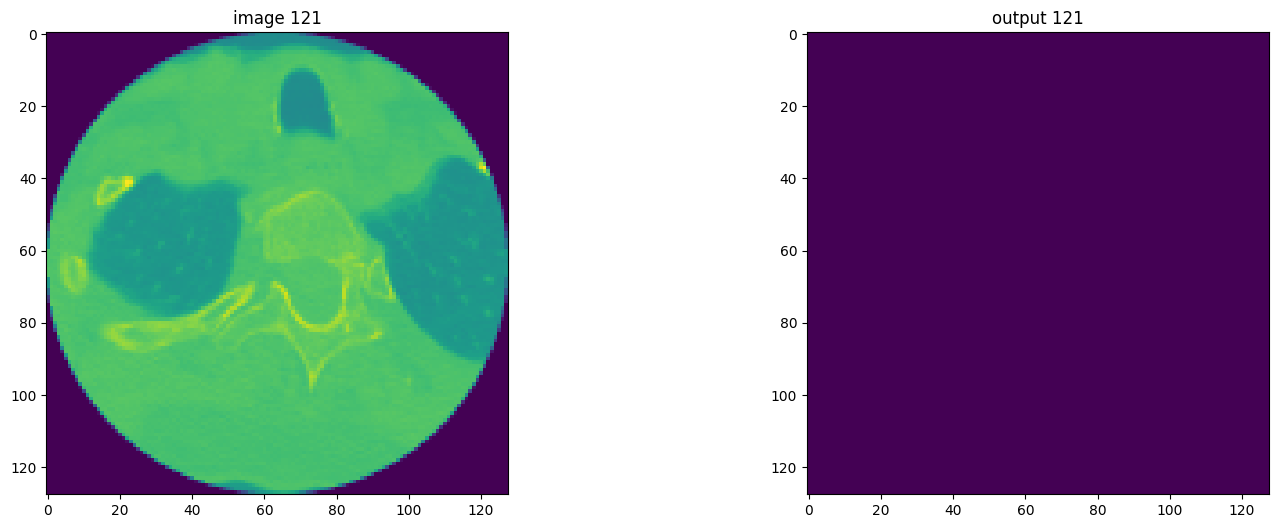

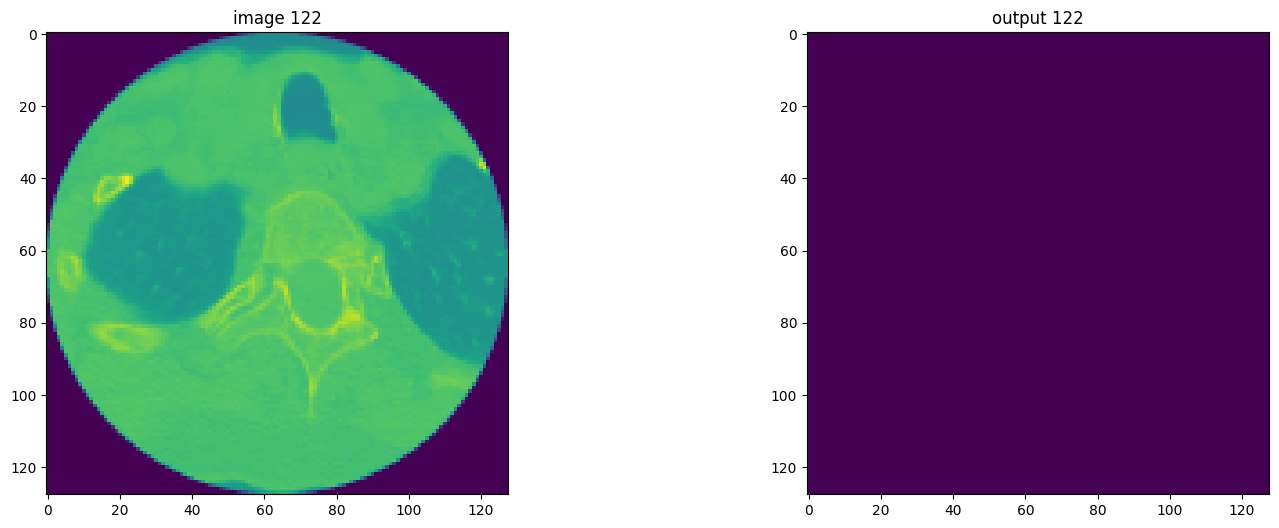

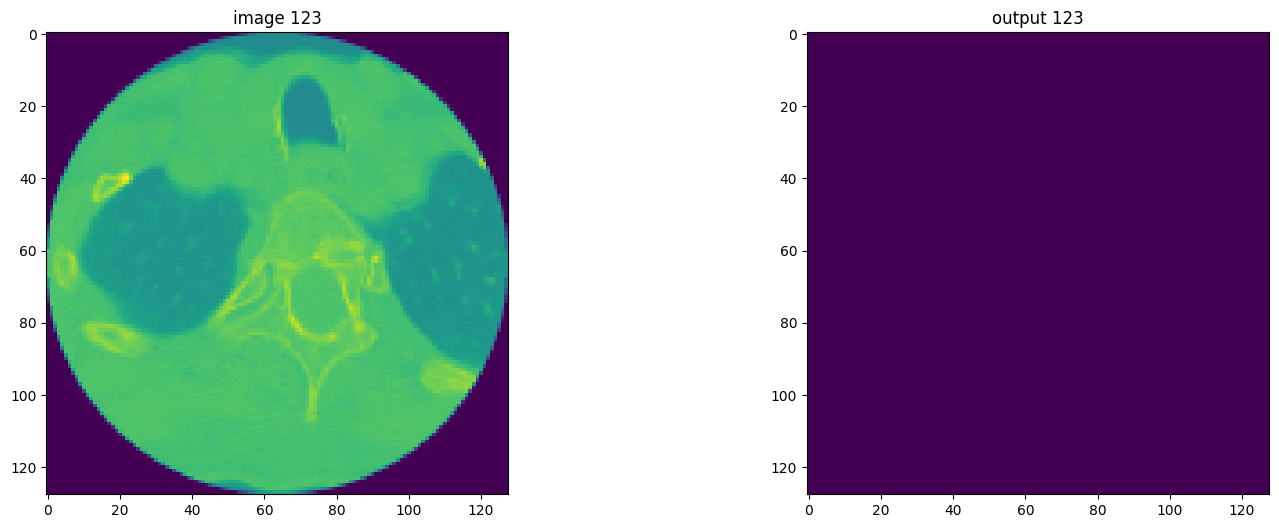

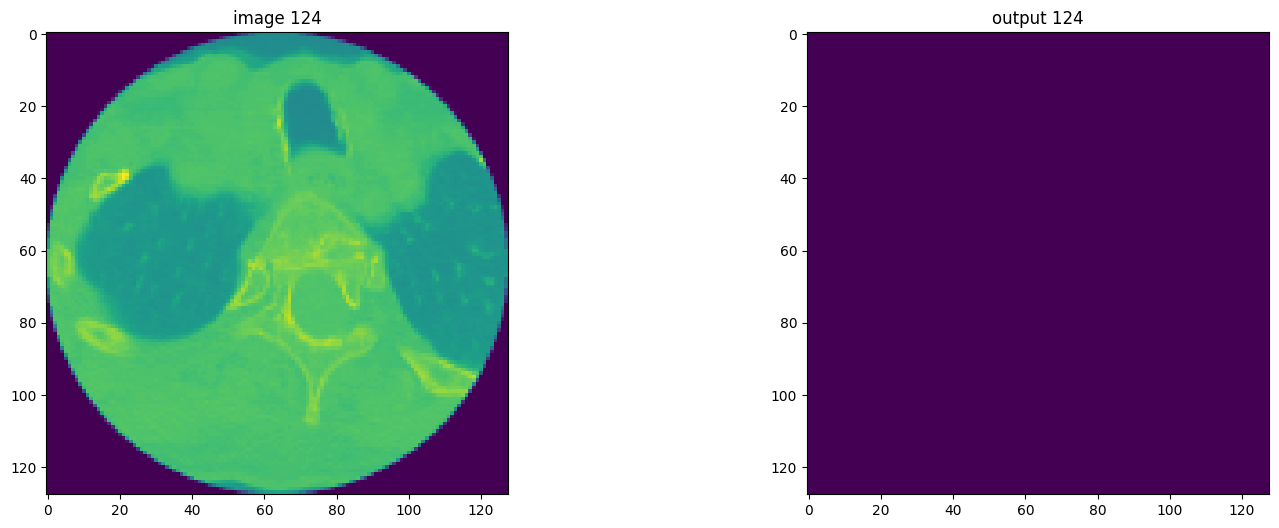

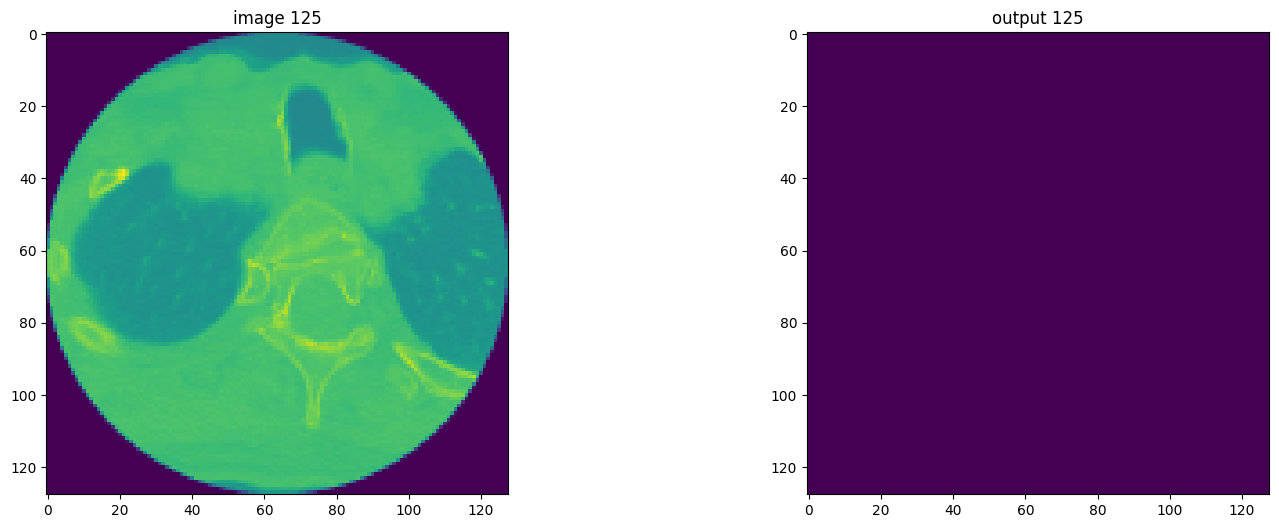

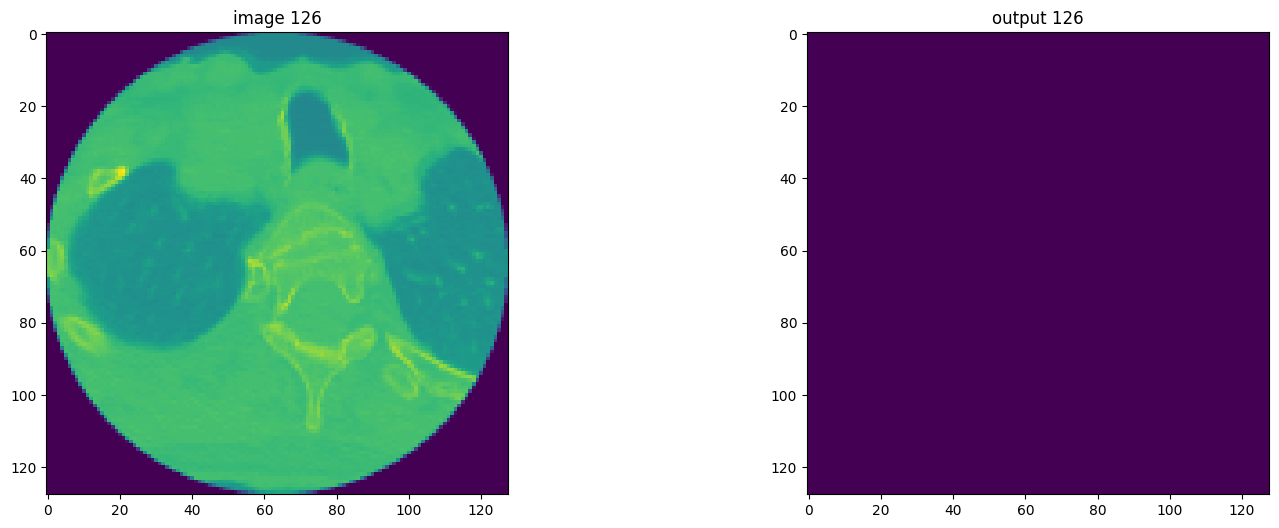

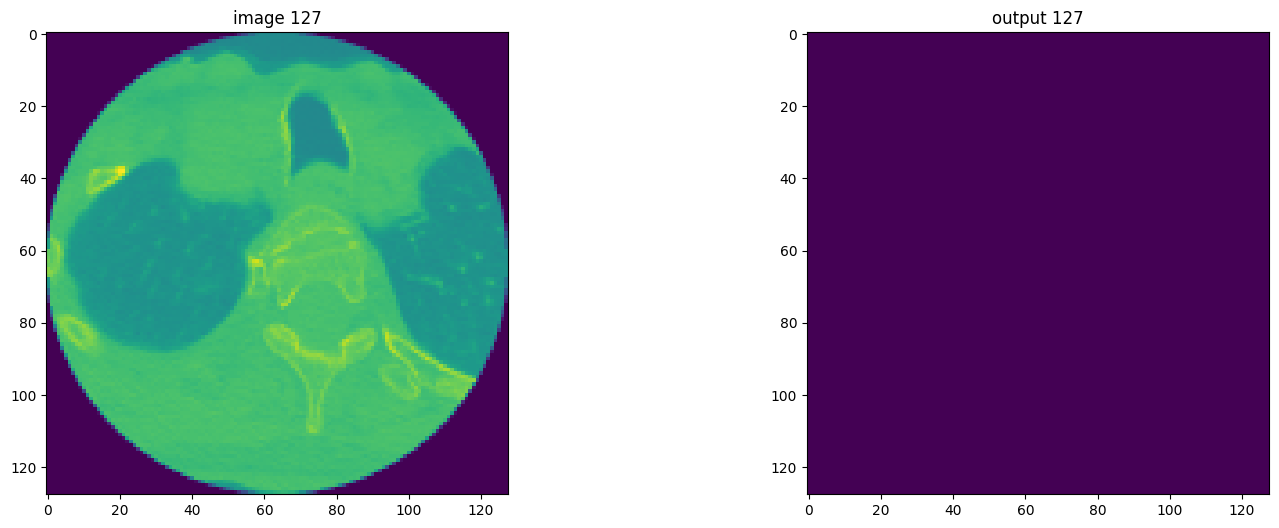

In [18]:
vert = 6 # c5
patient = 0
for i in range(128):
    plt.figure("check", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"image {i}")
    plt.imshow(test_patient[0, 0, :, :, i].cpu())
    plt.subplot(1, 2, 2)
    plt.title(f"output {i}")
    plt.imshow(test_outputs[patient].cpu()[vert, :, :, i])
    plt.show()